<a id='0'></a>
# Multi Node-Modell KAZ

## Table of contents
[01 Imports](#01-Imports)  
[02 Land Availability for Renewable Energy Resources](#02-Land-Availability-for-Renewable-Energy-Resources)  
[03 Prepare Network Data](#03-Prepare-Network-Data)  
&nbsp;&nbsp;&nbsp;&nbsp;[03.1 Prepare Snapshots](#031-Prepare-Snapshots)  
&nbsp;&nbsp;&nbsp;&nbsp;[03.2 Define Economic Parameters](#032-Define-Economic-Parameters)  
&nbsp;&nbsp;&nbsp;&nbsp;[03.3 Read Cost Data](#033-Read-Cost-Data)  
&nbsp;&nbsp;&nbsp;&nbsp;[03.4 Prepare Generators](#034-Prepare-Generators)  
&nbsp;&nbsp;&nbsp;&nbsp;[03.5 Prepare Loads](#035-Prepare-Loads)  
&nbsp;&nbsp;&nbsp;&nbsp;[03.6 PV, Wind and Hydro Availabilities](#036-PV-Wind-and-Hydro-Availabilities)  
&nbsp;&nbsp;&nbsp;&nbsp;[03.7 Prepare Links/Lines](#037-Prepare-LinksLines)  
[04 Set Up Network](#04-Set-Up-Network)  
&nbsp;&nbsp;&nbsp;&nbsp;[04.0 Initialize Network](#040-Initialize-Network)  
&nbsp;&nbsp;&nbsp;&nbsp;[04.1 Add Snapshots](#041-Add-Snapshots)  
&nbsp;&nbsp;&nbsp;&nbsp;[04.2 Add Buses](#042-Add-Buses)  
&nbsp;&nbsp;&nbsp;&nbsp;[04.3 Add Loads](#043-Add-Loads)  
&nbsp;&nbsp;&nbsp;&nbsp;[04.4 Add Carriers](#044-Add-Carriers)  
&nbsp;&nbsp;&nbsp;&nbsp;[04.5 Add Generators](#045-Add-Generators)  
&nbsp;&nbsp;&nbsp;&nbsp;[04.6 Add Links/Lines](#046-Add-LinksLines)  
&nbsp;&nbsp;&nbsp;&nbsp;[04.6.2 Model Imports and Exports](#0462-Model-Imports-and-Exports)  
&nbsp;&nbsp;&nbsp;&nbsp;[04.7 Debugging](#047-Debugging)  
[05 Optimize Network](#05-Optimize-Network)  
&nbsp;&nbsp;&nbsp;&nbsp;[05.0 Network Inspection: Current Situation](#050-Network-Inspection-Current-Situation)  
[05.1 Model Evaluation: Functions for Inspection and Plotting](#051-Model-Evaluation-Functions-for-Inspection-and-Plotting)  
&nbsp;&nbsp;&nbsp;&nbsp;[05.1.1 Capacities Dispatch Utilization](#0511-Capacities-Dispatch-Utilization)  
&nbsp;&nbsp;&nbsp;&nbsp;[05.1.2 Link/Line Inspection](#0512-LinkLine-Inspection)  
&nbsp;&nbsp;&nbsp;&nbsp;[05.1.3 Storage Inspection](#0513-Storage-Inspection)  
&nbsp;&nbsp;&nbsp;&nbsp;[05.1.4 Economics](#0514-Economics)  
&nbsp;&nbsp;&nbsp;&nbsp;[05.1.5 Emissions](#0515-Emissions)  
[06 Scenarios](#06-Scenarios)  
&nbsp;&nbsp;&nbsp;&nbsp;[06.1 Definition](#0601-Definition)  
&nbsp;&nbsp;&nbsp;&nbsp;[06.2 Optimization](#0602-Optimization) 
&nbsp;&nbsp;&nbsp;&nbsp;[06.3 Results](#0603-Results)

<a id="01-Imports"></a>
### 01 Imports

In [265]:
import pypsa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.dates as mdates
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, timedelta
import gurobipy as gp
import linopy as lp
from pyomo.core import ComponentUID
import pyomo.environ as pyo
from openpyxl import Workbook
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.utils import get_column_letter
from openpyxl.worksheet.hyperlink import Hyperlink
from mpl_toolkits.axes_grid1 import make_axes_locatable

<a id="03-Prepare-Network-Data"></a>
### 03 Prepare Network Data

<a id="031-Prepare-Snapshots"></a>
#### 03.1 Prepare Snapshots

In [2]:
# Jahreszeitreihe vorbereiten
start_year = 2022 # für Szenarien anderer Jahre anpassen
start_date = f'{start_year}-01-01'
end_date = f'{start_year}-12-31 23:00:00'
time_resolution = 'H'
year_dates = pd.date_range(start=start_date, end=end_date, freq=time_resolution)

<a id="032-Define-Economic-Parameters"></a>
#### 03.2 Economic Parameters


In [3]:
def calc_annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [4]:
calc_annuity(0.07, 20)

0.09439292574325567

<a id="033-Read-Cost-Data"></a>
#### 03.3 Read-Cost-Data

In [5]:
def get_costs_data(year=2020):
    # Path to the cost data CSV
    path = fr"C:\Users\jan.carsten\Python Programmieren\KostendatenPyPSA\costs_{year}.csv"
    # Read the CSV file
    costs_data = pd.read_csv(path, delimiter=",")
    # Prepare cost data in the existing dataset for further processing
    costs_data.loc[costs_data.unit.str.contains("/kW"), "value"] *= 1e3
    costs_data.unit = costs_data.unit.str.replace("/kW", "/MW")
    # Create a MultiIndex
    costs_data.set_index(['technology', 'parameter'], inplace=True)
    # Define default values
    defaults = {
        "FOM": 0,
        "VOM": 0,
        "efficiency": 1,
        "fuel": 0,
        "investment": 0,
        "lifetime": 25,
        "CO2 intensity": 0,
        "discount rate": 0.07,
    }
    # Unstack and fill with default values
    costs_data = costs_data.value.unstack().fillna(defaults)
    # Specific assignments
    costs_data.at["OCGT", "fuel"] = costs_data.at["gas", "fuel"]
    costs_data.at["CCGT", "fuel"] = costs_data.at["gas", "fuel"]
    costs_data.at["OCGT", "CO2 intensity"] = costs_data.at["gas", "CO2 intensity"]
    costs_data.at["CCGT", "CO2 intensity"] = costs_data.at["gas", "CO2 intensity"]
    # Calculate marginal cost: VOM + (fuel / efficiency)
    costs_data["marginal_cost"] = costs_data["VOM"] + costs_data["fuel"] / costs_data["efficiency"]
    # Calculate annuity and capital cost
    annuity = costs_data.apply(lambda x: calc_annuity(x["discount rate"], x["lifetime"]), axis=1)
    costs_data["capital_cost"] = (annuity + costs_data["FOM"] / 100) * costs_data["investment"]
    return costs_data

year = 2020 # set default to 2020
costs_data = get_costs_data(year)

In [6]:
# Testen ob es geklappt hat: 
#print("CO2 Intensity for OCGT:", costs_data.at["gas", "CO2 intensity"])
#print("CO2 Intensity for CCGT:", costs_data.at["gas", "CO2 intensity"])
#print("CO2 Intensity for coal:", costs_data.at["coal", "CO2 intensity"])
print("Investmentcost Hydro :", costs_data.at["hydro", "investment"])
print("Investmentcost onwind:", costs_data.at["onwind", "investment"])
print("CAPEX Hydro :", costs_data.at["hydro", "capital_cost"])
print("CAPEX onwind:", costs_data.at["onwind", "capital_cost"])
print("marginal_cost Hydro :", costs_data.at["hydro", "marginal_cost"])
print("marginal_cost onwind:", costs_data.at["onwind", "marginal_cost"])

Investmentcost Hydro : 2274817.7
Investmentcost onwind: 1183911.9000000001
CAPEX Hydro : 182698.73459185107
CAPEX onwind: 113584.19278649535
marginal_cost Hydro : 0.0
marginal_cost onwind: 1.5873


In [7]:
#kurzfristige marginale Kosten berechnen: erstelt neue Spalte mit Marginal Cost.
# marginal_cost = VOM + (fuel / efficiency).
#costs_data["marginal_cost"] = costs_data["VOM"] + costs_data["fuel"] / costs_data["efficiency"]

In [8]:
# Annuitäten der Investkosten in €/MW/a : Wendet Annuitätenfunktion an und 
#annuity = costs_data.apply(lambda x: calc_annuity(x["discount rate"], x["lifetime"]), axis=1)

In [9]:
#erstellt neue spalte mit capital cost.
#costs_data["capital_cost"] = (annuity + costs_data["FOM"] / 100) * costs_data["investment"]
#print(costs_data.head())

<a id="034-Prepare-Generators"></a>
#### 03.4 Prepare Generators

In [10]:
# Generatoren Daten einlesen und gruppieren, nicht gebrauchte Informationen droppen
generators_df = pd.read_csv(r"C:\Users\jan.carsten\Python Programmieren\04 Multi Node Network\AGORA_custom_powerplants.csv")
# Fueltypes anpassen, damit die Namen zu costdata und carrier data passen:
generators_df['Fueltype'] = generators_df['Fueltype'].replace({
    "Hard Coal": "coal",
    "Wind": "onwind",
    "Solar": "solar",
    "Hydro": "hydro"})
print(generators_df['Fueltype'].unique())

['coal' 'CCGT' 'OCGT' 'hydro' 'onwind' 'solar']


In [11]:
print(generators_df['Fueltype']=='hydro')

0      False
1      False
2      False
3      False
4      False
       ...  
139    False
140    False
141    False
142    False
143    False
Name: Fueltype, Length: 144, dtype: bool


In [12]:
#Generatoren anhand der lat/lon Werte einer Region nach Shapefile zuweisen
# Laden der Shapefile-Daten der Regionen
shapefile_path = r"C:\Users\jan.carsten\Python Programmieren\04 Multi Node Network\kaz_adm_unhcr_2023_shp\kaz_admbnda_adm1_unhcr_2023.shp"  # Pfad zur Shapefile-Datei
regions = gpd.read_file(shapefile_path)
# Erstellen eines GeoDataFrame für die Generatoren
geometry = [Point(xy) for xy in zip(generators_df['lon'], generators_df['lat'])]
geo_df = gpd.GeoDataFrame(generators_df, geometry=geometry)
# Setzen des CRS (Coordinate Reference System)
geo_df.set_crs(epsg=4326, inplace=True)  # WGS84
regions = regions.to_crs(epsg=4326)  # Konvertieren Sie das CRS der Regionen zu WGS84, falls notwendig
# Räumlicher Join, um die Regionen zuzuweisen
geo_df_with_regions = gpd.sjoin(geo_df, regions, how="left", predicate="within")
# Extrahieren der Regionenspalte und aktualisieren des DataFrame
generators_df['Region'] = geo_df_with_regions['ADM1_EN']  # 'NAME_1' sollte durch den tatsächlichen Namen der Regionenspalte im Shapefile ersetzt werden
# Entfernen des Wortes "Region" aus den Regionsnamen
generators_df['Region'] = generators_df['Region'].str.replace(' Region', '')
#print(generators_df[['Capacity', 'Fueltype', 'Region']])
print(generators_df.columns)
# Änderungen in den Namen der Fueltypes vornehmen:

Index(['Unnamed: 0', 'Name', 'Fueltype', 'Technology', 'Set', 'Country',
       'Capacity', 'Efficiency', 'Duration', 'Volume_Mm3', 'DamHeight_m',
       'StorageCapacity_MWh', 'DateIn', 'DateRetrofit', 'DateMothball',
       'DateOut', 'lat', 'lon', 'EIC', 'projectID', 'bus', 'Region'],
      dtype='object')


In [13]:
# Df weiter formatiren, Turkistan durch South Kazakhstan ersetzen, Generatorkapazitäten desselben Fueltypes kumulieren:
# Mapping der Regionen
region_mapping = { # ggf. nocheinmal anpassen.
    'Akmola': ['Astana', 'Akmola'],
    'Karaganda': ['Karaganda', 'Ulytau'],
    'Zhambyl': ['Jambyl'],
    'East Kazakhstan': ['Abay', 'East Kazakhstan'],
    'Almaty': ['Jetisu', 'Almaty'],
    'South Kazakhstan': ['Turkistan', 'Shymkent'],
    'Aktobe': ['Aktobe'],
    'Atyrau': ['Atyrau'],
    'Kyzylorda': ['Kyzylorda'],
    'Kostanay': ['Kostanay'],
    'Mangystau': ['Mangystau'],
    'North Kazakhstan': ['North Kazakhstan'],
    'Pavlodar': ['Pavlodar'],
    'West Kazakhstan': ['West Kazakhstan'],
}
#Umkehren des Mappings für einfaches Ersetzen
reverse_mapping = {v: k for k, values in region_mapping.items() for v in values}
# Ersetzen der Regionen basierend auf dem Mapping
generators_df['Region'] = generators_df['Region'].replace(reverse_mapping)
# Gruppieren nach Region und Fueltype und Aggregieren der Daten
aggregated_df = generators_df.groupby(['Region', 'Fueltype']).agg({
    'Capacity': 'sum',
    'DateIn': 'mean',
    'DateOut': 'mean',
    'Efficiency': lambda x: None,
    'Duration': lambda x: None,
    'Volume_Mm3': lambda x: None,
    'DamHeight_m': lambda x: None,
    'StorageCapacity_MWh': lambda x: None,
    'DateRetrofit': lambda x: None,
    'DateMothball': lambda x: None,
    'lat': lambda x: None,
    'lon': lambda x: None,
    'EIC': lambda x: None,
    'projectID': lambda x: None,
    'bus': lambda x: None
}).reset_index()
# Hinzufügen der anderen Spalten mit NaN-Werten
for col in ['Technology', 'Set', 'Country']:
    aggregated_df[col] = None
# generators_df überschreiben:
#generators_df = aggregated_df # dieses würde die Kraftwerke desselben Carriers pro Region akkumulieren und als ein Kraftwerk betrachten (eher nicht, da Ergebnisse stark verfälscht werden)
# Überprüfen des modifizierten DataFrames
#print(aggregated_df)
print(aggregated_df['Capacity'].sum())# ab hier morgen weiter. GGf Fueltype Namen ändern

# aggregated_df bitte nicht benutzen.

22268.89


<a id="035-Prepare-Loads"></a>
#### 03.5 Prepare Loads

In [14]:
# Loads einlesen
loads_df = pd.read_excel(r"C:\Users\jan.carsten\Python Programmieren\04 Multi Node Network\new_yearly_profile_2022er Daten.xlsx", index_col=0)
# Änderung des Zeitindex von 2019 auf 2022
loads_df.index = pd.to_datetime(loads_df.index).map(lambda x: x.replace(year=start_year))
print(loads_df.head())
# Checken, ob Gesamtsummen stimmen?
# Berechnung der Gesamtsumme über alle Spalten und Zeitschritte für das neu erstelle Jahresprofil:
total_sum = loads_df.sum().sum()
print(f"Gesamtsumme über alle Spalten und Zeitschritte: {total_sum} kWh")

                          Akmola  North Kazakhstan  West Kazakhstan  \
2022-01-01 00:00:00  1339.942490        203.509808       331.860037   
2022-01-01 01:00:00  1248.206809        188.205209       301.183899   
2022-01-01 02:00:00  1165.494310        173.727885       281.662721   
2022-01-01 03:00:00  1144.440219        179.518815       273.296501   
2022-01-01 04:00:00  1133.913174        179.105177       257.958432   

                         Aktobe       Almaty  East Kazakhstan   Mangystau  \
2022-01-01 00:00:00  895.798812  1574.247312      1256.632400  712.061699   
2022-01-01 01:00:00  879.117269  1456.919184      1242.861086  698.162597   
2022-01-01 02:00:00  825.736335  1365.790540      1210.728021  699.231759   
2022-01-01 03:00:00  857.431265  1313.391570      1210.728021  699.231759   
2022-01-01 04:00:00  859.099419  1362.373216      1204.989973  717.407508   

                         Atyrau    Kostanay     Pavlodar    Karaganda  \
2022-01-01 00:00:00  849.202168  582.

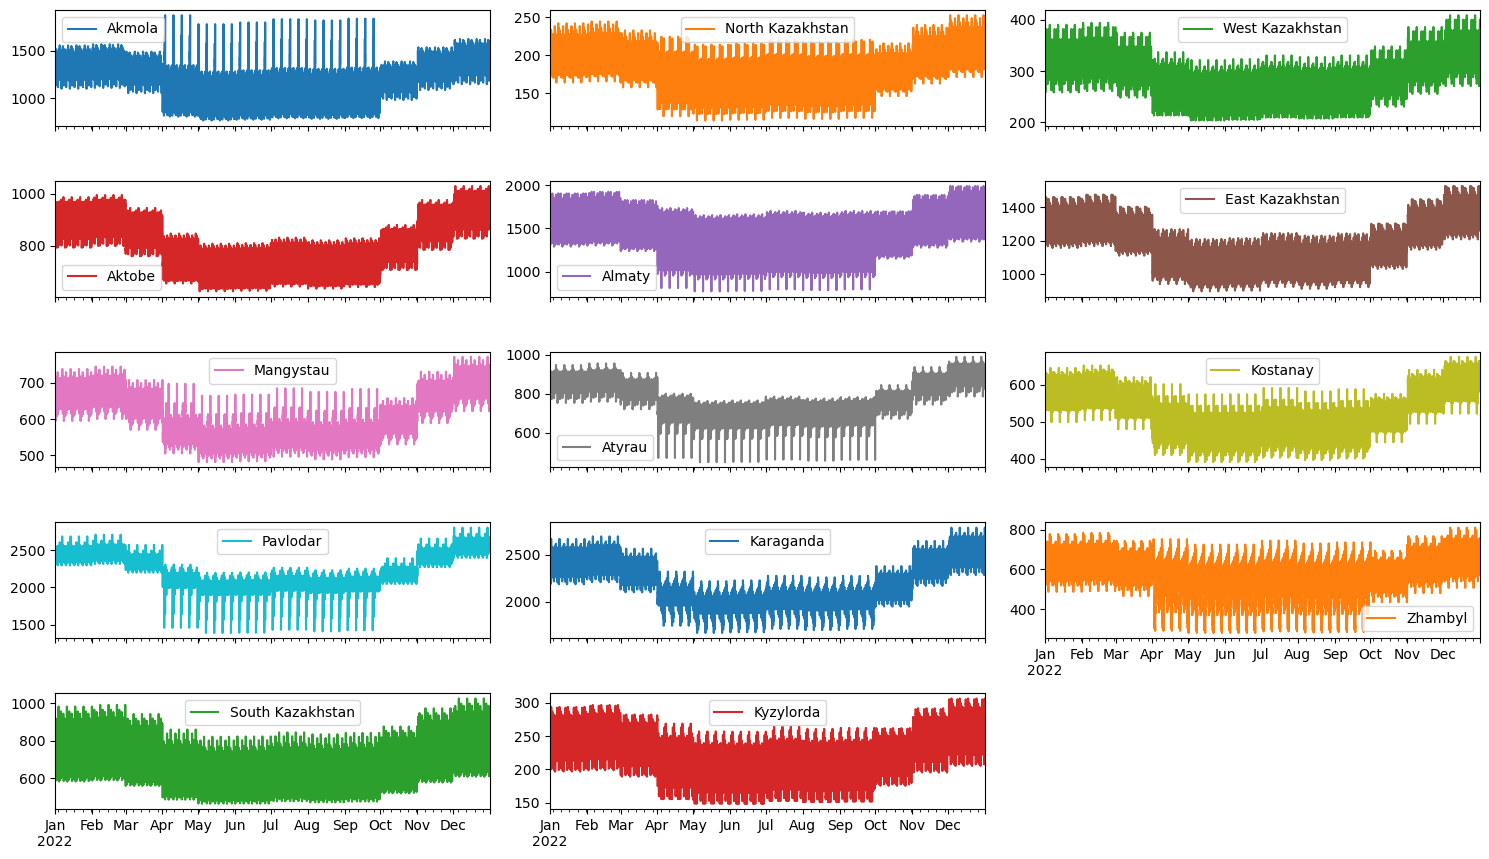

In [15]:
# Neues Jahresprofil plotten (Alle Werte sind nun in kWh)
loads_df.plot(subplots=True, layout=(6, 3), figsize=(15, 10), sharex=True)
plt.tight_layout()
plt.show() 

<a id="036-PV-Wind-and-Hydro-Availabilities"></a>
#### 03.6 PV, Wind and Hydro Availabilities

In [16]:
#Dataframes für Wind für sämtliche Daten erstellen: Einlesen, Jahr auf 2022 ändern; Potentielle Probleme: Local Time der Zonen kann sich unterscheiden, das ignoriere ich derzeit. Beide arbeiten mit Local Time, also nicht synchron.
directory_path = r"C:\Users\jan.carsten\Python Programmieren\04 Multi Node Network\wind_pv_profiles"
unique_buses = generators_df["Region"].unique()
all_profiles = pd.DataFrame()
for region in unique_buses:
    file_name = f"{region}_wind.csv"
    file_path = os.path.join(directory_path, file_name)
    if os.path.exists(file_path):
        # Windprofil einlesen, Daten ab der 4. Zeile
        profile = pd.read_csv(file_path, skiprows=3)
        # Korrigieren der Spaltennamen (entfernen von Leerzeichen, falls vorhanden)
        profile.columns = [col.strip() for col in profile.columns]
        # Überprüfen, ob die erwarteten Spalten vorhanden sind
        if 'local_time' in profile.columns and 'electricity' in profile.columns:
            # Sicherstellen, dass 'local_time' als datetime eingelesen wird
            profile['local_time'] = pd.to_datetime(profile['local_time'])
            # Setze 'local_time' als Index
            profile.set_index('local_time', inplace=True)
            # Die letzten fünf Stunden extrahieren
            last_six_hours = profile.tail(6)
            # Restliche Daten ohne die letzten fünf Stunden
            profile = profile.iloc[:-6]
            # Die letzten fünf Stunden an den Anfang setzen und den Zeitindex anpassen
            profile = pd.concat([last_six_hours, profile])
            # Jahr auf 2022 ändern
            profile.index = profile.index.map(lambda x: x.replace(year=start_year))
            # Überprüfen und Entfernen von Duplikaten im Index
            profile = profile[~profile.index.duplicated(keep='first')]
            # Sicherstellen, dass all_profiles keine doppelten Indizes hat
            all_profiles = all_profiles[~all_profiles.index.duplicated(keep='first')]
            # Profile in den gesamten DataFrame einfügen
            all_profiles[region] = profile['electricity']
        else:
            print(f"Erwartete Spalten nicht in Datei {file_name} gefunden.")
    else:
        print(f"Datei {file_name} existiert nicht im Verzeichnis.")
#print(all_profiles.head())

In [17]:
# Analog für PV Daten:
# Erstellen eines leeren DataFrames, um die Daten zu speichern
all_profiles_pv = pd.DataFrame()
# Alle Dateien im Verzeichnis durchlaufen
for region in unique_buses:
    file_name = f"{region}_pv.csv"
    file_path = os.path.join(directory_path, file_name)
    if os.path.exists(file_path):
        # PV-Profil einlesen, Daten ab der 5. Zeile
        profile = pd.read_csv(file_path, skiprows=3)
        # Korrigieren der Spaltennamen (entfernen von Leerzeichen, falls vorhanden)
        profile.columns = [col.strip() for col in profile.columns]
        # Überprüfen, ob die erwarteten Spalten vorhanden sind
        if 'local_time' in profile.columns and 'electricity' in profile.columns:
            # Sicherstellen, dass 'local_time' als datetime eingelesen wird
            profile['local_time'] = pd.to_datetime(profile['local_time'])
            # Setze 'local_time' als Index
            profile.set_index('local_time', inplace=True)
            # Die letzten sechs Stunden extrahieren
            last_six_hours = profile.tail(6)
            # Restliche Daten ohne die letzten sechs Stunden
            profile = profile.iloc[:-6]
            # Die letzten sechs Stunden an den Anfang setzen und den Zeitindex anpassen
            profile = pd.concat([last_six_hours, profile])
            # Jahr auf 2022 ändern
            profile.index = profile.index.map(lambda x: x.replace(year=start_year))
            # Überprüfen und Entfernen von Duplikaten im Index
            profile = profile[~profile.index.duplicated(keep='first')]
            # Sicherstellen, dass all_profiles_pv keine doppelten Indizes hat
            all_profiles_pv = all_profiles_pv[~all_profiles_pv.index.duplicated(keep='first')]
            # Pofile in den gesamten DataFrame einfügen
            all_profiles_pv[region] = profile['electricity']
        else:
            print(f"Erwartete Spalten nicht in Datei {file_name} gefunden.")
    else:
        print(f"Datei {file_name} existiert nicht im Verzeichnis.")
# Ergebnis anzeigen zur Korrektur:
test_date = f'{start_year}-01-01'
first_day_akmola = all_profiles_pv.loc[test_date, 'Akmola']
#print(first_day_akmola)

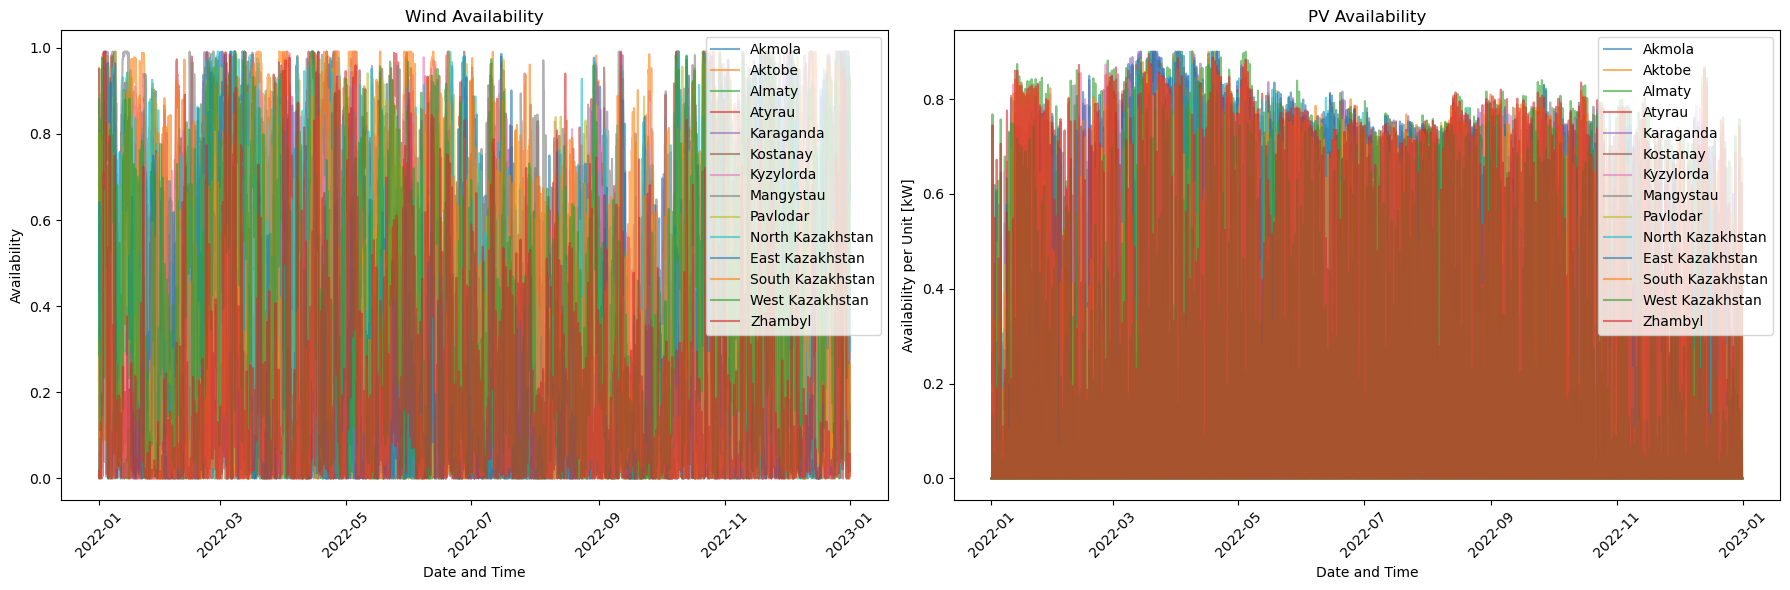

In [18]:
# Plotting: Jahresprofile
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
# Plot für Wind Verfügbarkeit
for region in all_profiles.columns:
    axes[0].plot(all_profiles.index, all_profiles[region], label=region, alpha=0.6)  # Alpha für Transparenz
axes[0].set_title('Wind Availability')
axes[0].set_xlabel('Date and Time')
axes[0].set_ylabel('Availability')
axes[0].legend(loc='upper right')
axes[0].tick_params(axis='x', rotation=45)
# Plot für PV Verfügbarkeit
for region in all_profiles_pv.columns:
    axes[1].plot(all_profiles_pv.index, all_profiles_pv[region], label=region, alpha=0.6)  # Alpha für Transparenz
axes[1].set_title('PV Availability')
axes[1].set_xlabel('Date and Time')
axes[1].set_ylabel('Availability per Unit [kW]')
axes[1].legend(loc='upper right')
axes[1].tick_params(axis='x', rotation=45)
# Layout anpassen, um Überlappungen zu vermeiden
plt.tight_layout()
# Gesamten Plot anzeigen
plt.show()

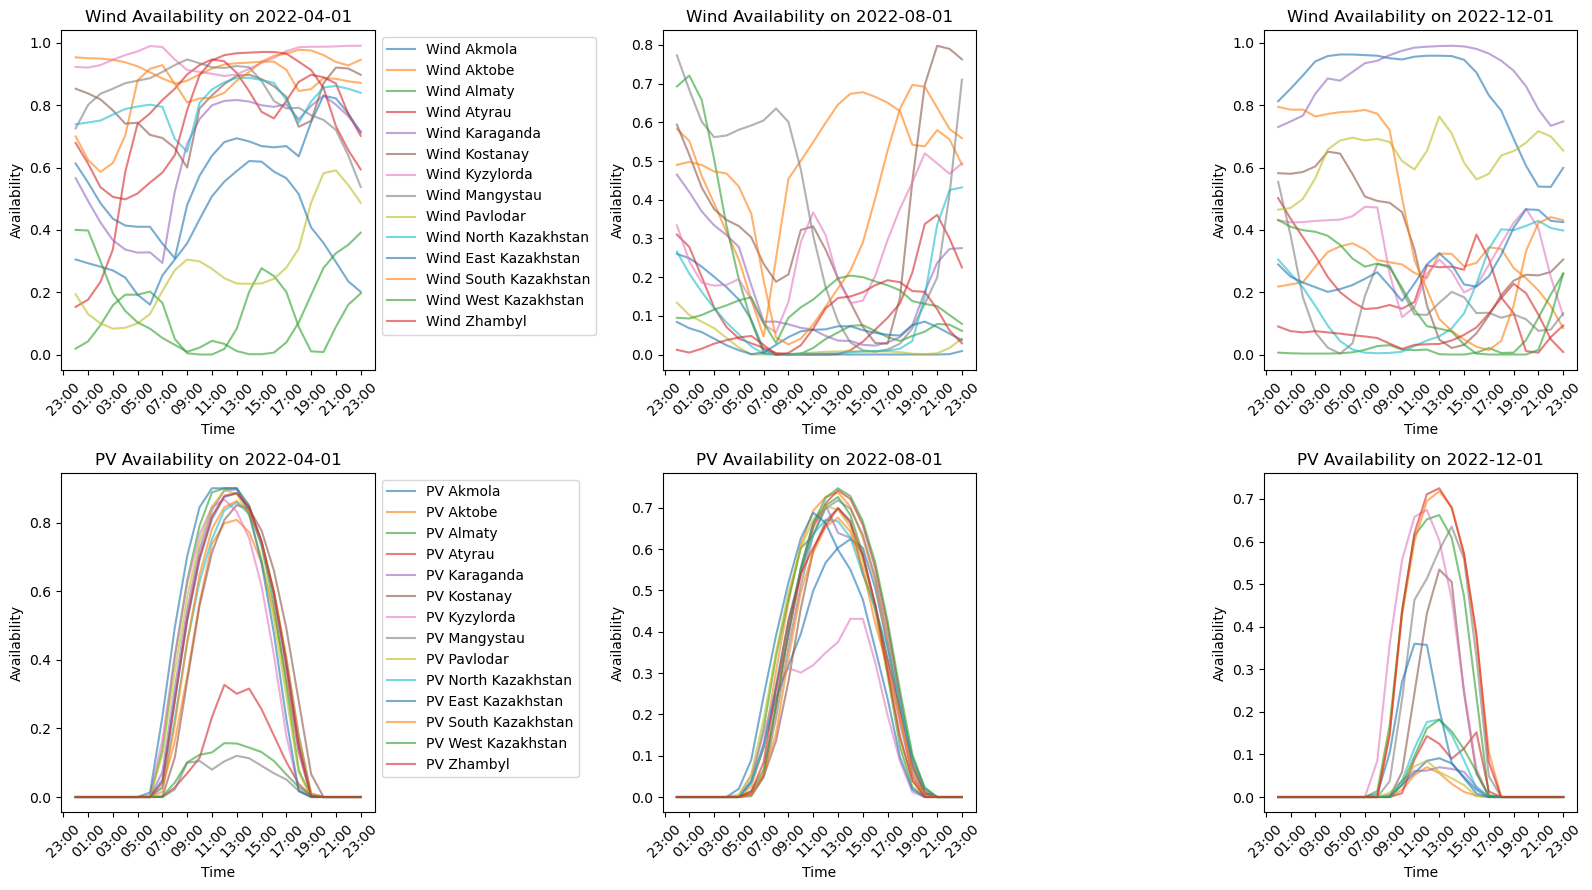

In [19]:
# Verfügbarkeiten betrachten: Drei repräsentative Tage
test_apr = f'{start_year}-04-01'
test_aug = f'{start_year}-08-01'
test_dez = f'{start_year}-12-01'
dates = [test_apr, test_aug, test_dez]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 9))  # 2 Zeilen, 3 Spalten
# Erste Zeile für Windverfügbarkeit
for i, date in enumerate(dates):
    day_data_wind = all_profiles.loc[date]
    for region in all_profiles.columns:
        axes[0, i].plot(day_data_wind.index, day_data_wind[region], alpha=0.6, label=f'Wind {region}')
    axes[0, i].set_title(f'Wind Availability on {date}')
    axes[0, i].set_xlabel('Time')
    axes[0, i].set_ylabel('Availability')
    # X-Achse formatieren, um nur die Uhrzeit anzuzeigen
    axes[0, i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    axes[0, i].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(axes[0, i].xaxis.get_majorticklabels(), rotation=45)
    # Nur die Legende des ersten Plots anzeigen
    if i == 0:
        axes[0, i].legend(loc='upper left', bbox_to_anchor=(1, 1))
# Zweite Zeile für PV-Verfügbarkeit
for i, date in enumerate(dates):
    day_data_pv = all_profiles_pv.loc[date]
    for region in all_profiles_pv.columns:
        axes[1, i].plot(day_data_pv.index, day_data_pv[region], alpha=0.6, label=f'PV {region}')
    axes[1, i].set_title(f'PV Availability on {date}')
    axes[1, i].set_xlabel('Time')
    axes[1, i].set_ylabel('Availability')
    # X-Achse formatieren, um nur die Uhrzeit anzuzeigen
    axes[1, i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    axes[1, i].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(axes[1, i].xaxis.get_majorticklabels(), rotation=45)
    # Nur die Legende des ersten Plots anzeigen
    if i == 0:
        axes[1, i].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

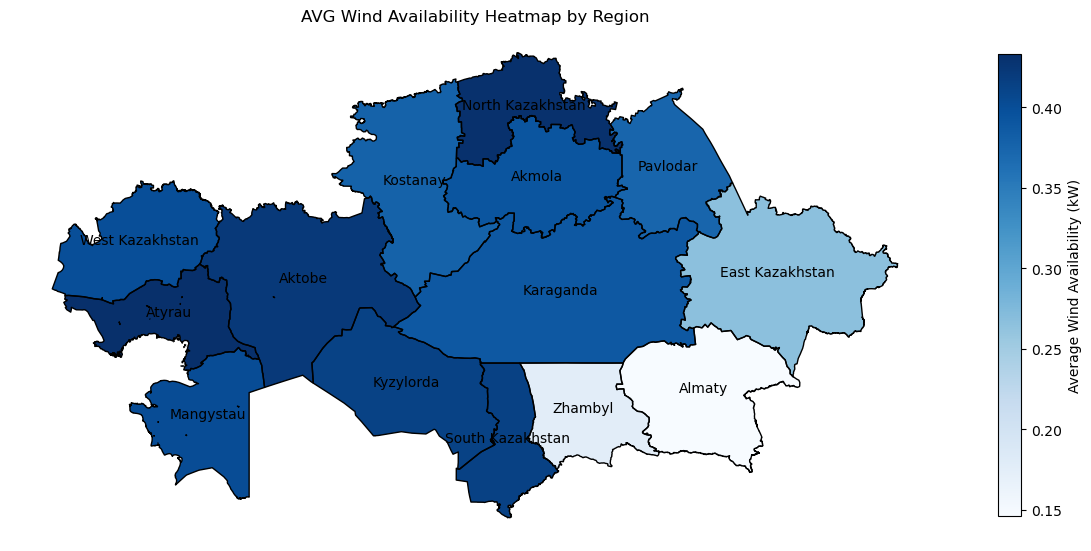

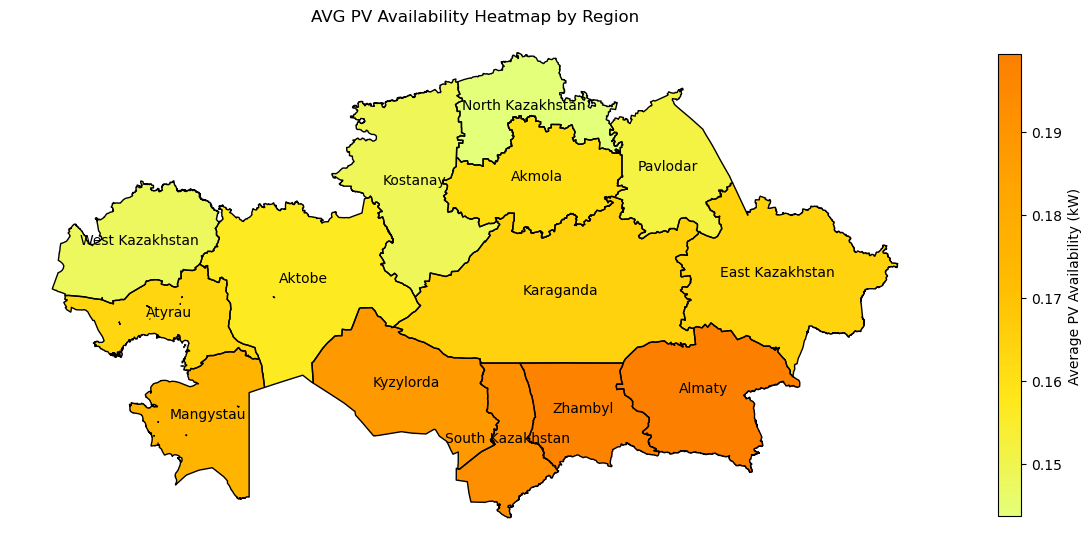

In [20]:
def plot_availability_heatmap(profiles, shapefile_path, region_mapping, title, cmap, value_label):
    region_mapping = {
    'Akmola': ['Astana', 'Akmola Region'],
    'Karaganda': ['Karaganda Region', 'Ulytau Region'],
    'Zhambyl': ['Jambyl Region'],
    'East Kazakhstan': ['Abay Region', 'East Kazakhstan Region'],
    'Almaty': ['Jetisu Region', 'Almaty', 'Almaty Region'],
    'South Kazakhstan': ['Turkistan Region', 'Shymkent'],
    'Aktobe': ['Aktobe Region'],
    'Atyrau': ['Atyrau Region'],
    'Kyzylorda': ['Kyzylorda Region'],
    'Kostanay': ['Kostanay Region'],
    'Mangystau': ['Mangystau Region'],
    'North Kazakhstan': ['North Kazakhstan Region'],
    'Pavlodar': ['Pavlodar Region'],
    'West Kazakhstan': ['West Kazakhstan Region'],
    }
    shapefile_path = r"C:\Users\jan.carsten\Python Programmieren\04 Multi Node Network\kaz_adm_unhcr_2023_shp\kaz_admbnda_adm1_unhcr_2023.shp"
    regions = gpd.read_file(shapefile_path)
    # Calculate the mean availability per region
    mean_availability_by_region = profiles.mean(axis=0)
    # Create a DataFrame for the mean availability to merge with GeoDataFrame
    availability_df = pd.DataFrame(mean_availability_by_region).reset_index()
    availability_df.columns = ['region', 'mean_availability']
    # Load shapefile data of regions
    regions = gpd.read_file(shapefile_path)
    # Initialize a new DataFrame for the merged data
    merged_data = []
    # Apply the mapping to the regions GeoDataFrame
    for region, subregions in region_mapping.items():
        # Filter regions that match the current group of subregions
        subregion_shapes = regions[regions['ADM1_EN'].isin(subregions)]
        if not subregion_shapes.empty:
            # Dissolve the subregions into a single shape for the current region
            merged_shape = subregion_shapes.unary_union
            # Calculate the average availability for the merged region
            if region in mean_availability_by_region.index:
                avg_availability = mean_availability_by_region[region]
                merged_data.append({'Region': region, 'geometry': merged_shape, 'mean_availability': avg_availability})
            else:
                print(f"Availability for region {region} not found in mean_availability_by_region.")
        else:
            print(f"No subregion shapes found for region {region} with subregions {subregions}.")
    # Create a GeoDataFrame from the merged regions
    merged_gdf = gpd.GeoDataFrame(merged_data, crs=regions.crs)
    # Plot the availability heatmap
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    merged_gdf.boundary.plot(ax=ax, linewidth=1, color='black')
    plot = merged_gdf.plot(column='mean_availability', ax=ax, legend=True, cmap=cmap, legend_kwds={'label': value_label, 'orientation': "vertical", 'shrink': 0.6})
    # Annotate the regions with their names at the centroid of each region
    for idx, row in merged_gdf.iterrows():
        centroid = row['geometry'].centroid
        ax.annotate(text=row['Region'], xy=(centroid.x, centroid.y), horizontalalignment='center', fontsize=10, color='black')
    ax.set_title(title)
    ax.set_axis_off()
    plt.show()
# Plot wind availability heatmap
plot_availability_heatmap(all_profiles, shapefile_path, region_mapping, 'AVG Wind Availability Heatmap by Region', 'Blues', 'Average Wind Availability (kW)')
# Plot PV availability heatmap
plot_availability_heatmap(all_profiles_pv, shapefile_path, region_mapping, 'AVG PV Availability Heatmap by Region', 'Wistia', 'Average PV Availability (kW)')

In [21]:
# Takeaway: Wind: Almaty, East Kazakhstan and Zhambyl have the weakest windpotential. All the others are similar
# Takeawa: PV: Similar Potential but Almaty, Kyzylorda, Mangystau, South Kazakhstan and Zhambyl have the best pv potential.
# Frage: Was genau passiert mit den renewable.ninjas kw Werten? Sind die pro Turbine oder pro Region? Wie genau sind die zu verstehen?

#### Hydroprofile preparation

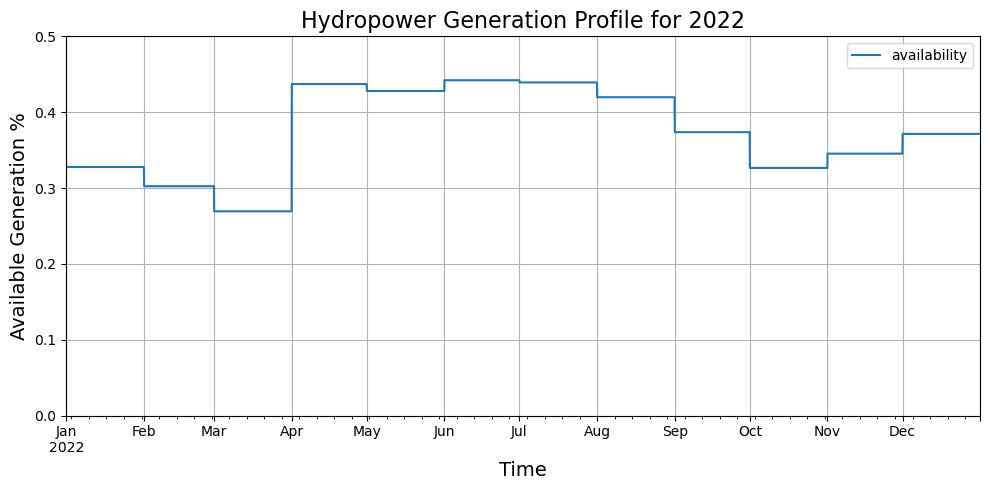

In [22]:
# Read the hydro profile data
hydroprofile = pd.read_csv(r"C:\Users\jan.carsten\Python Programmieren\04 Multi Node Network\hydropower_profile\normalized_hydropower_profile_2022.csv", index_col=0)
# Rename the column "0" to "availability" in the hydroprofile DataFrame
hydroprofile.rename(columns={'0': 'availability'}, inplace=True)
# Ensure the index is datetime
hydroprofile.index = pd.to_datetime(hydroprofile.index)
# Resample the hydro profile to match the 2-hour intervals using mean
hydroprofile_resampled = hydroprofile.resample(time_resolution).mean()
# Check the length to ensure it matches
assert len(hydroprofile_resampled) == len(year_dates), "Length mismatch after resampling"
# Set the index to the prepared date range
hydroprofile_resampled.index = year_dates
# Create the plot with a larger figure size
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the hydro profile
hydroprofile_resampled.plot(ax=ax)
# Set title and labels
ax.set_title(f'Hydropower Generation Profile for {start_year}', fontsize=16)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Available Generation %', fontsize=14)
ax.set_ylim(0, 0.5)  # Set the y-axis limits
ax.grid(True)
# Adjust layout
plt.tight_layout()
# Show the plot
plt.show()

In [23]:
# Find all time steps with NaN entries in hydroprofile
nan_entries = hydroprofile[hydroprofile.isna().any(axis=1)]

# Display the time steps with NaN entries
print("Time steps with NaN entries in hydroprofile:")
print(nan_entries)

Time steps with NaN entries in hydroprofile:
Empty DataFrame
Columns: [availability]
Index: []


In [24]:
# Check if there are NaN values in the hydro profile
nan_values = hydroprofile['availability'].isna().sum()
print(f"Total NaN values in hydro profile: {nan_values}")

Total NaN values in hydro profile: 0


<a id="037-Prepare-LinksLines"></a>
#### 03.7 Prepare Links/Lines

In [25]:
links_df = pd.read_excel(r"C:\Users\jan.carsten\Python Programmieren\04 Multi Node Network\links_grouped.xlsx")

<a id="04-Set-Up-Network"></a>
### 04 Set Up Network

<a id="040-Initialize-Network"></a>
#### 04.0 Initialize Network

In [26]:
n=pypsa.Network()

<a id="041-Add-Snapshots"></a>
#### 04.1 Add Snapshots

In [27]:
n.set_snapshots(year_dates)
n.snapshots

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 01:00:00',
               '2022-01-01 02:00:00', '2022-01-01 03:00:00',
               '2022-01-01 04:00:00', '2022-01-01 05:00:00',
               '2022-01-01 06:00:00', '2022-01-01 07:00:00',
               '2022-01-01 08:00:00', '2022-01-01 09:00:00',
               ...
               '2022-12-31 14:00:00', '2022-12-31 15:00:00',
               '2022-12-31 16:00:00', '2022-12-31 17:00:00',
               '2022-12-31 18:00:00', '2022-12-31 19:00:00',
               '2022-12-31 20:00:00', '2022-12-31 21:00:00',
               '2022-12-31 22:00:00', '2022-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq='H')

<a id="042-Add-Buses"></a>
#### 04.2 Add Buses

In [28]:
buses_df = pd.read_excel(r"C:\Users\jan.carsten\Python Programmieren\04 Multi Node Network\buses_grouped.xlsx")
for idx, row in buses_df.iterrows():
    n.add("Bus",
             name=row['bus'],
             x=row['x'],
             y=row['y'],
             v_nom=row['v_nom'],) # v_nom entspricht der höchsten Spannungsebene im Oblast

In [29]:
n.buses

attribute         v_nom type          x          y carrier unit  v_mag_pu_set  \
Bus                                                                             
Akmola            500.0       71.412711  51.137926      AC                1.0   
Aktobe            500.0       57.133198  50.341297      AC                1.0   
Almaty            500.0       76.865019  43.284402      AC                1.0   
Atyrau            220.0       51.902028  47.107431      AC                1.0   
Karaganda         500.0       73.087964  49.808621      AC                1.0   
Kostanay          500.0       62.573048  52.717709      AC                1.0   
Kyzylorda         220.0       65.517443  44.840104      AC                1.0   
Mangystau         220.0       51.166910  43.657273      AC                1.0   
Pavlodar          500.0       77.047462  52.259595      AC                1.0   
North Kazakhstan  500.0       69.166201  54.873232      AC                1.0   
East Kazakhstan   500.0       82.617016  49.979874      AC                1.0   
South Kazakhstan  500.0       68.245969  43.303432      AC                1.0   
West Kazakhstan   220.0       51.091700  51.269400      AC                1.0   
Zhambyl           500.0       71.272688  42.933584      AC                1.0   

attribute         v_mag_pu_min  v_mag_pu_max control generator sub_network  
Bus                                                                         
Akmola                     0.0           inf      PQ                        
Aktobe                     0.0           inf      PQ                        
Almaty                     0.0           inf      PQ                        
Atyrau                     0.0           inf      PQ                        
Karaganda                  0.0           inf      PQ                        
Kostanay                   0.0           inf      PQ                        
Kyzylorda                  0.0           inf      PQ                        
Mangystau                  0.0           inf      PQ                        
Pavlodar                   0.0           inf      PQ                        
North Kazakhstan           0.0           inf      PQ                        
East Kazakhstan            0.0           inf      PQ                        
South Kazakhstan           0.0           inf      PQ                        
West Kazakhstan            0.0           inf      PQ                        
Zhambyl                    0.0           inf      PQ

In [30]:
buses_df['bus']

0               Akmola
1               Aktobe
2               Almaty
3               Atyrau
4            Karaganda
5             Kostanay
6            Kyzylorda
7            Mangystau
8             Pavlodar
9     North Kazakhstan
10     East Kazakhstan
11    South Kazakhstan
12     West Kazakhstan
13             Zhambyl
Name: bus, dtype: object

<a id="043-Add-Loads"></a>
#### 04.3 Add Loads

In [31]:
# Jedme Bus die entsprechende Last am entsprechenden Timeindex zuweisen:
bus_names = buses_df['bus']
# Hinzufügen der Lasten zum Netzwerk
for bus in bus_names:
    n.add("Load", f"{bus}", bus=bus)
# Zuweisen der Lastprofile zu den entsprechenden Bussen
n.loads_t.p_set = pd.DataFrame(index=loads_df.index)
# Iterieren über die Bus-Namen und die entsprechenden Lastprofile zuweisen
for bus in bus_names:
    if bus in loads_df.columns:
        n.loads_t.p_set[f"{bus}"] = loads_df[bus].values
    else:
        print(f"Warnung: Kein Lastprofil für Bus {bus} in loads_df gefunden.")
# Ausgabe zur Überprüfung
print(n.loads.head())
print(n.loads_t.p_set.head())

attribute        bus carrier type  p_set  q_set  sign
Load                                                 
Akmola        Akmola                 0.0    0.0  -1.0
Aktobe        Aktobe                 0.0    0.0  -1.0
Almaty        Almaty                 0.0    0.0  -1.0
Atyrau        Atyrau                 0.0    0.0  -1.0
Karaganda  Karaganda                 0.0    0.0  -1.0
                          Akmola      Aktobe       Almaty      Atyrau  \
2022-01-01 00:00:00  1339.942490  895.798812  1574.247312  849.202168   
2022-01-01 01:00:00  1248.206809  879.117269  1456.919184  834.332869   
2022-01-01 02:00:00  1165.494310  825.736335  1365.790540  811.202849   
2022-01-01 03:00:00  1144.440219  857.431265  1313.391570  801.289983   
2022-01-01 04:00:00  1133.913174  859.099419  1362.373216  791.377117   

                       Karaganda    Kostanay   Kyzylorda   Mangystau  \
2022-01-01 00:00:00  2410.267432  582.862744  255.327847  712.061699   
2022-01-01 01:00:00  2289.814895  564.0

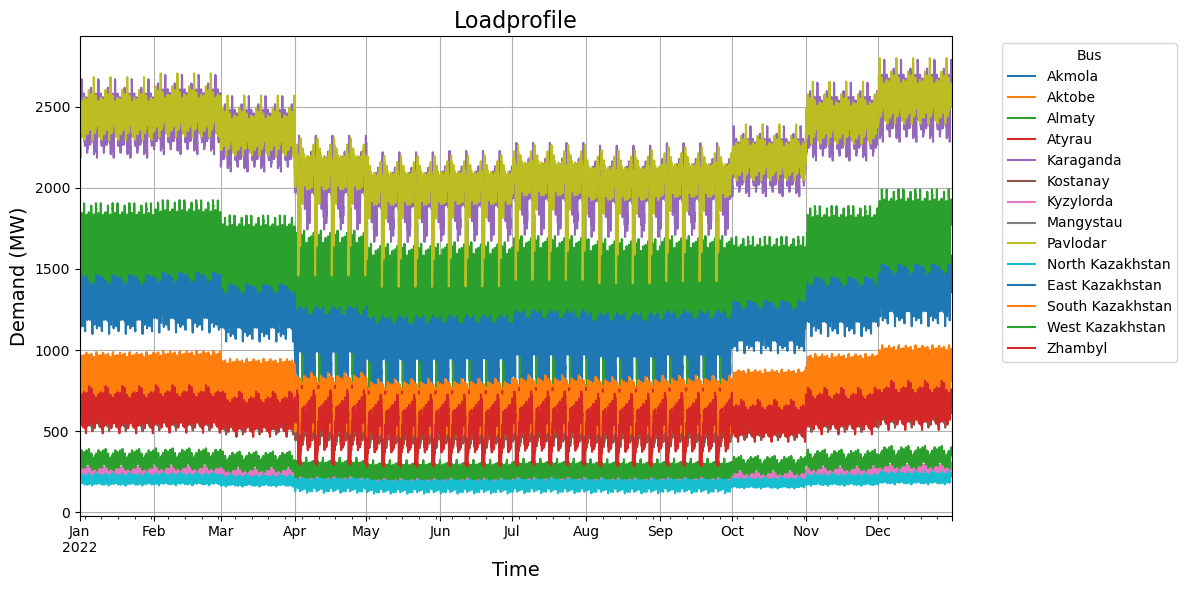

In [32]:
#loads plotten:
fig, ax = plt.subplots(figsize=(12, 6))
n.loads_t.p_set.plot(ax=ax, ylabel="MW")
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Demand (MW)', fontsize=14)
ax.set_title('Loadprofile', fontsize=16)
ax.grid(True)
ax.legend(title='Bus', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

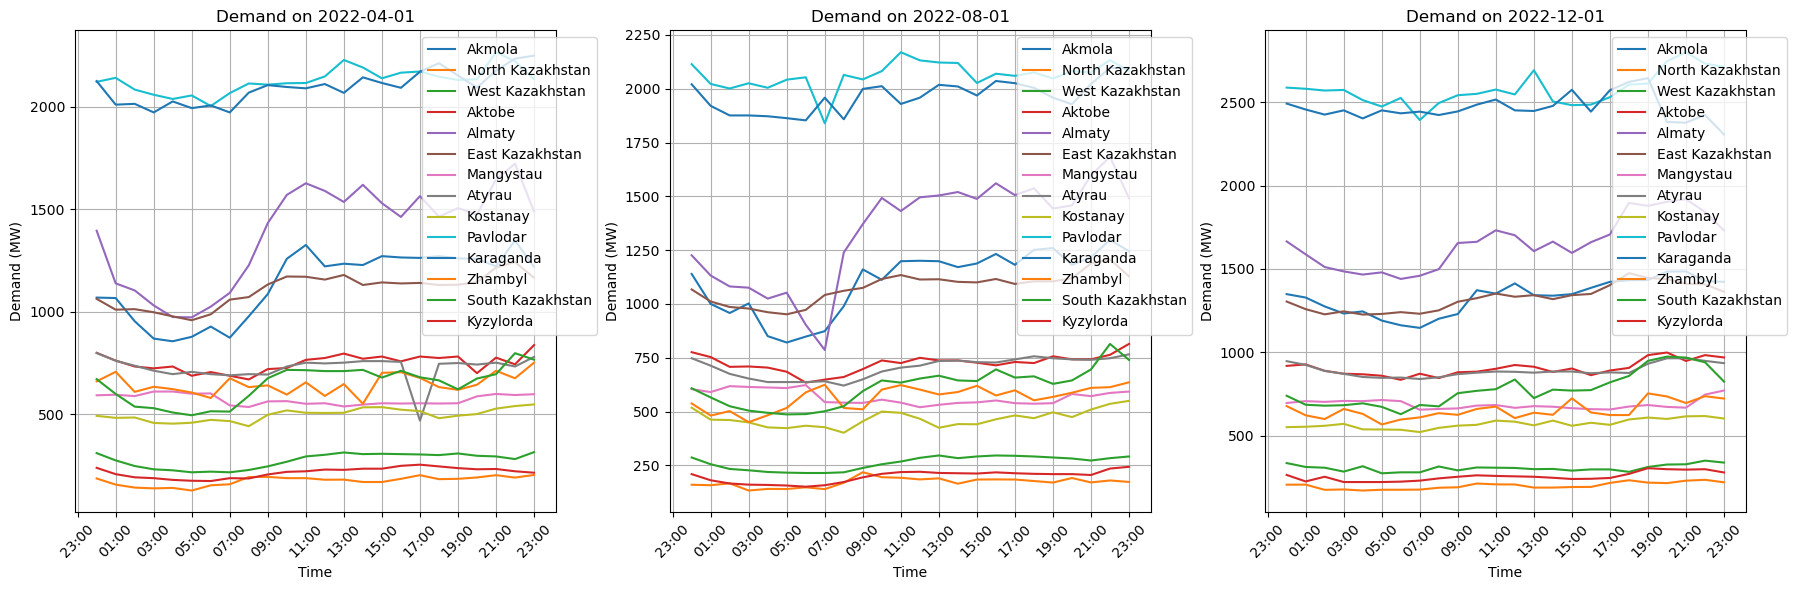

In [33]:
# Überprüfung drei repräsentativer Tage über das Netzwerk, um zu schauen ob alles korrekt eingelesen wurde.
dates = [test_apr, test_aug, test_dez]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # 1 Zeile, 3 Spalten
for col, date in enumerate(dates):
    day_data_load = loads_df[loads_df.index.date == pd.to_datetime(date).date()]
    for bus in loads_df.columns:
        axes[col].plot(day_data_load.index, day_data_load[bus], label=bus)
    axes[col].set_title(f'Demand on {date}')
    axes[col].set_xlabel('Time')
    axes[col].set_ylabel('Demand (MW)')
    axes[col].legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    axes[col].grid(True)
    axes[col].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    axes[col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(axes[col].xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

<a id="044-Add-Carriers"></a>
#### 04.4 Add Carriers

In [34]:
carriers = {
    "coal": {"emissions": costs_data.at["coal", "CO2 intensity"], "color": "saddlebrown"},
    "OCGT": {"emissions": costs_data.at["gas", "CO2 intensity"], "color": "lightcoral"},
    "CCGT": {"emissions": costs_data.at["gas", "CO2 intensity"], "color": "indianred"},
    "hydro": {"emissions": 0, "color": "blue"},
    "onwind": {"emissions": 0, "color": "green"},
    "solar": {"emissions": 0, "color": "yellow"},
    "hydrogen storage underground": {"emissions": 0, "color": "aquamarine"},
    "battery storage": {"emissions": 0, "color": "magenta"},
    "import": {"emissions": 0, "color": "grey"},
    "export": {"emissions": 0, "color": "darkgrey"},
}

for carrier_name, props in carriers.items():
    n.add("Carrier", 
          name=carrier_name,
          co2_emissions=props["emissions"],
          color=props["color"])

In [35]:
print(n.generators.carrier.unique())

[]


<a id="045-Add-Generators"></a>
#### 04.5 Add Generators

In [36]:
#hydroprofile['availability']

In [37]:
# Add Generators and assign Time series for renewables
hydroprofile.index = pd.to_datetime(hydroprofile.index)
# Ensure all generators are added
for idx, row in generators_df.iterrows():
    tech = row['Fueltype']
    region = row['Region']
    DateIn = row['DateIn']
    generator_name = f"{region}_{tech}_{idx}"  # Unique name for each generator
    p_nom = row['Capacity']  # Nominal capacity of the generator in MW
    n.add(
        "Generator",
        name=generator_name,
        bus=region,
        carrier=tech,
        capital_cost=costs_data.at["OCGT", "capital_cost"] if tech == "gas" else costs_data.at[tech, "capital_cost"],
        marginal_cost=costs_data.at[tech, "marginal_cost"],
        efficiency=costs_data.at[tech, "efficiency"],
        p_nom=p_nom,
        build_year=DateIn
    )
    # Assigning time series for Wind and PV to respective Generators (carrier = onwind/solar)
    if tech == "onwind":
        if region in all_profiles.columns:
            # Normalize the wind data to per-unit values
            normalized_profile = all_profiles[region]
            n.generators_t.p_max_pu.loc[:, generator_name] = normalized_profile
        else:
            print(f"Warning: No wind data available for region {region}.")
    elif tech == "solar":
        if region in all_profiles_pv.columns:
            # Normalize the PV data to per-unit values
            normalized_profile = all_profiles_pv[region]
            n.generators_t.p_max_pu.loc[:, generator_name] = normalized_profile
        else:
            print(f"Warning: No PV data available for region {region}.")
    elif tech == "hydro":
        # Ensure hydro profile index matches the network snapshots index
        hydro_profile_aligned = hydroprofile['availability'].reindex(n.snapshots, method='nearest')
        n.generators_t.p_max_pu.loc[:, generator_name] = hydro_profile_aligned

print("All generators have been added successfully.")

All generators have been added successfully.


In [38]:
# Anzeigen der Spaltennamen des DataFrames
print("Columns in the generators DataFrame:")
print(n.generators.columns)

# Überprüfen, welche der gewünschten Spalten im DataFrame vorhanden sind
available_columns = [col for col in ['p_nom', 'capital_cost', 'marginal_cost'] if col in n.generators.columns]

# Anzeigen der Werte der vorhandenen Spalten
print("Generator Details (p_nom, capital_cost, marginal_cost):")
print(n.generators[available_columns])


Columns in the generators DataFrame:
Index(['bus', 'control', 'type', 'p_nom', 'p_nom_mod', 'p_nom_extendable',
       'p_nom_min', 'p_nom_max', 'p_min_pu', 'p_max_pu', 'p_set', 'q_set',
       'sign', 'carrier', 'marginal_cost', 'marginal_cost_quadratic',
       'build_year', 'lifetime', 'capital_cost', 'efficiency', 'committable',
       'start_up_cost', 'shut_down_cost', 'stand_by_cost', 'min_up_time',
       'min_down_time', 'up_time_before', 'down_time_before', 'ramp_limit_up',
       'ramp_limit_down', 'ramp_limit_start_up', 'ramp_limit_shut_down',
       'weight', 'p_nom_opt'],
      dtype='object', name='attribute')
Generator Details (p_nom, capital_cost, marginal_cost):
attribute                   p_nom   capital_cost  marginal_cost
Generator                                                      
Akmola_coal_0                22.0  337208.027448      32.213321
Akmola_coal_1               360.0  337208.027448      32.213321
Akmola_coal_2               180.0  337208.027448      32

In [39]:
#generators = n.generators
#pd.set_option('display.max_columns', None)
# Filter für OCGT und CCGT Generatoren
#ocgt_ccgt_generators = generators[(generators['carrier'] == 'OCGT') | (generators['carrier'] == 'CCGT')]

# Ausgabe der gefilterten Generatoren
#print(ocgt_ccgt_generators)

In [40]:
onwind_columns = [col for col in n.generators_t.p_max_pu.columns if 'onwind' in col]
onwind_availability = n.generators_t.p_max_pu[onwind_columns].mean(axis=1)
print(onwind_availability)

snapshot
2022-01-01 00:00:00    0.456937
2022-01-01 01:00:00    0.451500
2022-01-01 02:00:00    0.470187
2022-01-01 03:00:00    0.489500
2022-01-01 04:00:00    0.528563
                         ...   
2022-12-31 19:00:00    0.534438
2022-12-31 20:00:00    0.514750
2022-12-31 21:00:00    0.507500
2022-12-31 22:00:00    0.491375
2022-12-31 23:00:00    0.474375
Freq: H, Length: 8760, dtype: float64


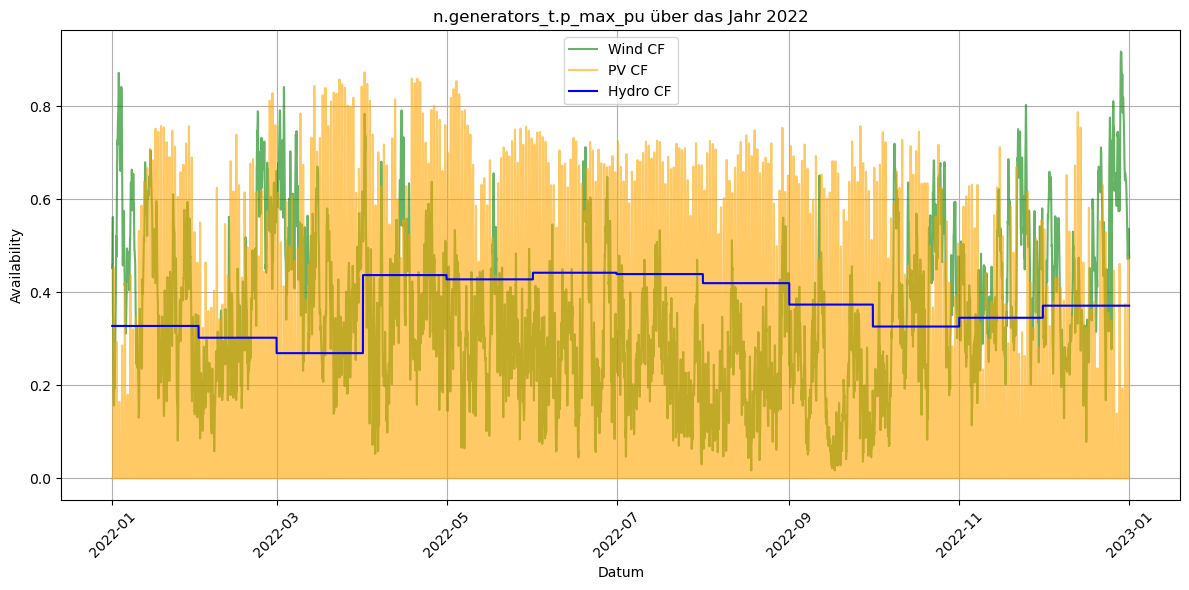

In [41]:
# Alle Spalten finden, die zu 'onwind', 'solar' oder 'hydro' gehören
onwind_columns = [col for col in n.generators_t.p_max_pu.columns if 'onwind' in col]
solar_columns = [col for col in n.generators_t.p_max_pu.columns if 'solar' in col]
hydro_columns = [col for col in n.generators_t.p_max_pu.columns if 'hydro' in col]

# Durchschnittliche Availability für 'onwind', 'solar' und 'hydro' berechnen
onwind_availability = n.generators_t.p_max_pu[onwind_columns].mean(axis=1)
solar_availability = n.generators_t.p_max_pu[solar_columns].mean(axis=1)
hydro_availability = n.generators_t.p_max_pu[hydro_columns].mean(axis=1)
#print(hydro_availability)
# Profile über das gesamte Jahr plotten
plt.figure(figsize=(12, 6))  # Größe des Plots anpassen
plt.plot(onwind_availability.index, onwind_availability, label='Wind CF', color='green', alpha=0.6)
plt.plot(solar_availability.index, solar_availability, label='PV CF', color='orange', alpha=0.6)
plt.plot(hydro_availability.index, hydro_availability, label='Hydro CF', color='blue')
plt.legend()
titlecf = f'n.generators_t.p_max_pu über das Jahr {start_year}'
plt.title(titlecf)
plt.xlabel('Datum')
plt.ylabel('Availability')
plt.xticks(rotation=45)  # Dreht die X-Achsen-Beschriftungen um 45 Grad
plt.grid(True)  # Fügt ein Gitter hinzu, um die Lesbarkeit zu verbessern
plt.tight_layout()  # Verbessert die Anordnung im Plot
plt.show()

In [42]:
print(n.generators[["carrier", "capital_cost",'lifetime']])

attribute                  carrier   capital_cost  lifetime
Generator                                                  
Akmola_coal_0                 coal  337208.027448       inf
Akmola_coal_1                 coal  337208.027448       inf
Akmola_coal_2                 coal  337208.027448       inf
Aktobe_CCGT_3                 CCGT  110915.226329       inf
Aktobe_OCGT_4                 OCGT   49760.036522       inf
...                            ...            ...       ...
Akmola_onwind_139           onwind  113584.192786       inf
East Kazakhstan_onwind_140  onwind  113584.192786       inf
South Kazakhstan_solar_141   solar   75323.802088       inf
South Kazakhstan_solar_142   solar   75323.802088       inf
Mangystau_OCGT_143            OCGT   49760.036522       inf

[144 rows x 3 columns]


<a id="046-Add-LinksLines"></a>
#### 04.6 Add Links/Lines

In [43]:
# Links zum Netzwerk hinzufügen
# Generische Links ohne jegliche Spezifika und mit extendable=true
# GGf Marginal Cost hinzufügen
for idx, row in links_df.iterrows():
    link_name = f"link_{row['bus0']}_{row['bus1']}"
    n.add(
        "Link",
        link_name,
        bus0=row['bus0'],
        bus1=row['bus1'],
        p_min_pu = -1, # important, otherwise links will be unidirectional
        p_nom_extendable=True,  # Annahme: Link-Kapazitäten sind erweiterbar
    )
#print(n.links)

<a id="0462-Model-Imports-and-Exports"></a>
#### 04.6.2 Model Imports and Exports

# Dummy Busse für Import einfügen
import_dummys = ['RU', 'UZ', 'KY']
for dummy in import_dummys:
    n.add("Bus", name=dummy, v_nom=500)
# Import/Export Links hinzufügen
importlink_df = pd.read_excel(r"C:\Users\jan.carsten\Python Programmieren\04 Multi Node Network\links_import.xlsx")
for importlink, row in importlink_df.iterrows():
    # Import Link hinzufügen
    n.add(
        "Link",
        name=f"Importlink_{row['bus0']}_to_{row['bus1']}",
        bus0=row['bus0'],
        bus1=row['bus1'],
        carrier="import",
        p_nom_extendable=True,
    )
    # Export Link hinzufügen (mit umgekehrten Bussen)
    n.add(
        "Link",
        name=f"Exportlink_{row['bus1']}_to_{row['bus0']}",
        bus0=row['bus1'],
        bus1=row['bus0'],
        carrier="export",
        p_nom_extendable=True,
        marginal_cost = n.generators.marginal_cost.max()*1.2  # 20% teurer als 1 MWh aus teuerstes Kraftwerk, damit Export unattraktiv ist
    )
# Import-Generatoren hinzufügen
#max_marginal_cost = marginal_costs.max()
#print(f"The maximum marginal cost in the network is: {max_marginal_cost}")

marginal_cost_import = n.generators.marginal_cost.max()*1.4  # 40% teurer als teuerstes Kraftwerk, damit Import unattraktiv ist
for _, row in importlink_df.iterrows():
    n.add(
        "Generator",
        name=f"Import_Generator_{row['bus1']}",
        bus=row['bus1'],
        carrier="import",
        p_nom_extendable=True,
        marginal_cost=marginal_cost_import
    )

In [44]:
print(n.generators[['build_year', 'lifetime']])

attribute                   build_year  lifetime
Generator                                       
Akmola_coal_0                     1961       inf
Akmola_coal_1                     1979       inf
Akmola_coal_2                     1966       inf
Aktobe_CCGT_3                     1962       inf
Aktobe_OCGT_4                     1996       inf
...                                ...       ...
Akmola_onwind_139                 2020       inf
East Kazakhstan_onwind_140        2022       inf
South Kazakhstan_solar_141        2019       inf
South Kazakhstan_solar_142        2022       inf
Mangystau_OCGT_143                2021       inf

[144 rows x 2 columns]


<a id="0470-Debugging"></a>
## 04.70 Debugging

In [45]:
print(n.loads_t.p_set.sum(axis=1).max())  # Maximale Last in allen Zeitpunkten
print(n.generators.p_nom.sum())  # Gesamt installierte Kapazität der Generatoren

16303.8847484426
22268.89


In [46]:
# Optimieren mit DualReductions=0 für Unterscheidung Infeasible/Unbounded
#solver_options = {
#    'threads': 4,  # Passe die Anzahl der Threads nach Bedarf an
#    'DualReductions': 0}

#n.optimize(solver_name='gurobi', solver_options=solver_options)

In [47]:
# Manuelles Debuggen mit Linopy-Methode
#m = n.model
#print(m.type)
#m.solve(solver_name='gurobi')
#labels = m.compute_infeasibilities()
#labels
#m.constraints.print_labels(labels)
# oder einfach als direkten Aufruf:
#m.print_infeasibilities()

In [48]:
# Ergebnis Debugging
# Leider immernoch Probleme bei der ersten Nodal Balance im ersten Zeitschritt
# Liegt es an unidirektionalen Links? Ja lol

<a id="05-Optimize-Network"></a>
### 05 Optimize Network

In [49]:
# Problem: AGORA Demand ist ca 105,722 TWh, Mein 2022er Demand ist 112,944 TWh
solver_options = {
    'Threads': 4,  # Anzahl der Threads anpassen
    'NodefileStart': 0.5,  # Startet das Schreiben auf die Festplatte, wenn 50% des Speichers verwendet wird
    #'MIPFocus': 1  # Setzt den Fokus auf die Lösungsqualität
}
n.optimize(solver_name='gurobi',solver_options=solver_options)

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Threads: 4
 - NodefileStart: 0.5


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-02-15


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-02-15
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]
INFO:linopy.io: Writing time: 16.37s


Read LP format model from file C:\Users\jan.carsten\AppData\Local\Temp\linopy-problem-vcqk6fck.lp


INFO:gurobipy:Read LP format model from file C:\Users\jan.carsten\AppData\Local\Temp\linopy-problem-vcqk6fck.lp


Reading time = 4.72 seconds


INFO:gurobipy:Reading time = 4.72 seconds


obj: 2890814 rows, 1384094 columns, 4520174 nonzeros


INFO:gurobipy:obj: 2890814 rows, 1384094 columns, 4520174 nonzeros


Set parameter Threads to value 4


INFO:gurobipy:Set parameter Threads to value 4


Set parameter NodefileStart to value 0.5


INFO:gurobipy:Set parameter NodefileStart to value 0.5


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 5625U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 5625U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 4 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 4 threads


INFO:gurobipy:


Optimize a model with 2890814 rows, 1384094 columns and 4520174 nonzeros


INFO:gurobipy:Optimize a model with 2890814 rows, 1384094 columns and 4520174 nonzeros


Model fingerprint: 0x3ff3e1ea


INFO:gurobipy:Model fingerprint: 0x3ff3e1ea


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [1e-02, 7e+01]


INFO:gurobipy:  Objective range  [1e-02, 7e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e-04, 4e+03]


INFO:gurobipy:  RHS range        [4e-04, 4e+03]


Presolve removed 2890790 rows and 1384022 columns


INFO:gurobipy:Presolve removed 2890790 rows and 1384022 columns


Presolve time: 2.34s


INFO:gurobipy:Presolve time: 2.34s


Presolved: 24 rows, 72 columns, 72 nonzeros


INFO:gurobipy:Presolved: 24 rows, 72 columns, 72 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.4842153e+09   2.693242e+02   0.000000e+00      2s


INFO:gurobipy:       0    3.4842153e+09   2.693242e+02   0.000000e+00      2s


Extra simplex iterations after uncrush: 17520


INFO:gurobipy:Extra simplex iterations after uncrush: 17520


   17544    3.4842504e+09   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:   17544    3.4842504e+09   0.000000e+00   0.000000e+00      4s


INFO:gurobipy:


Solved in 17544 iterations and 3.65 seconds (4.50 work units)


INFO:gurobipy:Solved in 17544 iterations and 3.65 seconds (4.50 work units)


Optimal objective  3.484250410e+09


INFO:gurobipy:Optimal objective  3.484250410e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1384094 primals, 2890814 duals
Objective: 3.48e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


('ok', 'optimal')

<a id="050-Network-Inspection-Current-Situation"></a>
#### 05.0 Network Inspection: Current Situation

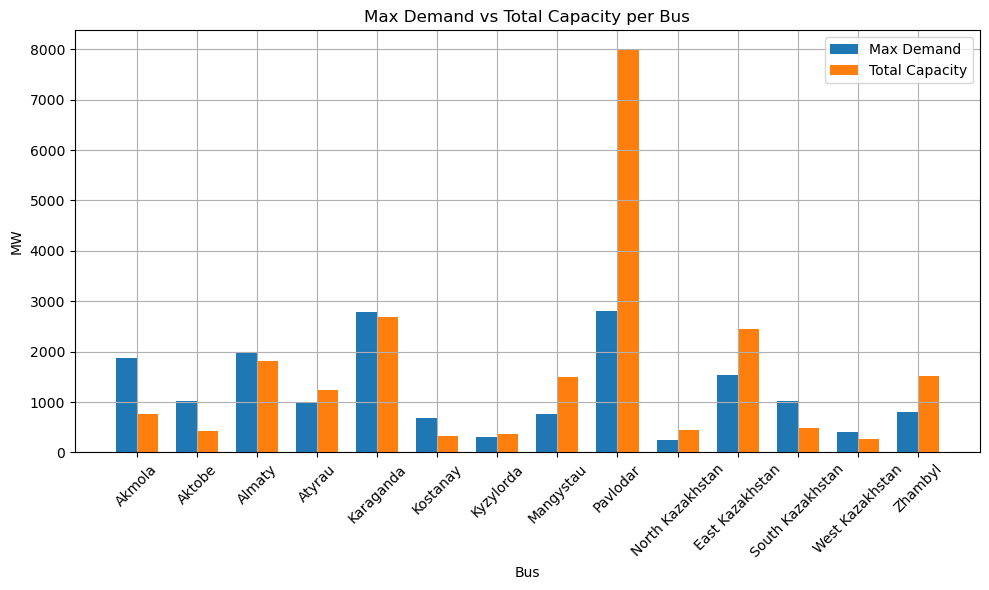

In [50]:
# Berechnung der maximalen stündlichen Lastspitze pro Bus
max_demand_per_bus = n.loads_t.p_set.max()
max_demand_per_bus.name = "Max Demand"
# Berechnung der gesamten verfügbaren Kapazität pro Bus
total_capacity_per_bus = n.generators.groupby('bus').p_nom.sum()
total_capacity_per_bus.name = "Total Capacity"
# Zusammenführen der Daten in einem DataFrame
capacity_vs_demand = pd.concat([max_demand_per_bus, total_capacity_per_bus], axis=1).fillna(0)
# Plotting
fig, ax = plt.subplots(figsize=(10,6))
# Bar Width
bar_width = 0.35
# Bar positions
bar_positions = np.arange(len(capacity_vs_demand))
# Plot bars
bar1 = ax.bar(bar_positions - bar_width/2, capacity_vs_demand["Max Demand"], bar_width, label='Max Demand')
bar2 = ax.bar(bar_positions + bar_width/2, capacity_vs_demand["Total Capacity"], bar_width, label='Total Capacity')
# Adding labels and title
ax.set_xlabel('Bus')
ax.set_ylabel('MW')
ax.set_title('Max Demand vs Total Capacity per Bus')
ax.set_xticks(bar_positions)
ax.set_xticklabels(capacity_vs_demand.index, rotation=45)
ax.legend()
# Adding grid for better readability
ax.grid(True)
# Display the plot
plt.tight_layout()
plt.show()

In [51]:
#Gesamtkosten der Optimierung (Objective Value) in Euro
print("Gesamtkosten der Optimierung (Objective Value) in Euro:")
print(f"{n.objective:,.2f} €")

Gesamtkosten der Optimierung (Objective Value) in Euro:
3,484,250,409.86 €


<a id="051-Model-Evaluation-Functions-for-Inspection-and-Plotting"></a>
### 05.1 Model Evaluation: Functions for Inspection and Plotting

<a id="0511-Capacities-Dispatch-Utilization"></a>
#### 05.1.1 Capacities Dispatch Utilization

In [52]:
print(n.generators.carrier.unique())

['coal' 'CCGT' 'OCGT' 'hydro' 'onwind' 'solar']


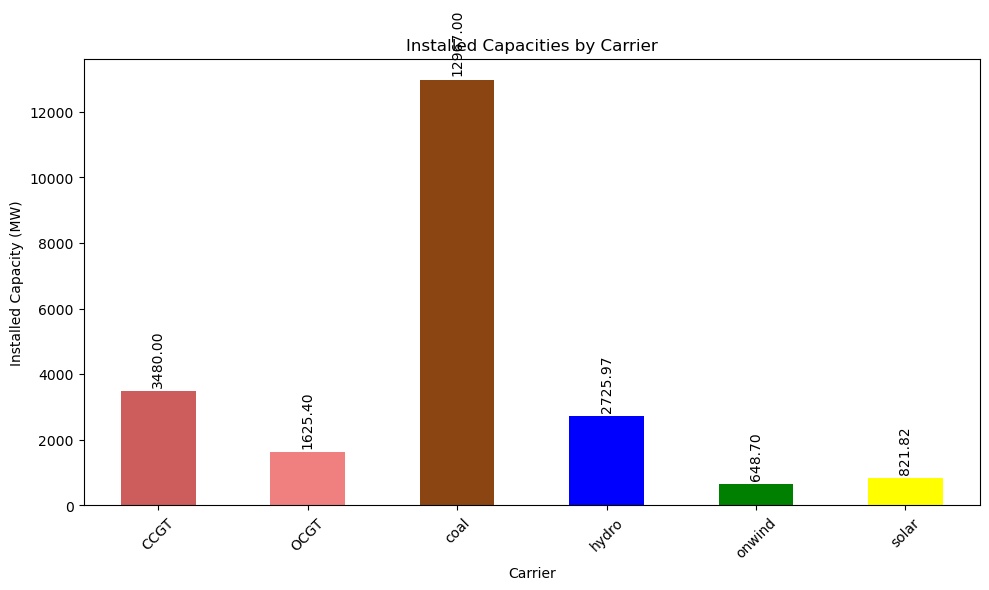

In [53]:
def plot_installed_capacities(n):
    capacities_by_carrier = n.generators.groupby('carrier').p_nom.sum()
    colors = n.carriers.loc[capacities_by_carrier.index, 'color']
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = capacities_by_carrier.plot(kind='bar', ax=ax, color=colors)
    ax.set_title('Installed Capacities by Carrier')
    ax.set_xlabel('Carrier')
    ax.set_ylabel('Installed Capacity (MW)')
    plt.xticks(rotation=45)
    for bar in bars.patches:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', color='black', rotation=90)
    plt.tight_layout()
    plt.show()
plot_installed_capacities(n)

In [54]:
def renewable_shares(n):
    renewable_carriers = ['onwind', 'solar', 'hydro']
    total_capacity = n.generators.p_nom.sum()
    total_generation = (n.snapshot_weightings.generators @ n.generators_t.p).sum()
    renewable_capacity = n.generators[n.generators.carrier.isin(renewable_carriers)].p_nom.sum()
    renewable_generators = n.generators[n.generators.carrier.isin(renewable_carriers)].index
    renewable_generation = (n.snapshot_weightings.generators @ n.generators_t.p[renewable_generators]).sum()
    capacity_share = renewable_capacity / total_capacity * 100
    generation_share = renewable_generation / total_generation * 100
    print(f"capacity share of renewables : {capacity_share} %")
    print(f"generation share of renewables: {generation_share} %")
    #return capacity_share, generation_share
renewable_shares(n)

capacity share of renewables : 18.84463033406695 %
generation share of renewables: 10.694271029950201 %


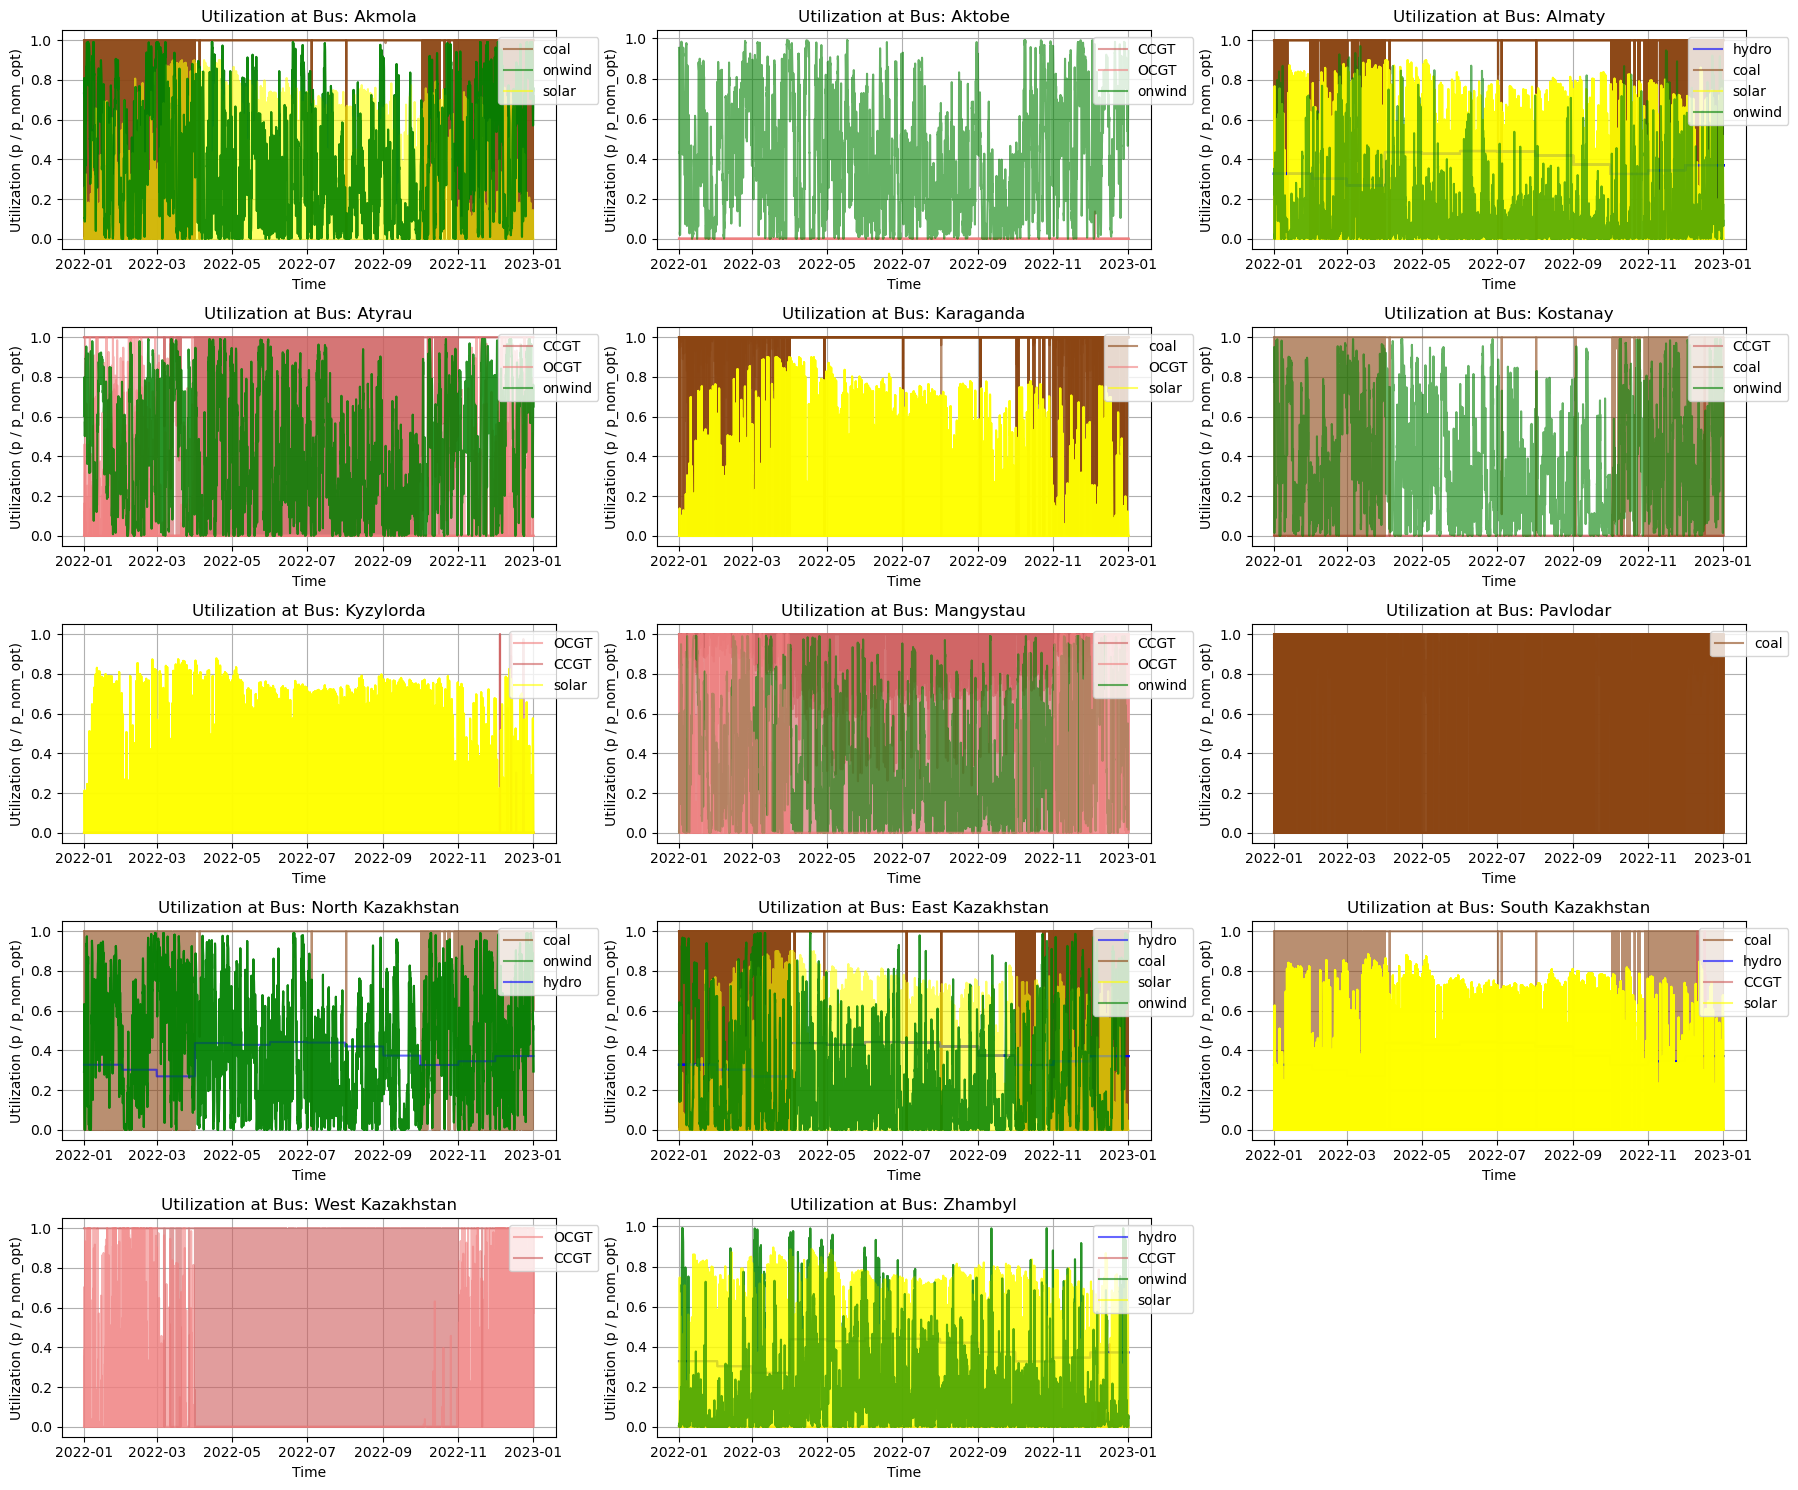

In [55]:
# Ganzjährige Betrachtung der Auslastung pro Bus, Bei leeren Bussen wird kein plot erstellt.
def plot_bus_utilization(n):
    buses = n.buses.index
    fig, axes = plt.subplots(nrows=(len(buses) // 3) + (len(buses) % 3 > 0), ncols=3, figsize=(18, 3 * ((len(buses) // 3) + (len(buses) % 3 > 0))))
    axes = axes.flatten()
    for i, bus in enumerate(buses):
        ax = axes[i]
        generators_at_bus = n.generators[n.generators['bus'] == bus]
        carriers_plotted = set()
        for idx, row in generators_at_bus.iterrows():
            carrier = row['carrier']
            color = n.carriers.loc[carrier, 'color']
            capacity = n.generators.at[idx, 'p_nom_opt'] if 'p_nom_opt' in n.generators.columns else n.generators.at[idx, 'p_nom']
            utilization = n.generators_t.p[idx] / capacity
            ax.plot(utilization.index, utilization, label=f'{carrier}', color=color, alpha=0.6)
            carriers_plotted.add(carrier)
        ax.set_title(f'Utilization at Bus: {bus}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Utilization (p / p_nom_opt)')
        
        # Erstellen einer benutzerdefinierten Legende ohne doppelte Einträge
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper right', bbox_to_anchor=(1.1, 1))
        
        ax.grid(True)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

plot_bus_utilization(n)

In [157]:
def plot_dispatch_no_storage(n, time=None):
    if time is None:
        time = n.snapshots  # Set to the entire range of snapshots if no specific time range is provided
    p_by_carrier = n.generators_t.p.T.groupby(n.generators.carrier).sum().T.div(1e3)
    variability = p_by_carrier.std()
    p_by_carrier = p_by_carrier[variability.sort_values().index]
    fig, ax = plt.subplots(figsize=(12, 8))  # Größeren Plot für bessere Sichtbarkeit
    colors = n.carriers.color.reindex(p_by_carrier.columns)
    p_by_carrier.where(p_by_carrier > 0).loc[time].plot.area(
        ax=ax,
        linewidth=0,
        color=colors,
        alpha=0.6  # Leichte Transparenz für bessere Sichtbarkeit
    )
    n.loads_t.p_set.sum(axis=1).loc[time].div(1e3).plot(ax=ax, c="k", label='Demand', alpha=0.6)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))
    title_dispatch = f'Generator Dispatch {start_year} for baseline scenario'
    ax.set_title(title_dispatch)
    ax.set_xlabel('Time')
    ax.set_ylabel('GW')
    plt.xticks(rotation=45)  # Dreht die X-Achsen-Beschriftungen um 45 Grad
    plt.grid(False)  # Fügt ein Gitter hinzu, um die Lesbarkeit zu verbessern
    plt.tight_layout()  # Verbessert die Anordnung im Plot
    plt.show()

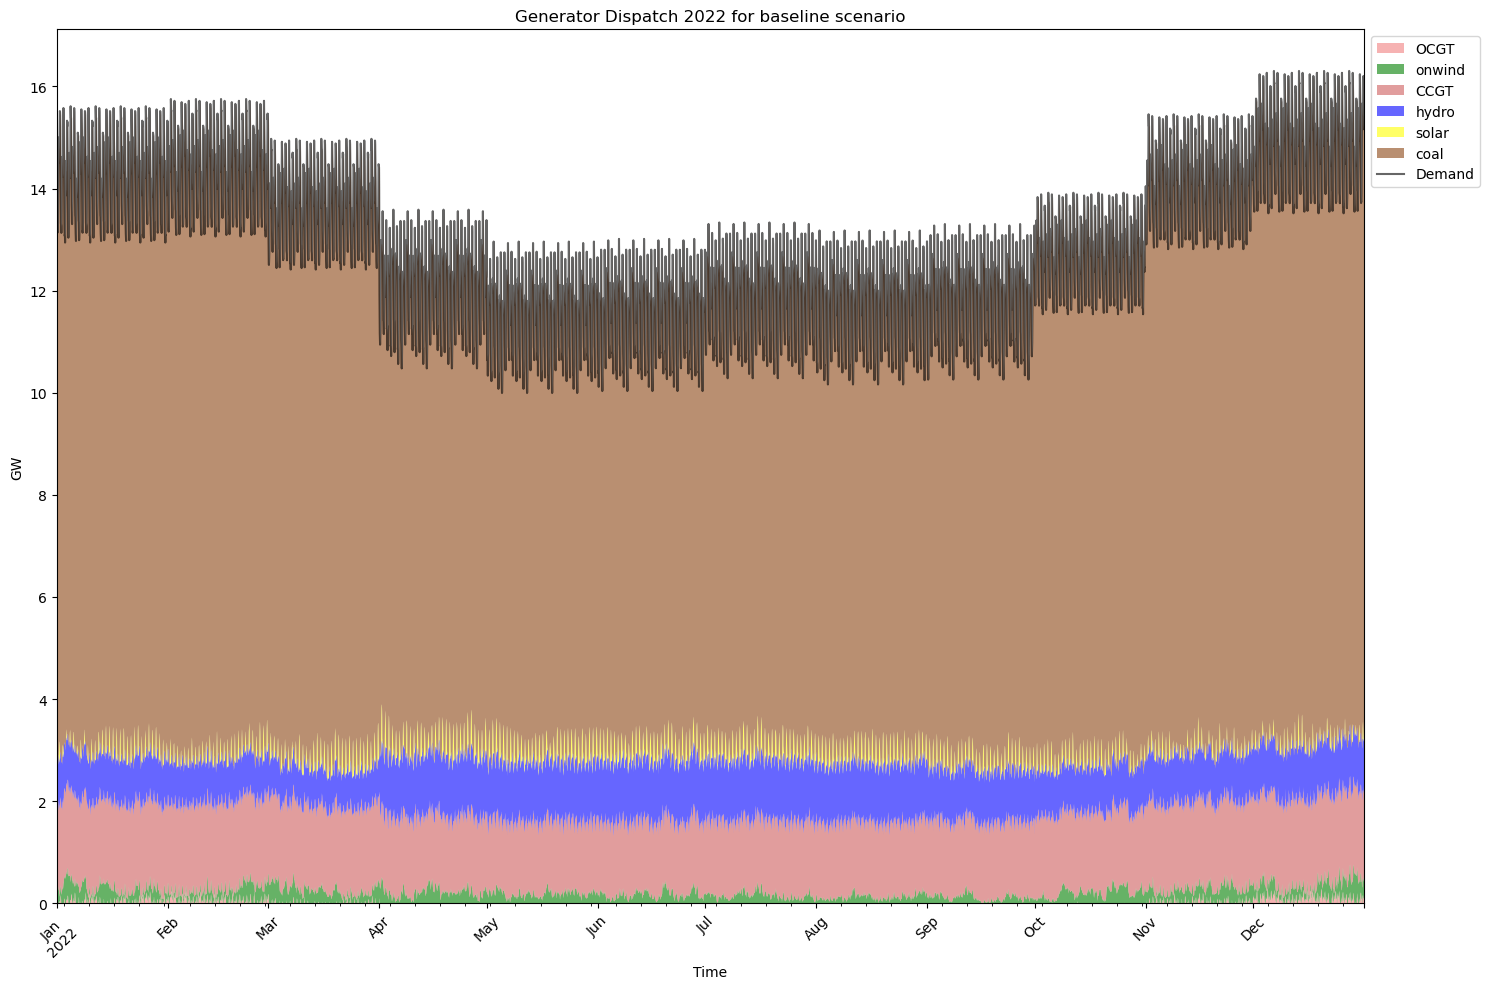

In [57]:
plot_dispatch_no_storage(n) # reihenfolge der Anzeige anpassen

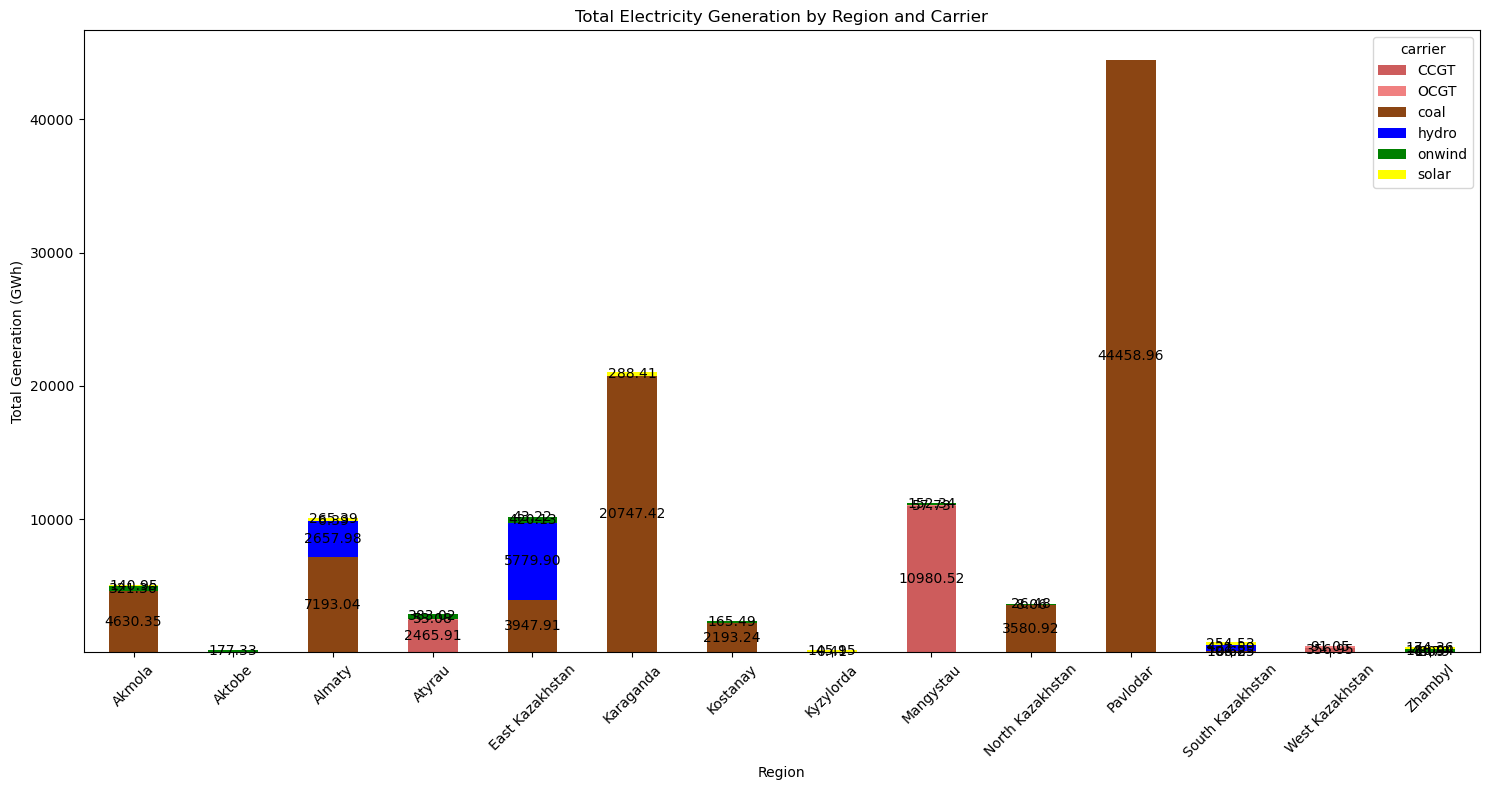

In [58]:
def plot_total_generation_by_region_and_carrier(n):
    # Berechnung der insgesamt erzeugten Energie für jeden Generator (in MWh)
    total_generation = n.generators_t.p.sum(axis=0)  # Summe über alle Zeitschritte
    total_generation_by_generator = total_generation.div(1e3)  # In GWh umrechnen
    # Hinzufügen der Region und Carrier-Informationen
    n.generators['total_generation'] = total_generation_by_generator
    generation_by_region_and_carrier = n.generators.groupby(['bus', 'carrier'])['total_generation'].sum().unstack()
    # Farben für die Carrier
    colors = {carrier: n.carriers.loc[carrier, 'color'] for carrier in n.carriers.index}
    # Plot erstellen
    ax = generation_by_region_and_carrier.plot(kind='bar', stacked=True, figsize=(15, 8), color=[colors[carrier] for carrier in generation_by_region_and_carrier.columns])
    ax.set_title('Total Electricity Generation by Region and Carrier')
    ax.set_xlabel('Region')
    ax.set_ylabel('Total Generation (GWh)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Bar labels hinzufügen
    for container in ax.containers:
        labels = [f'{v:.2f}' if v > 0 else '' for v in container.datavalues]
        ax.bar_label(container, labels=labels, label_type='center')
    plt.show()
plot_total_generation_by_region_and_carrier(n)

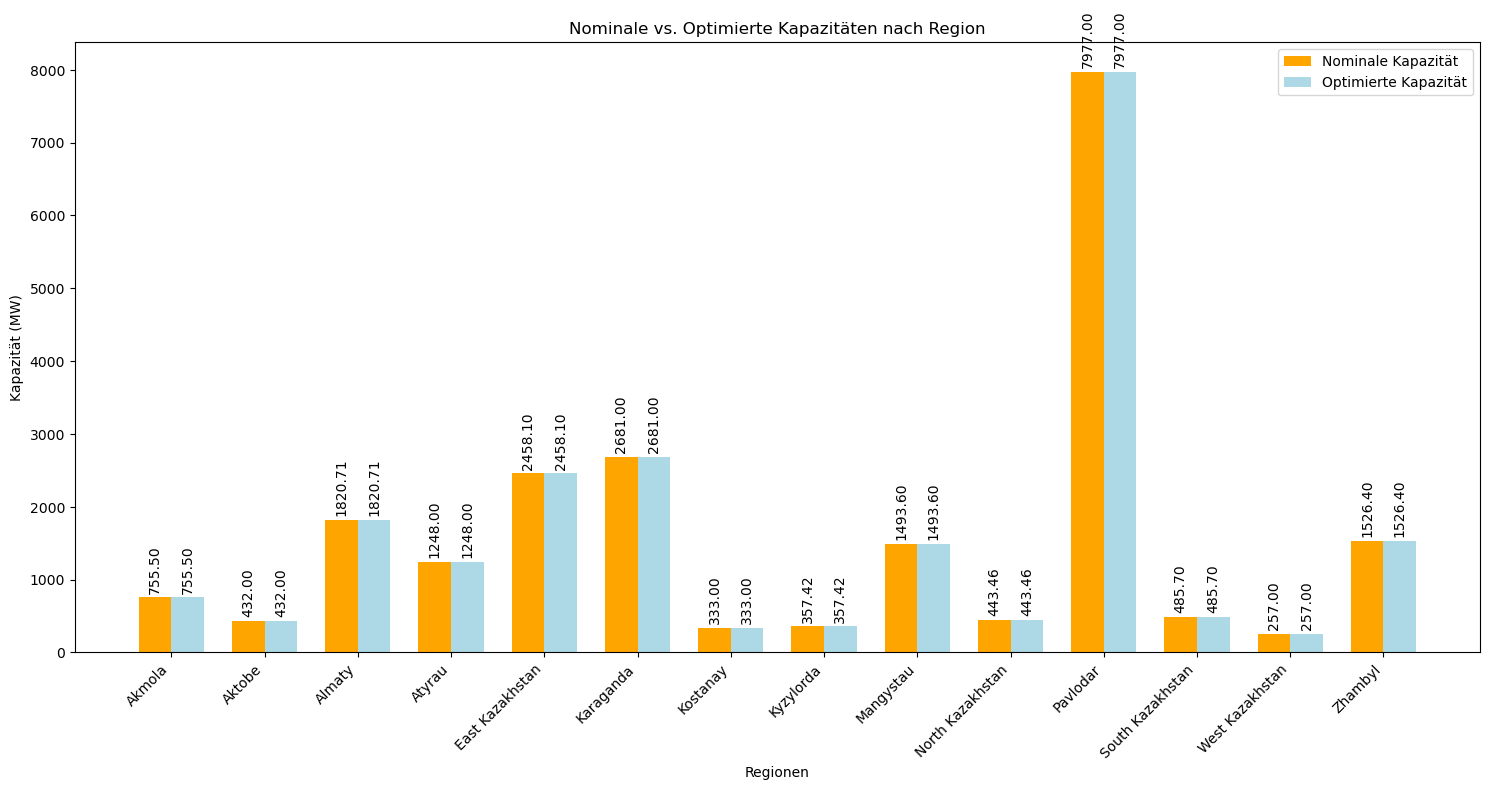

In [59]:
def plot_nominal_vs_optimized_kapa(n):
    # Nominale und optimierte Kapazitäten aggregieren nach Region
    generation_by_region_nom = n.generators.groupby('bus')['p_nom'].sum()
    generation_by_region_opt = n.generators.groupby('bus')['p_nom_opt'].sum()
    fig, ax = plt.subplots(figsize=(15, 8))
    index = np.arange(len(generation_by_region_nom))
    bar_width = 0.35
    bars1 = ax.bar(index, generation_by_region_nom, bar_width, label='Nominale Kapazität', color='orange')
    bars2 = ax.bar(index + bar_width, generation_by_region_opt, bar_width, label='Optimierte Kapazität', color='lightblue')
    ax.set_xlabel('Regionen')
    ax.set_ylabel('Kapazität (MW)')
    ax.set_title('Nominale vs. Optimierte Kapazitäten nach Region')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(generation_by_region_nom.index, rotation=45, ha='right')
    ax.legend()
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom',
                            rotation=90)  # Rotate the text

    plt.tight_layout()
    plt.show()
# Beispielaufruf
plot_nominal_vs_optimized_kapa(n)

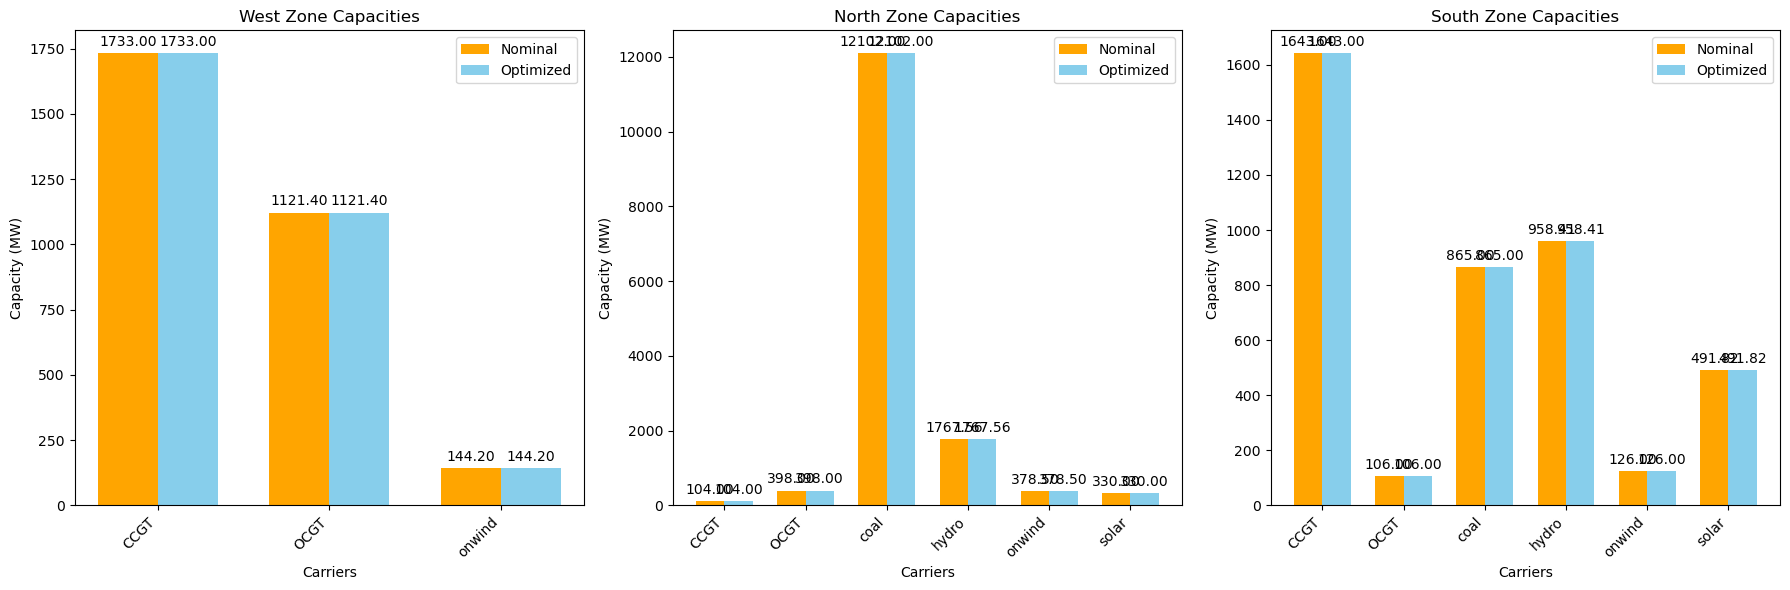

In [60]:
#Plot für Nominale vs Optimierte Kapazitäten nach Zone und Carrier
zones = {    "West Zone": ["West Kazakhstan", "Atyrau", "Mangystau"],
    "North Zone": ["Aktobe", "Akmola", "Karaganda", "Kostanay", "Pavlodar", "North Kazakhstan", "East Kazakhstan"],
    "South Zone": ["Almaty", "Kyzylorda", "South Kazakhstan", "Zhambyl"]
}
#['Kyzylorda', 'North Kazakhstan', 'East Kazakhstan', 'South Kazakhstan', 'West Kazakhstan']
def plot_zone_capacities(n):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # 1 Zeile, 3 Spalten
    for ax, (zone, buses) in zip(axes, zones.items()):
        # Aggregieren der Kapazitäten pro Carrier
        carrier_capacity_nom = {}
        carrier_capacity_opt = {}
        for idx, row in n.generators.iterrows():
            if row['bus'] in buses:
                carrier = row['carrier']
                if carrier not in carrier_capacity_nom:
                    carrier_capacity_nom[carrier] = 0
                    carrier_capacity_opt[carrier] = 0
                carrier_capacity_nom[carrier] += n.generators.at[idx, 'p_nom']
                carrier_capacity_opt[carrier] += n.generators.at[idx, 'p_nom_opt']
        carriers = sorted(carrier_capacity_nom.keys())
        nom_values = [carrier_capacity_nom[carrier] for carrier in carriers]
        opt_values = [carrier_capacity_opt[carrier] for carrier in carriers]
        x = np.arange(len(carriers))
        bar_width = 0.35
        bars1 = ax.bar(x - bar_width / 2, nom_values, bar_width, label='Nominal', color='orange')
        bars2 = ax.bar(x + bar_width / 2, opt_values, bar_width, label='Optimized', color='skyblue')
        ax.set_xlabel('Carriers')
        ax.set_ylabel('Capacity (MW)')
        ax.set_title(f'{zone} Capacities')
        ax.set_xticks(x)
        ax.set_xticklabels(carriers, rotation=45, ha='right')
        ax.legend()
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
plot_zone_capacities(n)

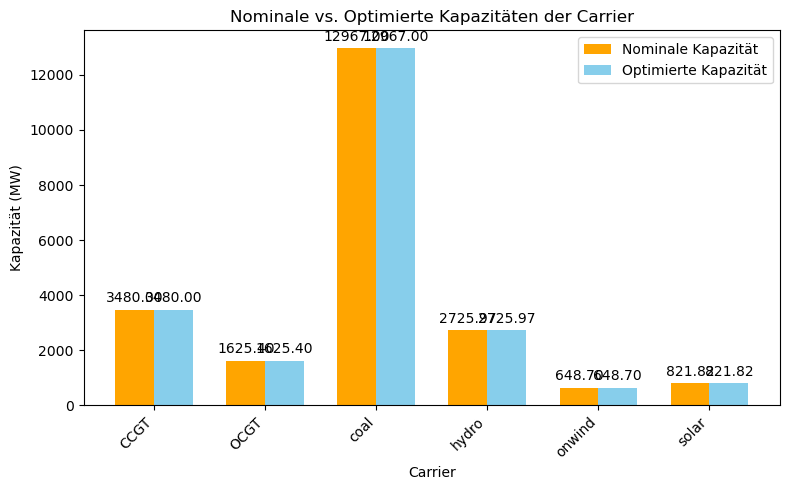

In [61]:
def plot_nominal_vs_optimized_kapa_aggregated(n):
    fig, ax = plt.subplots(figsize=(8, 5))
    # Aggregierte Kapazitäten pro Carrier berechnen
    p_nom = n.generators.groupby('carrier').p_nom.sum()
    p_nom_opt = n.generators.groupby('carrier').p_nom_opt.sum()
    index = np.arange(len(p_nom))
    bar_width = 0.35
    bars1 = ax.bar(index, p_nom, bar_width, label='Nominale Kapazität', color='orange')
    bars2 = ax.bar(index + bar_width, p_nom_opt, bar_width, label='Optimierte Kapazität', color='skyblue')
    ax.set_xlabel('Carrier')
    ax.set_ylabel('Kapazität (MW)')
    ax.set_title('Nominale vs. Optimierte Kapazitäten der Carrier')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(p_nom.index, rotation=45, ha='right')
    ax.legend()
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
plot_nominal_vs_optimized_kapa_aggregated(n)

In [62]:
#Abgeregelte Energie betrachten:
maximale_generation = (n.generators.p_nom * n.generators_t.p_max_pu).sum(axis=0)
actual_generation = n.generators_t.p.sum(axis=0)
curtailed_energy = maximale_generation - actual_generation
curtailed_energy = curtailed_energy.clip(lower=0)
print('Die Gesamtmenge abgeregelten Stroms beträgt :', curtailed_energy.sum(), 'MWh')
print('Das entspräche bei einem Wirkungsgrad von 60% einer erzeugten Wasserstoffmenge von', 0.6 * curtailed_energy.sum(), 'MWh')

Die Gesamtmenge abgeregelten Stroms beträgt : 3.737838596862275e-06 MWh
Das entspräche bei einem Wirkungsgrad von 60% einer erzeugten Wasserstoffmenge von 2.242703158117365e-06 MWh


<a id="0512-LinkLine-Inspection"></a>
#### 05.1.2 Link/Line Inspection

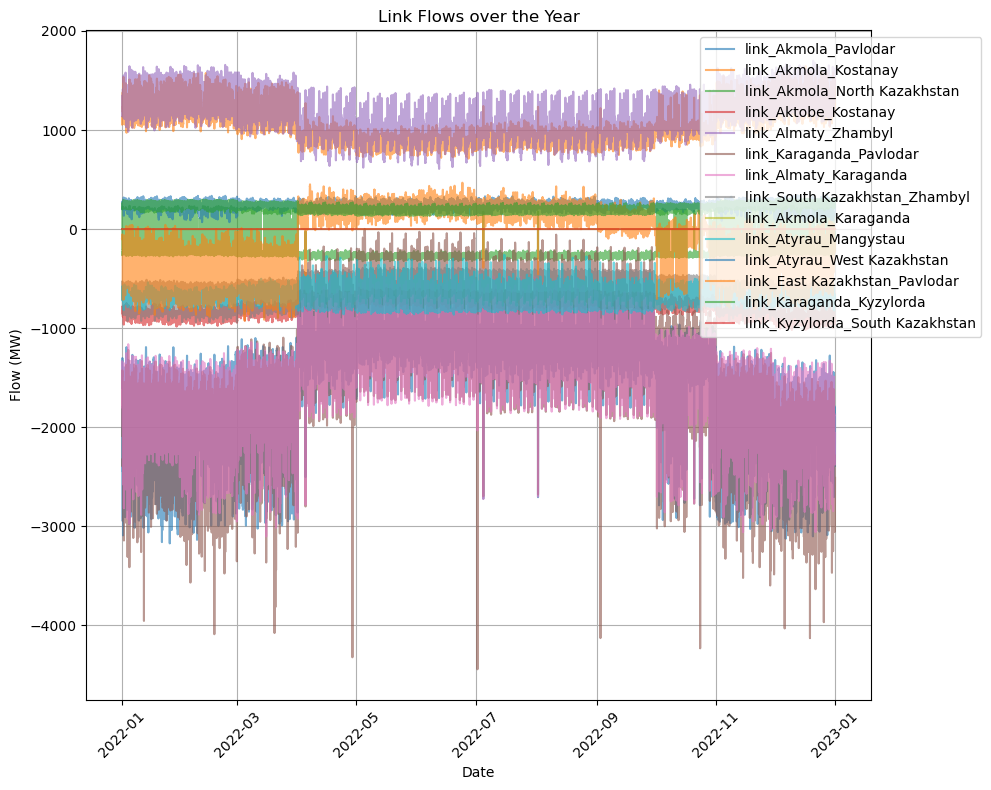

In [63]:
# Zeitvariable Link-Usage betrachten:
def plot_link_flows_over_year(n):
    fig, ax = plt.subplots(figsize=(10, 8))
    exclude_carriers = ['import', 'export']
    for link in n.links.index:
        if n.links.loc[link, 'carrier'] not in exclude_carriers:
            ax.plot(n.links_t.p0.index, n.links_t.p0[link], label=f'{link}', alpha=0.6)
    ax.set_title('Link Flows over the Year')
    ax.set_xlabel('Date')
    ax.set_ylabel('Flow (MW)')
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_link_flows_over_year(n)

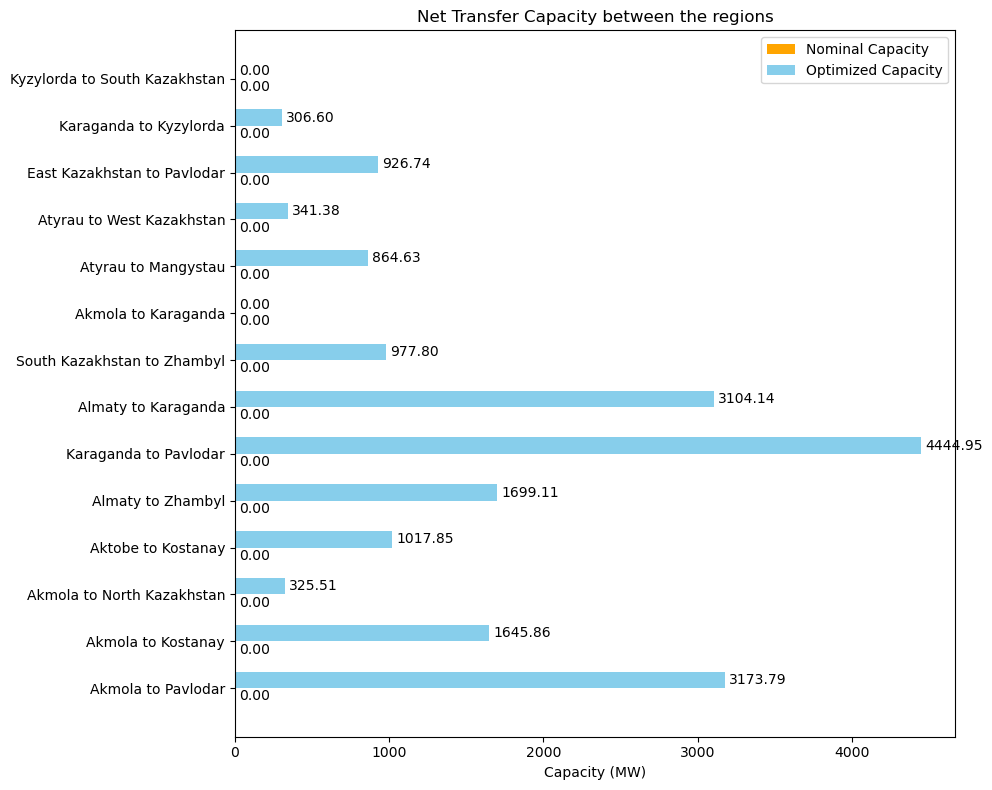

In [64]:
def plot_link_capacities(n):
    # Filter out links with carrier import or export
    exclude_carriers = ['import', 'export']
    link_indices_to_include = [idx for idx in n.links.index if n.links.loc[idx, 'carrier'] not in exclude_carriers]
    # Create DataFrame for link capacities
    link_capacities = pd.DataFrame({
        'Nominal Capacity': n.links.loc[link_indices_to_include, 'p_nom'],
        'Optimized Capacity': n.links.loc[link_indices_to_include, 'p_nom_opt']
    })
    link_capacities['Link'] = [f"{n.links.loc[idx, 'bus0']} to {n.links.loc[idx, 'bus1']}" for idx in link_indices_to_include]
    link_capacities = link_capacities.sort_values(by='Nominal Capacity', ascending=False)
    fig, ax = plt.subplots(figsize=(10, 8))
    bar_width = 0.35
    index = np.arange(len(link_capacities))
    bars1 = ax.barh(index, link_capacities['Nominal Capacity'], bar_width, label='Nominal Capacity', color='orange')
    bars2 = ax.barh(index + bar_width, link_capacities['Optimized Capacity'], bar_width, label='Optimized Capacity', color='skyblue')
    
    ax.set_xlabel('Capacity (MW)')
    ax.set_title('Net Transfer Capacity between the regions')
    ax.set_yticks(index + bar_width / 2)
    ax.set_yticklabels(link_capacities['Link'])
    ax.legend()
    for bars in [bars1, bars2]:
        for bar in bars:
            width = bar.get_width()
            ax.annotate(f'{width:.2f}',
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(3, 0),  # 3 points horizontal offset
                        textcoords="offset points",
                        ha='left', va='center')
    plt.tight_layout()
    plt.show()
# Usage example
plot_link_capacities(n)

### Import and Export Inspection

In [65]:
def print_import_export_generation(n):
    # Berechnung der insgesamt erzeugten Energie für jeden Generator (in MWh)
    total_generation = n.generators_t.p.sum(axis=0)  # Summe über alle Zeitschritte
    total_generation_by_generator = total_generation.div(1e3)  # In GWh umrechnen

    # Filtern der Import- und Export-Generatoren
    import_export_generators = n.generators[n.generators.carrier.isin(['import', 'export'])].copy()
    import_export_generators['total_generation'] = total_generation_by_generator[import_export_generators.index]

    # Ausgabe der Import- und Export-Generatoren mit ihren erzeugten Energiemengen
    print(import_export_generators[['bus', 'carrier', 'total_generation']])

# Beispielaufruf der Funktion
print_import_export_generation(n)

Empty DataFrame
Columns: [bus, carrier, total_generation]
Index: []


In [66]:
def plot_import_export_link_capacities(n):
    # Filter links with carrier import or export
    include_carriers = ['import', 'export']
    link_indices_to_include = [idx for idx in n.links.index if n.links.loc[idx, 'carrier'] in include_carriers]
    
    # Create DataFrame for link capacities
    link_capacities = pd.DataFrame({
        'Nominal Capacity': n.links.loc[link_indices_to_include, 'p_nom'],
        'Optimized Capacity': n.links.loc[link_indices_to_include, 'p_nom_opt']
    })
    link_capacities['Link'] = [f"{n.links.loc[idx, 'bus0']} to {n.links.loc[idx, 'bus1']}" for idx in link_indices_to_include]
    link_capacities = link_capacities.sort_values(by='Nominal Capacity', ascending=False)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    bar_width = 0.35
    index = np.arange(len(link_capacities))
    bars1 = ax.barh(index, link_capacities['Nominal Capacity'], bar_width, label='Nominal Capacity', color='orange')
    bars2 = ax.barh(index + bar_width, link_capacities['Optimized Capacity'], bar_width, label='Optimized Capacity', color='skyblue')
    
    ax.set_xlabel('Capacity (MW)')
    ax.set_title('Import/Export Link Capacities')
    ax.set_yticks(index + bar_width / 2)
    ax.set_yticklabels(link_capacities['Link'])
    ax.legend()
    
    for bars in [bars1, bars2]:
        for bar in bars:
            width = bar.get_width()
            ax.annotate(f'{width:.2f}',
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(3, 0),  # 3 points horizontal offset
                        textcoords="offset points",
                        ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

# Usage example
#plot_import_export_link_capacities(n)

In [67]:
def plot_import_export_flows_over_year(n):
    fig, ax = plt.subplots(figsize=(10, 8))
    include_carriers = ['import', 'export']
    
    for link in n.links.index:
        if n.links.loc[link, 'carrier'] in include_carriers:
            ax.plot(n.links_t.p0.index, n.links_t.p0[link], label=f'{link}', alpha=0.6)
            
    ax.set_title('Import/Export Link Flows over the Year')
    ax.set_xlabel('Date')
    ax.set_ylabel('Flow (MW)')
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usage example#
#plot_import_export_flows_over_year(n)

<a id="0513-Storage-Inspection"></a>
#### 05.1.3 Storage Inspection

In [69]:
def plot_dispatch(n):
    p_by_carrier = n.generators_t.p.T.groupby(n.generators.carrier).sum().T.div(1e3)
    if not n.storage_units.empty:
        sto = n.storage_units_t.p.T.groupby(n.storage_units.carrier).sum().T.div(1e3)
        p_by_carrier = pd.concat([p_by_carrier, sto], axis=1)
    fig, ax = plt.subplots(figsize=(12, 8))
    color = n.carriers.color.reindex(p_by_carrier.columns)
    # Plot positive values for all carriers except storage
    p_by_carrier_pos = p_by_carrier.where(p_by_carrier > 0).drop(columns=['battery storage', 'hydrogen storage underground'], errors='ignore')
    p_by_carrier_pos.plot.area(
        ax=ax,
        linewidth=0,
        color=color[p_by_carrier_pos.columns],
        alpha=0.7  # Higher alpha value for better readability
    )
    # Separate positive and negative values for battery and hydrogen storage
    battery_storage_pos = p_by_carrier['battery storage'].where(p_by_carrier['battery storage'] > 0).fillna(0)
    battery_storage_neg = p_by_carrier['battery storage'].where(p_by_carrier['battery storage'] < 0).fillna(0)
    hydrogen_storage_pos = p_by_carrier['hydrogen storage underground'].where(p_by_carrier['hydrogen storage underground'] > 0).fillna(0)
    hydrogen_storage_neg = p_by_carrier['hydrogen storage underground'].where(p_by_carrier['hydrogen storage underground'] < 0).fillna(0)
    # Plot battery storage
    if 'battery storage' in p_by_carrier.columns:
        color_battery = n.carriers.loc['battery storage', 'color']
        battery_storage_pos.plot.area(ax=ax, linewidth=0, color=color_battery, alpha=0.7, label='battery dispatch')
        battery_storage_neg.plot.area(ax=ax, linewidth=0, color=color_battery, alpha=0.7, label='battery storage')
    # Plot hydrogen storage
    if 'hydrogen storage underground' in p_by_carrier.columns:
        color_hydrogen = n.carriers.loc['hydrogen storage underground', 'color']
        hydrogen_storage_pos.plot.area(ax=ax, linewidth=0, color=color_hydrogen, alpha=0.7, label='hydrogen underground dispatch')
        hydrogen_storage_neg.plot.area(ax=ax, linewidth=0, color=color_hydrogen, alpha=0.7, label='hydrogen underground storage')
    # Plot demand
    n.loads_t.p_set.sum(axis=1).div(1e3).plot(ax=ax, c="k", label='Demand')
    # Automatically extend y-axis to include negative values if they exist
    y_min = p_by_carrier.min().min()
    y_max = p_by_carrier.max().max()
    if y_min == y_max:  # If min and max are the same, expand y-axis limits slightly
        y_min -= 1
        y_max += 1
    ax.set_ylim(y_min, y_max)
    # Custom legend to avoid duplicates
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), loc=(1.05, 0))
    ax.set_ylabel("GW")
    plt.show()

In [70]:
def plot_storage_time_series(n, storage_carriers=None, time=None):
    if storage_carriers is None:
        storage_carriers = ['battery storage', 'hydrogen storage underground']
    if time is None:
        time = n.snapshots  # Set to the entire range of snapshots if no specific time range is provided
    # Filter storage units by specified carriers
    storage_units = n.storage_units[n.storage_units.carrier.isin(storage_carriers)]
    if storage_units.empty:
        print("No storage units found for the specified carriers.")
        return
    # Plot setup
    fig, ax = plt.subplots(figsize=(15, 10))  # Larger plot for better visibility
    # Plot the time series data for each storage unit
    for storage_unit in storage_units.index:
        storage_data = n.storage_units_t.p[storage_unit].loc[time].div(1e3)  # Convert to GW
        ax.plot(storage_data, label=storage_unit)
    # Create a legend
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # Set titles and labels
    ax.set_title(f'Storage Units Time Series Scenario: {n}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Power (GW)')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(True)  # Adds a grid for better readability
    plt.tight_layout()  # Improves layout in the plot
    plt.show()
plot_storage_time_series(n)

No storage units found for the specified carriers.


<a id="0514-Economics"></a>
#### 05.1.4 Economics

Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [72]:
#Was sind die Daten meiner Carrier: Alle Werte betrachten
# Anmerkung: Lebensdauer der Kraftwerke ist nicht berücksichtigt bislang
carriers_in_network = n.generators.carrier.unique().tolist()
if 'OCGT' not in carriers_in_network:
    carriers_in_network.append('OCGT')
carrier_costs = pd.DataFrame(columns=['discount rate', 'lifetime', 'marginal_cost', 'capital_cost', 'investment', 'FOM', 'VOM', 'fuel', 'efficiency'])
for carrier in carriers_in_network:
    if carrier in costs_data.index:
        carrier_costs.loc[carrier] = costs_data.loc[carrier, ['discount rate', 'lifetime', 'marginal_cost', 'capital_cost', 'investment', 'FOM', 'VOM', 'fuel', 'efficiency']]
print(carrier_costs)

        discount rate  lifetime  marginal_cost   capital_cost  investment  \
coal             0.07      40.0      32.213321  337208.027448   3827162.9   
CCGT             0.07      25.0      48.527629  110915.226329    931235.0   
OCGT             0.07      25.0      66.182000   49760.036522    480390.3   
hydro            0.07      80.0       0.000000  182698.734592   2274817.7   
onwind           0.07      27.0       1.587300  113584.192786   1183911.9   
solar            0.07      35.0       0.010600   75323.802088    809811.8   

           FOM     VOM     fuel  efficiency  
coal    1.3100  3.2612   9.5542        0.33  
CCGT    3.3295  4.6562  24.5680        0.56  
OCGT    1.7772  4.7620  24.5680        0.40  
hydro   1.0000  0.0000   0.0000        0.90  
onwind  1.2514  1.5873   0.0000        1.00  
solar   1.5780  0.0106   0.0000        1.00  


In [73]:
# Wie berechnet man die LCOE unter Berücksichtigung der Lebensdauer der Kraftwerke?
# jahresgesamtkosten = Annuität + O&M + Fuel costs
# Annuität = I * CRF
# CRF = CRF_Zähler/ CRF_Nenner
# CRF_Zähler = r*(1+r)**n
# CRF_Nenner = ((1+r)**n)-1

In [74]:
# Testing if calculating to overall system LCOE differs from mean of Buswise LCOE:
def calculate_system_lcoe(network):
    # Sum the energy production for all generators across all time steps
    annual_energy_production = network.generators_t.p.sum(axis=0).sum()  # in MWh
    # Filter out 'import' and 'export' generators
    filtered_generators = network.generators[~network.generators.carrier.isin(['import', 'export'])]
    # Calculate annual CAPEX and OPEX
    total_capex = 0.0
    total_opex = 0.0
    for gen in filtered_generators.index:
        tech = network.generators.at[gen, 'carrier']
        capex = network.generators.at[gen, 'capital_cost']
        opex = network.generators.at[gen, 'marginal_cost']
        p_nom = network.generators.at[gen, 'p_nom']
        # Assume CAPEX is annualized
        total_capex += capex * p_nom
        total_opex += opex * network.generators_t.p[gen].sum()
    # Total annual costs
    total_annual_costs = total_capex + total_opex
    # Calculate LCOE
    lcoe = total_annual_costs / annual_energy_production  # in currency/MWh
    print(f"Total Annual Energy Production: {annual_energy_production:.2f} MWh")
    print(f"Total Annual Costs: {total_annual_costs:.2f} €")
    print(f"Levelized Cost of Electricity (LCOE): {lcoe:.2f} €/MWh")
    return lcoe

# Example usage
lcoe = calculate_system_lcoe(n)

Total Annual Energy Production: 112944700.00 MWh
Total Annual Costs: 8957307795.20 €
Levelized Cost of Electricity (LCOE): 79.31 €/MWh


In [259]:
# Function to calculate CAPEX
def calculate_capex(network, costs_data):
    capex = pd.Series(0.0, index=network.generators.index)
    for gen in network.generators.index:
        carrier = network.generators.at[gen, 'carrier']
        p_nom = network.generators.at[gen, 'p_nom']
        capex[gen] = costs_data.at[carrier, 'capital_cost'] * p_nom
    return capex

# Function to calculate OPEX
def calculate_opex(network, costs_data):
    opex = pd.Series(0.0, index=network.generators.index)
    for gen in network.generators.index:
        carrier = network.generators.at[gen, 'carrier']
        p_nom = network.generators.at[gen, 'p_nom']
        opex[gen] = costs_data.at[carrier, 'marginal_cost'] * network.generators_t.p[gen].sum()
    return opex

# Function to calculate annuity
def calculate_annuity(network, costs_data, discount_rate=0.07, lifetime=20):
    annuity = pd.Series(0.0, index=network.generators.index)
    for gen in network.generators.index:
        carrier = network.generators.at[gen, 'carrier']
        capex = costs_data.at[carrier, 'capital_cost'] * network.generators.at[gen, 'p_nom']
        annuity[gen] = capex * calc_annuity(discount_rate, lifetime)
    return annuity

In [75]:
# Berechne die jährliche Energieproduktion pro Bus (in MWh)
#ToDo: Dynamische Cost Data benutzen
def LCOE_by_bus(n, costs_data):
    # Berechne die jährliche Energieproduktion pro Bus (in MWh)
    annual_energy_production = n.generators_t.p.sum(axis=0)  # Summe über alle Zeitschritte

    # Filtere Generatoren mit dem Carrier 'import' oder 'export' aus
    filtered_generators = n.generators[~n.generators.carrier.isin(['import', 'export'])]
    annual_energy_production = annual_energy_production[filtered_generators.index]

    annual_energy_production_by_bus = annual_energy_production.groupby(filtered_generators.bus).sum()

    # Berechne die jährlichen Kosten pro Bus
    annual_costs_by_bus = pd.Series(0.0, index=n.buses.index)  # Typ auf float setzen, um Kompatibilitätswarnung zu vermeiden
    for bus in n.buses.index:
        generators_at_bus = filtered_generators[filtered_generators.bus == bus]
        for gen in generators_at_bus.index:
            tech = n.generators.at[gen, 'carrier']
            capex = costs_data.at[tech, 'capital_cost']
            opex = costs_data.at[tech, 'marginal_cost']
            p_nom = n.generators.at[gen, 'p_nom']
            annual_costs_by_bus[bus] += (capex * p_nom + opex * annual_energy_production[gen])

    # Berechne die LCOE pro Bus und schließe Busse mit null jährlicher Energieproduktion aus
    LCOE_by_bus = annual_costs_by_bus / annual_energy_production_by_bus
    LCOE_by_bus = LCOE_by_bus.replace([float('inf'), -float('inf')], pd.NA).dropna()

    # Berechne den Mittelwert der LCOE für das gesamte System
    total_annual_energy_production = annual_energy_production.sum()
    total_annual_costs = annual_costs_by_bus.sum()
    mean_LCOE = total_annual_costs / total_annual_energy_production

    # Plotten der LCOE pro Bus
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = LCOE_by_bus.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title('LCOE per Bus')
    ax.set_xlabel('Bus')
    ax.set_ylabel('LCOE (€/MWh)')

    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', color='black', rotation=90)

    ax.axhline(mean_LCOE, color='red', linestyle='--', linewidth=1, label=f'Mean LCOE: {mean_LCOE:.2f} €/MWh')
    ax.legend()
    plt.tight_layout()
    plt.show()

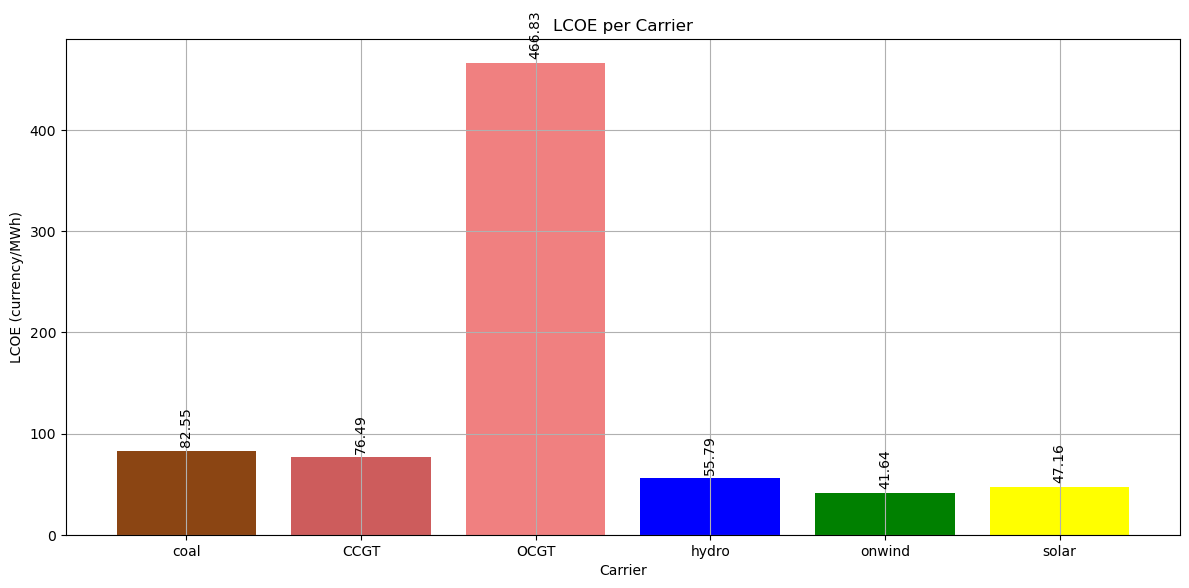

In [76]:
# Calculating carrier-wise LCOE and vizualize in barplot using colors from carriers:
def calculate_and_plot_lcoe_per_carrier(network):
    # Initialize dictionaries to store costs and energy production by carrier
    capex_per_carrier = {}
    opex_per_carrier = {}
    energy_per_carrier = {}
    # Filter out 'import' and 'export' generators
    filtered_generators = network.generators[~network.generators.carrier.isin(['import', 'export'])]
    # Loop over each generator and aggregate costs and production by carrier
    for gen in filtered_generators.index:
        carrier = network.generators.at[gen, 'carrier']
        capex = network.generators.at[gen, 'capital_cost']
        opex = network.generators.at[gen, 'marginal_cost']
        p_nom = network.generators.at[gen, 'p_nom']
        # Calculate annualized CAPEX and total OPEX for the generator
        annual_capex = capex * p_nom
        total_opex = opex * network.generators_t.p[gen].sum()
        total_energy = network.generators_t.p[gen].sum()
        # Aggregate costs and energy production by carrier
        if carrier not in capex_per_carrier:
            capex_per_carrier[carrier] = 0.0
            opex_per_carrier[carrier] = 0.0
            energy_per_carrier[carrier] = 0.0
        capex_per_carrier[carrier] += annual_capex
        opex_per_carrier[carrier] += total_opex
        energy_per_carrier[carrier] += total_energy
    # Calculate LCOE per carrier
    lcoe_per_carrier = {}
    for carrier in capex_per_carrier:
        total_cost = capex_per_carrier[carrier] + opex_per_carrier[carrier]
        total_energy = energy_per_carrier[carrier]
        lcoe_per_carrier[carrier] = total_cost / total_energy if total_energy != 0 else float('inf')
    # Plotting
    carriers = list(lcoe_per_carrier.keys())
    lcoe_values = list(lcoe_per_carrier.values())
    colors = network.carriers.color.reindex(carriers).values
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(carriers, lcoe_values, color=colors)
    # Adding data labels
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', color='black', rotation=90)
    ax.set_title('LCOE per Carrier')
    ax.set_xlabel('Carrier')
    ax.set_ylabel('LCOE (currency/MWh)')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    return lcoe_per_carrier

# Example usage
lcoe_per_carrier = calculate_and_plot_lcoe_per_carrier(n)


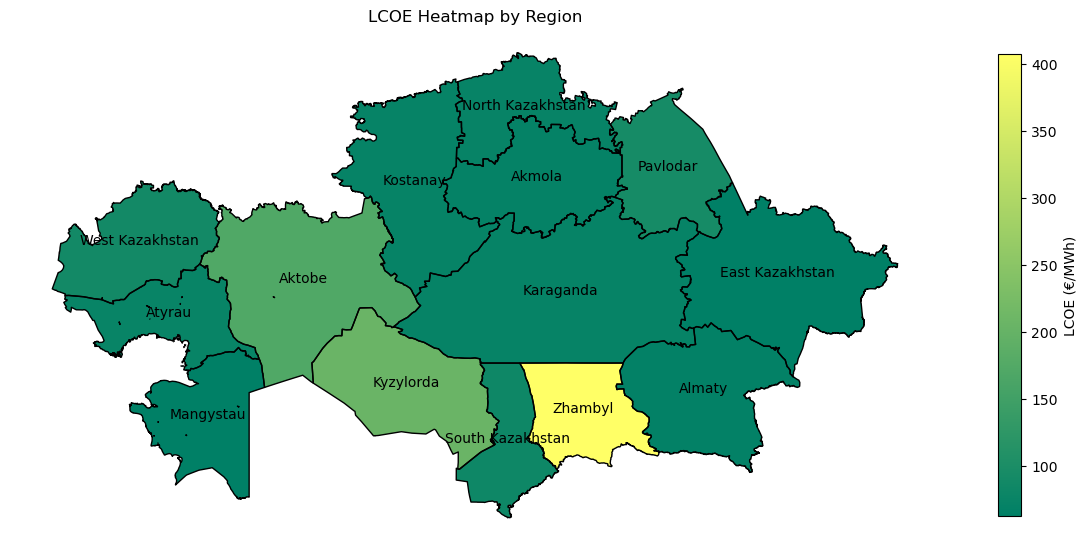

In [77]:
# Kartografischer Plot
# Calculate LCOE per bus
# Berechne die jährliche Energieproduktion pro Bus (in MWh)
annual_energy_production = n.generators_t.p.sum(axis=0)  # Summe über alle Zeitschritte
# Filtere Generatoren mit dem Carrier 'import' oder 'export' aus
filtered_generators = n.generators[~n.generators.carrier.isin(['import', 'export'])]
annual_energy_production = annual_energy_production[filtered_generators.index]
annual_energy_production_by_bus = annual_energy_production.groupby(filtered_generators.bus).sum()
# Berechne die jährlichen Kosten pro Bus
annual_costs_by_bus = pd.Series(0.0, index=n.buses.index)  # Typ auf float setzen, um Kompatibilitätswarnung zu vermeiden
for bus in n.buses.index:
    generators_at_bus = filtered_generators[filtered_generators.bus == bus]
    for gen in generators_at_bus.index:
        tech = n.generators.at[gen, 'carrier']
        capex = costs_data.at[tech, 'capital_cost']
        opex = costs_data.at[tech, 'marginal_cost']
        p_nom = n.generators.at[gen, 'p_nom']
        annual_costs_by_bus[bus] += (capex * p_nom + opex * annual_energy_production[gen])

LCOE_by_bus = annual_costs_by_bus / annual_energy_production_by_bus
LCOE_by_bus = LCOE_by_bus.replace([float('inf'), -float('inf')], pd.NA).dropna()
mean_LCOE = LCOE_by_bus.mean()
# Print the LCOE values to check
#print("LCOE by bus:")
#print(LCOE_by_bus)
# Load shapefile data of regions
shapefile_path = r"C:\Users\jan.carsten\Python Programmieren\04 Multi Node Network\kaz_adm_unhcr_2023_shp\kaz_admbnda_adm1_unhcr_2023.shp"
regions = gpd.read_file(shapefile_path)
# Verify available region names in shapefile
#print("Available regions in shapefile:")
#print(regions['ADM1_EN'].unique())
# Mapping between LCOE bus names and region names in the shapefile
region_mapping = {
    'Akmola': ['Astana', 'Akmola Region'],
    'Karaganda': ['Karaganda Region', 'Ulytau Region'],
    'Zhambyl': ['Jambyl Region'],
    'East Kazakhstan': ['Abay Region', 'East Kazakhstan Region'],
    'Almaty': ['Jetisu Region', 'Almaty', 'Almaty Region'],
    'South Kazakhstan': ['Turkistan Region', 'Shymkent'],
    'Aktobe': ['Aktobe Region'],
    'Atyrau': ['Atyrau Region'],
    'Kyzylorda': ['Kyzylorda Region'],
    'Kostanay': ['Kostanay Region'],
    'Mangystau': ['Mangystau Region'],
    'North Kazakhstan': ['North Kazakhstan Region'],
    'Pavlodar': ['Pavlodar Region'],
    'West Kazakhstan': ['West Kazakhstan Region'],
}
# Create a DataFrame for LCOE_by_bus to merge with GeoDataFrame
LCOE_df = pd.DataFrame(LCOE_by_bus).reset_index()
LCOE_df.columns = ['bus', 'LCOE']
# Initialize a new DataFrame for the merged data
merged_data = []
# Apply the mapping to the regions GeoDataFrame
for region, subregions in region_mapping.items():
    # Filter regions that match the current group of subregions
    subregion_shapes = regions[regions['ADM1_EN'].isin(subregions)]
    if not subregion_shapes.empty:
        # Dissolve the subregions into a single shape for the current region
        merged_shape = subregion_shapes.unary_union
        # Calculate the average LCOE for the merged region
        if region in LCOE_by_bus.index:
            avg_lcoe = LCOE_by_bus[region]
            merged_data.append({'Region': region, 'geometry': merged_shape, 'LCOE': avg_lcoe})
        #else:
            #print(f"LCOE for region {region} not found in LCOE_by_bus.") # debugging
    #else:
        #print(f"No subregion shapes found for region {region} with subregions {subregions}.") # debugging
# Create a GeoDataFrame from the merged regions
merged_gdf = gpd.GeoDataFrame(merged_data, crs=regions.crs)
# Print the merged regions to check
#print("Merged regions with LCOE data:")
#print(merged_gdf[['Region', 'LCOE']])
# Plot the LCOE heatmap
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_gdf.boundary.plot(ax=ax, linewidth=1, color='black')
plot = merged_gdf.plot(column='LCOE', ax=ax, legend=True, cmap='summer', legend_kwds={'label': "LCOE (€/MWh)", 'orientation': "vertical", 'shrink': 0.6})
# Annotate the regions with their names at the centroid of each region
for idx, row in merged_gdf.iterrows():
    centroid = row['geometry'].centroid
    ax.annotate(text=row['Region'], xy=(centroid.x, centroid.y), horizontalalignment='center', fontsize=10, color='black')
ax.set_title('LCOE Heatmap by Region')
ax.set_axis_off()
plt.show()
#print(LCOE_by_bus)

In [78]:
# Test: Wie werden die CAPEX im System berechnet, die in n.statistics angezeigt werden?
# Annahme: capex_test ist bereits wie folgt definiert
capex_test = n.statistics()
# Überprüfen der Struktur von capex_test
#print(capex_test)
# Hinzufügen einer neuen Spalte, die die Kapitalausgaben durch die installierte Kapazität teilt
capex_test['CAPEX per Installed Capacity'] = capex_test['Capital Expenditure'] / capex_test['Installed Capacity']
capex_vergleich=capex_test['CAPEX per Installed Capacity']
# Ausgabe des aktualisierten DataFrames
print(capex_vergleich)
print("Investmentcost OCGT :", costs_data.at["OCGT", "investment"])
print("Investmentcost CCGT:", costs_data.at["CCGT", "investment"])
print("Investmentcost coal:", costs_data.at["coal", "investment"])
print("Investmentcost hydro:", costs_data.at["hydro", "investment"])
print("Investmentcost onwind:", costs_data.at["onwind", "investment"])
print("Investmentcost solar:", costs_data.at["solar", "investment"])

Generator  CCGT      110915.226329
           OCGT       49760.036522
           coal      337208.027448
           hydro     182698.734592
           onwind    113584.192786
           solar      75323.802088
Link       AC                  NaN
Load       -                   NaN
Name: CAPEX per Installed Capacity, dtype: float64
Investmentcost OCGT : 480390.30000000005
Investmentcost CCGT: 931235.0
Investmentcost coal: 3827162.9
Investmentcost hydro: 2274817.7
Investmentcost onwind: 1183911.9000000001
Investmentcost solar: 809811.7999999999


Combined DataFrame:
               CAPEX         OPEX  System Costs
carrier                                        
CCGT      385.984988   669.949655   1055.934642
OCGT       80.879963    13.360324     94.240287
coal     4372.576492  2798.006711   7170.583203
hydro     498.031270     0.000000    498.031270
onwind     73.682066     2.919804     76.601870
solar      61.902607     0.013916     61.916523


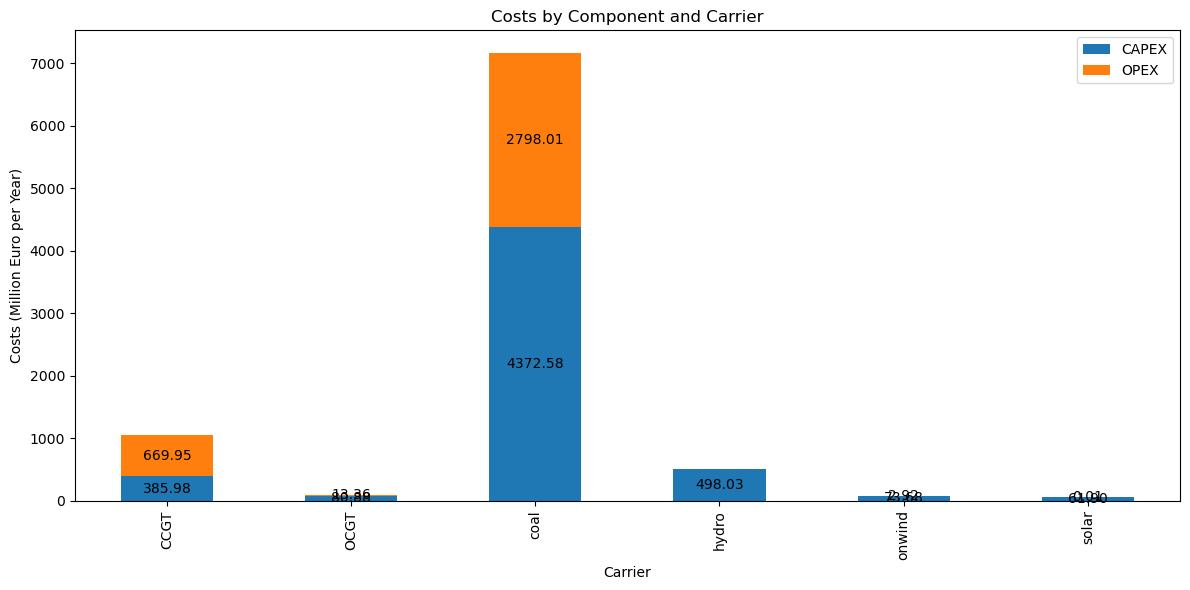

Total System Costs: 8957.31 Million Euro per Year


In [79]:
def system_cost(n):
    tsc = n.statistics.capex().groupby(level=1).sum() + n.statistics.opex().groupby(level=1).sum()
    return tsc.div(1e6)  # million €/a

def capex_data(n):
    return n.statistics.capex().groupby(level=1).sum().div(1e6)  # million €/a

def opex_data(n):
    return n.statistics.opex().groupby(level=1).sum().div(1e6)  # million €/a
    
def combined_cost_plot(n):
    capex = capex_data(n)
    opex = opex_data(n)
    system_costs = system_cost(n)
    # Sicherstellen, dass alle DataFrames denselben Index haben
    all_carriers = capex.index.union(opex.index).union(system_costs.index)
    capex = capex.reindex(all_carriers).fillna(0)
    opex = opex.reindex(all_carriers).fillna(0)
    #system_costs = system_costs.reindex(all_carriers).fillna(0)

    # Überprüfen der Kostenkomponenten
    combined_df = pd.DataFrame({
        'CAPEX': capex,
        'OPEX': opex,
        'System Costs': capex + opex,
    })
    print("Combined DataFrame:")
    print(combined_df)
    # Plotting der Kostenkomponenten
    fig, ax = plt.subplots(figsize=(12, 6))
    combined_df[['CAPEX', 'OPEX']].plot(kind='bar', stacked=True, ax=ax)
    ax.set_title('Costs by Component and Carrier')
    ax.set_ylabel('Costs (Million Euro per Year)')
    ax.set_xlabel('Carrier')
    # Adding data labels
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only add label for positive bars
            ax.annotate(f'{height:.2f}',
                        xy=(p.get_x() + p.get_width() / 2, p.get_y() + height / 2),
                        xytext=(0, 0),
                        textcoords="offset points",
                        ha='center', va='center')
    plt.tight_layout()
    plt.show()
    # Gesamtkosten ausgeben
    total_capex = capex.sum()
    total_opex = opex.sum()
    total_costs = total_capex + total_opex
    print(f"Total System Costs: {total_costs:.2f} Million Euro per Year")

# Beispiel-Aufruf der Funktion (das Netzwerk sollte vorher definiert sein)
combined_cost_plot(n)

In [80]:
# Überprüfen der spezifischen Capex- und Opex-Daten für Hydro
print("Hydro CAPEX Data:")
print(n.statistics.capex().loc[:, 'hydro'])

#print("Hydro OPEX Data:")
#print(n.statistics.opex().loc[:, 'hydro'])
#Hydro hat aktuell keine marginal costs

Hydro CAPEX Data:
component
Generator    4.980313e+08
dtype: float64


In [81]:
def plot_total_system_costs(n):
    # Berechnung der CAPEX und OPEX Daten
    capex = capex_data(n).sum()
    opex = opex_data(n).sum()
    data = {
        'Kosten': ['CAPEX', 'OPEX'],
        'Wert': [capex, opex]
    }
    df = pd.DataFrame(data)
    fig, ax = plt.subplots(figsize=(8, 6))
    df.set_index('Kosten').T.plot(kind='bar', stacked=True, color=['orange', 'royalblue'], ax=ax)
    ax.set_title('Gesamtsystemkosten (CAPEX und OPEX)')
    ax.set_xlabel('Systemkosten')
    ax.set_ylabel('Kosten (Million Euro pro Jahr)')
    for container in ax.containers:
        labels = [f'{v:.2f}' if v > 0 else '' for v in container.datavalues]
        ax.bar_label(container, labels=labels, label_type='center')
    plt.tight_layout()
    plt.show()
    # Gesamtkosten ausgeben
    total_costs = capex + opex
    print(f"Gesamtkosten des Systems: {total_costs:.2f} Millionen Euro pro Jahr")

<a id="0515-Emissions"></a>
#### 05.1.5 Emissions

In [82]:
#CO2-Mengen berechnen
e = (n.generators_t.p/ n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions)) # t/h für die snapshots
co2_emissions_per_generator = e.sum()
total_co2_emissions = e.sum().sum() #natürlich nur für die zwei wochenProduktion im Jahr
print('Total CO2-Emissions of optimized state without constraints: ',total_co2_emissions,'Tons CO2-equivalent')

Total CO2-Emissions of optimized state without constraints:  93445422.35851814 Tons CO2-equivalent


In [83]:
def plot_emissions_by_carrier(n):
    e = (n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions))  # t/h für die snapshots
    total_co2_emissions = e.sum().sum()
    co2_emissions_per_generator = e.sum()
    e_by_carrier = e.T.groupby(n.generators.carrier).sum().T
    colors = n.carriers.color.reindex(e_by_carrier.columns)
    fig, ax = plt.subplots(figsize=(10, 8))
    e_by_carrier.plot(ax=ax, color=colors, linewidth=2, alpha=0.6)
    ax.set_title('CO2 Emissions Over Time by Carrier')
    ax.set_xlabel('Time')
    ax.set_ylabel('CO2 Emissions (kg)')
    ax.legend(title='Carrier')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    return total_co2_emissions, co2_emissions_per_generator
# Aufrufen der Funktion, um den Plot zu erstellen
#total_co2_emissions, co2_emissions_per_generator = plot_emissions_by_carrier(n)
# Ausgabe der Gesamt-CO2-Emissionen und der CO2-Emissionen pro Generator
print("Total CO2 Emissions (kg):", total_co2_emissions)
#print("CO2 Emissions per Generator (kg):", co2_emissions_per_generator)

Total CO2 Emissions (kg): 93445422.35851814


In [84]:
# Emissionen akkumuliert nach Carrier
def plot_total_emissions_by_carrier_pie(n):
    e = (n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions)).sum(axis=0)  # t für die snapshots
    co2_emissions_by_carrier = e.groupby(n.generators.carrier).sum()
    colors = n.carriers.color.reindex(co2_emissions_by_carrier.index)
    fig, ax = plt.subplots(figsize=(10, 6))
    wedges, texts, autotexts = ax.pie(co2_emissions_by_carrier, colors=colors, autopct=lambda p: f'{p:.1f}%' if p > 0 else '', startangle=90, counterclock=False)
    ax.set_title('Total CO2 Emissions by Carrier')
    ax.legend(wedges, co2_emissions_by_carrier.index, title="Carriers", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    for autotext, value in zip(autotexts, co2_emissions_by_carrier):
        autotext.set_text(f'{value:.0f} t')
        autotext.set_color('white')
        autotext.set_fontsize(10)
    plt.tight_layout()
    plt.show()
#plot_total_emissions_by_carrier_pie(n)

In [85]:
def plot_total_emissions_by_region_and_carrier(n):
    # Berechnung der CO2-Emissionen pro Generator
    emissions = (n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions)).sum(axis=0)
    n.generators['emissions'] = emissions
    emissions_by_region_and_carrier = n.generators.groupby(['bus', 'carrier'])['emissions'].sum().unstack(fill_value=0)
    colors = {carrier: n.carriers.loc[carrier, 'color'] for carrier in n.carriers.index}
    ax = emissions_by_region_and_carrier.plot(kind='bar', stacked=True, figsize=(13, 6), color=[colors[carrier] for carrier in emissions_by_region_and_carrier.columns])
    ax.set_title('Total CO2 Emissions by Region and Carrier')
    ax.set_xlabel('Region')
    ax.set_ylabel('Total Emissions (t CO2 equivalents)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Bar labels hinzufügen
    for container in ax.containers:
        labels = [f'{v:.0f} t' if v > 0 else '' for v in container.datavalues]
        ax.bar_label(container, labels=labels, label_type='center', fontsize=8, color='black', rotation=90)
    plt.show()
# Beispielaufruf
#plot_total_emissions_by_region_and_carrier(n)

In [86]:
def plot_total_emissions_by_clustered_region_and_carrier(n, zones):
    # Berechnung der CO2-Emissionen pro Generator
    emissions = (n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions)).sum(axis=0)
    n.generators['emissions'] = emissions
    n.generators['clustered_region'] = n.generators['bus'].map(lambda x: next((zone for zone, regions in zones.items() if x in regions), 'Unknown'))
    emissions_by_clustered_region_and_carrier = n.generators.groupby(['clustered_region', 'carrier'])['emissions'].sum().unstack(fill_value=0)
    colors = {carrier: n.carriers.loc[carrier, 'color'] for carrier in n.carriers.index}
    ax = emissions_by_clustered_region_and_carrier.plot(kind='bar', stacked=True, figsize=(12, 4), color=[colors[carrier] for carrier in emissions_by_clustered_region_and_carrier.columns])
    ax.set_title('Total CO2 Emissions by Clustered Region and Carrier')
    ax.set_xlabel('Clustered Region')
    ax.set_ylabel('Total Emissions (t)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Bar labels hinzufügen
    for container in ax.containers:
        labels = [f'{v:.0f} t' if v > 0 else '' for v in container.datavalues]
        ax.bar_label(container, labels=labels, label_type='center', fontsize=8, color='black', rotation=90)
    plt.show()

# Beispielaufruf
#plot_total_emissions_by_clustered_region_and_carrier(n, zones)

In [87]:
# Emissions data for future constraints:
emissions_1990_total = 385.60300 #Mt Co2-equivalent with LULUCF
emissions_1990_energy_sector = 316.91854 #Mt Co2-equivalent
emissions_target_2030 =emissions_1990_energy_sector*0.85
emissions_2020_total = 351.24426 #Mt Co2-equivalent with LULUCF
emissions_2020_energy_sector =272.49931 #Mt Co2-equivalent
AGORA_2030_emissions = 80 #MtCO2-equivalent
# Get the CO2 emissions factors for each generator's carrier
co2_emissions_factors = n.generators.carrier.map(n.carriers['co2_emissions'])
# Calculate the total CO2 emissions
co2_emissions = (n.snapshot_weightings.generators @ n.generators_t.p) / n.generators.efficiency * co2_emissions_factors
# Sum the CO2 emissions and convert to kilotonnes
total_emissions = co2_emissions.sum() / 1e6
# Print the total emissions in kilotonnes
print(f"Baseline Modell Total CO2 Emissions: {total_emissions} Mt CO2-equivalent")

Baseline Modell Total CO2 Emissions: 93.44542235851814 Mt CO2-equivalent


<a id="06-Scenarios"></a>
### 06 Scenarios

Hier werden die Szenarien definiert, vorbereitet, optimiert und die relevanten Ergebissse nach dem systematischen Abspeichern gemeinsam über die Szenarien geplottet.

<a id="0601-Definition"></a>
#### 06.1 Definition

Functions for Scenario usage and scenario definitions

Vorüberlegungen Szenariodefinition:

n Status quo, Daten ohne Optimierung auslesen
n Optimieren oder nicht und dann als Input für 2030er Szenarien festlegen

Drei Vergleiche:
Einmal Vanilla nur mit Optionen und extendable
Einmal mit Linkerweiterung ab 2030
Einmal lokale vs globale Klimaziele

n2024: Status quo:
n2030nC: Leer Szenario als Vergleich ohne -15 % Contstraint,15 % RES, alles extendable, überall EEs, Batteriespeicher und hydrogen underground zulassen;
n2030global: -15 prozent Emissionen (global), 15 % RES, alles extendable, überall EEs, Batteriespeicher und hydrogen underground zulassen;
n2030link: -15 prozent Emissionen (global), 15 % RES, alles extendable, überall EEs, Batteriespeicher und hydrogen underground zulassen; Verbindung zwischen Atyrau-Aktobe (Link), Almaty- East KAZ und East KAZ-Karaganda zulassen.

(n2050a: 50 % RES in 2050)

n2060a: -100 prozent Emissionen (global), alles extendable, überall EEs, Batteriespeicher und hydrogen underground zulassen; Input ist n2030a
n2060b: -100 prozent Emissionen (global), alles extendable, überall EEs, Batteriespeicher und hydrogen underground zulassen; Verbindung zwischen Atyrau-Aktobe (Link), Almaty- East KAZ und East KAZ-Karaganda zulasse. Input ist n2030b

Optional: 
n2050h2/2060h2: -100 % Emissionen in West Region und Export von Hydrogen nach Europa mit Importlink abbilden
    Sensitivitätsanalyse von Exportmengen und Exportpreisen unter gegebenen Annahmen vornehmen.

Welche Daten abspeichern und plotten lassen?
objective, LCOE pro region, Kapazität
Kostenjahre berücksichtigen!
Hydrogen Export Option?
Provocative Approach: Is a higher RES Share already feasible in 2030?

# Functions to build scenarios:

In [88]:
def add_global_co2_reduction_constraint(network, reduction_factor):
    # Berechne die aktuellen Gesamtemissionen
    current_emissions = (
        network.generators_t.p
        / network.generators.efficiency
        * network.generators.carrier.map(network.carriers.co2_emissions)
    ).sum().sum()
    # Berechne das reduzierte Emissionsziel basierend auf dem Reduktionsfaktor
    reduced_emissions = current_emissions * (1 - reduction_factor / 100)
    reduced_emissions = reduced_emissions / 1e6  # Normieren auf Megatonnen
    print(f"Aktuelle Gesamtemissionen: {current_emissions / 1e6:.2f} Mt CO2-equivalent")
    print(f"Reduziertes Emissionsziel: {reduced_emissions:.2f} Mt CO2-equivalent")
    # Füge die globale CO2-Beschränkung hinzu
    network.add(
        "GlobalConstraint",
        "CO2Limit",
        type='primary_energy',
        carrier_attribute="co2_emissions",
        sense="<=",
        constant=reduced_emissions,
    )
    return network

# Beispielaufruf der Funktion
#add_global_co2_reduction_constraint(n, 15)

In [89]:
# Evtl nutzen, falls es nicht alles zerschießt.
def set_scenario_snapshots(network, year):
    # Generate a date range for the specified year
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    snapshots = pd.date_range(start=start_date, end=end_date, freq='H')
    # Set the network snapshots to the generated date range
    network.set_snapshots(snapshots)
    return network

# Example usage
# n = ... # Your PyPSA network
# n = set_scenario_snapshots(n, 2030)

In [90]:
# Funktion für extendable = true
def make_all_extendable(network):
    #network.generators.p_nom_extendable = True
    network.links.p_nom_extendable = True

In [138]:
def add_missing_wind_generators(n, year, all_profiles=all_profiles, costs_data=costs_data):
    # Alle bestehenden Generatoren im Netzwerk erfassen
    costs_data = get_costs_data(year)
    existing_generators = n.generators
    # Alle Busse im Netzwerk erfassen
    all_buses = n.buses.index
    added_counter = 0
    added_generators = []
    for bus in all_buses:
        # Onwind Generator hinzufügen, falls nicht vorhanden
        #if not ((existing_generators['bus'] == bus) & (existing_generators['carrier'] == 'onwind')).any():
            generator_name = f"{bus}_onwind_{year}"
            n.add(
                "Generator",
                name=generator_name,
                bus=bus,
                carrier="onwind",
                capital_cost=costs_data.at["onwind", "capital_cost"],
                marginal_cost=costs_data.at["onwind", "marginal_cost"],
                efficiency=costs_data.at["onwind", "efficiency"],
                p_nom=0,
                p_nom_extendable= True,
                build_year = year

            )
            added_counter += 1
            added_generators.append(generator_name)
            # Verfügbarkeitsprofile zuweisen
            if bus in all_profiles.columns:
                normalized_profile = all_profiles[bus]
                if (normalized_profile < 0).any():
                    print(f"Error: Negative value found for bus {bus}. Setting profile to 0.")
                    normalized_profile = normalized_profile.clip(lower=0)
                n.generators_t.p_max_pu.loc[:, generator_name] = normalized_profile
            else:
                print(f"Warning: No wind data available for bus {bus}.")
    # Anzahl der hinzugefügten Windgeneratoren und ihre Namen ausgeben
    print(f"Total number of new wind generators added: {added_counter}")
    print("Names of added wind generators:")
    for gen in added_generators:
        print(gen)

In [92]:
# Untersuche, ob allprofiles negative Werte enthält:
#negative_values = all_profiles[all_profiles < 0]
#negative_values
#print(all_profiles)

In [139]:
def add_missing_solar_generators(n, year, all_profiles_pv=all_profiles_pv, costs_data=costs_data):
    # Alle bestehenden Generatoren im Netzwerk erfassen
    costs_data = get_costs_data(year)
    existing_generators = n.generators
    # Alle Busse im Netzwerk erfassen
    all_buses = n.buses.index
    for bus in all_buses:
        # Solar Generator hinzufügen, falls nicht vorhanden
        #if not ((existing_generators['bus'] == bus) & (existing_generators['carrier'] == 'solar')).any():
            generator_name = f"{bus}_solar_{year}"
            n.add(
                "Generator",
                name=generator_name,
                bus=bus,
                carrier="solar",
                capital_cost=costs_data.at["solar", "capital_cost"],
                marginal_cost=costs_data.at["solar", "marginal_cost"],
                efficiency=costs_data.at["solar", "efficiency"],
                p_nom=0,
                p_nom_extendable=True,
                build_year = year
            )
            # Verfügbarkeitsprofile zuweisen
            if bus in all_profiles_pv.columns:
                normalized_profile = all_profiles_pv[bus]
                n.generators_t.p_max_pu.loc[:, generator_name] = normalized_profile
            else:
                print(f"Warning: No PV data available for bus {bus}")

In [94]:
# Function to add Battery and hydrogen Storages to busses except Import busses
def add_storage_units(network, year):
    # Aktualisiert die Kostendaten auf das Zieljahr
    costs_data = get_costs_data(year)
    # Liste der zu ignorierenden Busse
    ignored_buses = ["RU", "UZ", "KY"]
    for bus in network.buses.index:
        # Ignoriere die spezifizierten Busse
        if any(ignored_bus in bus for ignored_bus in ignored_buses):
            continue
        # Batteriespeicher hinzufügen
        network.add(
            "StorageUnit",
            f"battery_storage_{bus}",
            bus=bus,
            carrier="battery storage",
            max_hours=6,
            capital_cost=costs_data.at["battery inverter", "capital_cost"] + 
                         6 * costs_data.at["battery storage", "capital_cost"],
            efficiency_store=costs_data.at["battery inverter", "efficiency"],
            efficiency_dispatch=costs_data.at["battery inverter", "efficiency"],
            p_nom_extendable=True,
            cyclic_state_of_charge=True,
        )
        # Wasserstoffspeicher hinzufügen
        capital_costs = (
            costs_data.at["electrolysis", "capital_cost"] +
            costs_data.at["fuel cell", "capital_cost"] +
            168 * costs_data.at["hydrogen storage underground", "capital_cost"]
        )
        network.add(
            "StorageUnit",
            f"hydrogen_storage_{bus}",
            bus=bus,
            carrier="hydrogen storage underground",
            max_hours=168,
            capital_cost=capital_costs,
            efficiency_store=costs_data.at["electrolysis", "efficiency"],
            efficiency_dispatch=costs_data.at["fuel cell", "efficiency"],
            p_nom_extendable=True,
            cyclic_state_of_charge=True,
        )

In [95]:
# Function for RES Share constraint
#def add_renewable_share_constraint(n, min_share):
    # Define the renewable carriers
 #   renewable_carriers = ['onwind', 'solar', 'hydro']
    # Extract the generator capacities and carriers
  #  renewable_generators = n.generators.index[n.generators.carrier.isin(renewable_carriers)]
   # all_generators = n.generators.index
    # Define the constraint
    #def renewable_share_constraint(model):
     #   renewable_generation = sum(model.generator_p[gen] for gen in renewable_generators)
      #  total_generation = sum(model.generator_p[gen] for gen in all_generators)
       # return renewable_generation >= min_share * total_generation
    # Add the constraint to the network
   # n.model.add_constraint(renewable_share_constraint, 'renewable_share_constraint')
# Add the renewable share constraint (e.g., 15%)
#add_renewable_share_constraint(n, 0.15)

In [96]:
# Function to add renewable share constraint to the Pyomo model
def add_renewable_share_constraint(n, min_share):
    renewable_carriers = ['onwind', 'solar', 'hydro']
    renewable_generators = n.generators.index[n.generators.carrier.isin(renewable_carriers)]
    all_generators = n.generators.index

    def renewable_share_rule(model):
        renewable_generation = sum(model.generator_p[gen] for gen in renewable_generators)
        total_generation = sum(model.generator_p[gen] for gen in all_generators)
        return renewable_generation >= min_share * total_generation
    # Adding the constraint during the creation of the Pyomo model
    def extra_functionality(model, network, snapshots):
        model.renewable_share_constraint = pyo.Constraint(rule=renewable_share_rule)
    return extra_functionality

# Beispielaufruf:
# Define the extra functionality
extra_functionality = add_renewable_share_constraint(n, min_share=0.15)

In [97]:
# Funktion for grid extension
def add_grid_extension(n):
    links_to_add = [
        ("Atyrau", "Aktobe"),
        ("Almaty", "East Kazakhstan"),
        ("East Kazakhstan", "Karaganda")
    ]
    for bus0, bus1 in links_to_add:
        link_name = f"link_{bus0}_{bus1}"
        n.add(
            "Link",
            link_name,
            bus0=bus0,
            bus1=bus1,
            p_min_pu=-1,  # Make links bidirectional
            p_nom_extendable=True,  # Assume link capacities are extendable
        )
    print("Grid extension links added successfully.")
# Example usage:
#add_grid_extension(n)

In [98]:
# Function that covers growth of demand per year
# KAZENERGY Reports 0,78% of growth in produced electricity per year on average until 2050
annual_growth_demand = 1.0078 # 0,78%
def adjust_demand(network, annual_growth_rate, start_year=2022, target_year=2030):
    total_growth_factor = annual_growth_rate ** (target_year - start_year)
    network.loads_t.p_set = network.loads_t.p_set * total_growth_factor
    return network

In [99]:
# Function to update cost data for a given year
def update_costs_for_year(network, year):
    costs_data = get_costs_data(year)
    for gen in network.generators.index:
        tech = network.generators.at[gen, 'carrier']
        if tech not in ['import', 'export']:  # Ignoriere die Carrier 'import' und 'export'
            network.generators.at[gen, 'capital_cost'] = costs_data.at[tech, 'capital_cost']
            network.generators.at[gen, 'marginal_cost'] = costs_data.at[tech, 'marginal_cost']
            network.generators.at[gen, 'efficiency'] = costs_data.at[tech, 'efficiency']
    print(f"Cost data updated for the year {year}")
# Beispielaufruf:
# update_costs_for_year(n2030, 2030)

In [100]:
# Decomissioning cost function: Not used at the moment
# Rückbaukosten hinzufügen (zum Beispiel: 30% der Kapitalausgaben)
decommissioning_cost_fraction = 0.3
n.generators['decommissioning_cost'] = n.generators['capital_cost'] * decommissioning_cost_fraction

# Funktion zur Anpassung der Zielfunktion
def add_decommissioning_cost(n):
    # Add the decommissioning cost variable
    n.model.decommissioning_cost = pyo.Var(n.generators.index, domain=pyo.NonNegativeReals)
    # Define the expression for decommissioning costs
    decommissioning_cost_expr = sum(
        n.model.decommissioning_cost[g] for g in n.generators.index
    )
    # Add the decommissioning costs to the objective function
    n.model.objective.expr += decommissioning_cost_expr

In [101]:
# function to disallow hydropower negative extension: Vllt ein zu starker Eingriff in die Optimierung
def set_hydro_p_nom_min(n):
    # Setze die untere Grenze der Generatorleistung für alle Generatoren mit dem Carrier 'hydro'
    hydro_generators = n.generators[n.generators.carrier == 'hydro']
    n.generators.loc[hydro_generators.index, 'p_nom_min'] = hydro_generators['p_nom']
    print(f"Set minimum capacity for hydro generators: {hydro_generators.index.tolist()}")

In [140]:
# Calculate lifetime for scenarios
def assign_lifetime_to_generators(n, costs_data):
    # Iteriere über alle Generatoren im Netzwerk
    for gen in n.generators.index:
        carrier = n.generators.at[gen, 'carrier']
        build_year = n.generators.at[gen, 'build_year']
        # Prüfe, ob die Lebensdauer für den Carrier in costs_data vorhanden ist
        if carrier in costs_data.index:
            tech_lifetime = costs_data.at[carrier, 'lifetime']
            # Setze die Lebensdauer des Generators
            n.generators.at[gen, 'lifetime'] = tech_lifetime
        else:
            print(f"Warning: No lifetime data available for carrier {carrier}.")
    return n

# Beispiel-Aufruf der Funktion
#n = assign_lifetime_to_generators(n, costs_data)
# Überprüfe das Ergebnis
#print(n.generators[['build_year', 'lifetime']])

In [129]:
n2030nC.generators['lifetime']

Generator
Akmola_coal_0                  40.0
Akmola_coal_1                  40.0
Akmola_coal_2                  40.0
Aktobe_CCGT_3                  25.0
Aktobe_OCGT_4                  25.0
                               ... 
North Kazakhstan_solar_2030    35.0
East Kazakhstan_solar_2030     35.0
South Kazakhstan_solar_2030    35.0
West Kazakhstan_solar_2030     35.0
Zhambyl_solar_2030             35.0
Name: lifetime, Length: 172, dtype: float64

In [148]:
# Remove generators that have exceeded their lifetime and calculate the total decommissioned capacity
def decommission_old_generators(network, current_year):
    total_decommissioned_capacity = 0.0  # Initialize the total decommissioned capacity
    initial_total_capacity = network.generators['p_nom'].sum()  # Get the initial total capacity

    for gen in network.generators.index:
        build_year = network.generators.at[gen, 'build_year']
        lifetime = network.generators.at[gen, 'lifetime']
        
        if lifetime != float('inf') and (current_year - build_year) > lifetime:
            total_decommissioned_capacity += network.generators.at[gen, 'p_nom']  # Add the capacity to the total
            network.remove("Generator", gen)
            print(f"Decommissioned generator {gen} built in {build_year} with lifetime {lifetime} years.")

    # Calculate the percentage of decommissioned capacity
    percentage_decommissioned = (total_decommissioned_capacity / initial_total_capacity) * 100

    # Print the total decommissioned capacity and its percentage
    print(f"Total decommissioned capacity: {total_decommissioned_capacity} MW")
    print(f"Percentage of initial capacity decommissioned: {percentage_decommissioned:.2f}%")

# Usage example
current_year = 2030
#decommission_old_generators(n, current_year)

In [271]:
# Create a profile of hydorgen demand:
# Importbedarf DE: 95-130 TWh
# Das entspricht 95000-130000 GWh und 95.000.000 MWh
import_de_2030 = 130*1e6 # in MWh

In [104]:
# Functionality for H2 Export Option in West Kasachstan:
# Adds bus h2_export
# adds three links, that serve as electrolysis
def add_hydrogen_export_option(network, current_year):
    # add carrier named hydrogen
    carriers = {"hydrogen": {"emissions": 0, "color": "cyan"}
                for carrier_name, props in carriers.items():
                n.add("Carrier", 
                      name=carrier_name,
                      co2_emissions=props["emissions"],
                      color=props["color"])
    # adding hydrogen export bus named: h2_export
    n.add("Bus",
          name="h2_export",
          x=49.4478,
          y=43.8181)
    # add three links to h2_export
    tech="electrolysis"
    n.add(
    "Link",
    name="electrolyzer_West_KAZ",
    bus0="West Kazakhstan",
    bus1="h2_export",
    carrier="hydrogen",
    capital_cost=costs_data.at[tech, "capital_cost"] ,
    marginal_cost=costs_data.at[tech, "marginal_cost"],
    p_nom=0,  # Nominal power capacity in MW
    p_nom_extendable=True,
    efficiency=0.7  # Efficiency of the electrolyzer
    )
    n.add(
    "Link",
    name="electrolyzer_West_KAZ",
    bus0="Atyrau",
    bus1="h2_export",
    carrier="hydrogen",
    capital_cost=costs_data.at[tech, "capital_cost"] ,
    marginal_cost=costs_data.at[tech, "marginal_cost"],
    p_nom=0,  # Nominal power capacity in MW
    p_nom_extendable=True,
    efficiency=0.7  # Efficiency of the electrolyzer
    )
     n.add(
    "Link",
    name="electrolyzer_West_KAZ",
    bus0="Mangystau",
    bus1="h2_export",
    carrier="hydrogen",
    capital_cost=costs_data.at[tech, "capital_cost"] ,
    marginal_cost=costs_data.at[tech, "marginal_cost"],
    p_nom=0,  # Nominal power capacity in MW
    p_nom_extendable=True,
    efficiency=0.7  # Efficiency of the electrolyzer
    )
    # add load to bus
    n.add("Load", "h2_load_export", carrier="hydrogen", bus="hydrogen_bus") # loadprofile muss noch

   

## Scenariodesign using the components created earlier

In [105]:
# Example for Scenario calls:
#scenario=n.copy() #Create copy of baseline-scenario
#start_year = 2030 # set start year according to scenario year
#update_costs_for_year(network, year)# cost year definition
#adjust_demand(network, annual_growth_rate, start_year=2022, target_year=2030) #Demand entsprechend growth rate anpassen
#extra_functionality = add_renewable_share_constraint(n, min_share=0.15) #RES Share definieren (0.15 for 15 %)
#add_global_co2_reduction_constraint(network, reduction_factor) # Emissionsbeschränkungen festlegen
#add_storage_units(network, costs_data)# add storages to all busses (hydrogen & battery)
#make_all_extendable(network) # alles extendable stellen
#add_missing_wind_generators(n, year, all_profiles=all_profiles, costs_data=costs_data)
#add_missing_solar_generators(n, year, all_profiles_pv=all_profiles_pv, costs_data=costs_data)
#add_grid_extension(n) # Netzausbau der betroffenen Regionen realisieren
# ggf Ergebnisse exportieren als netcdf

In [149]:
#n2030nC: Leer Szenario als Vergleich ohne -15 % Contstraint und 15 % RES, alles extendable, überall EEs, Batteriespeicher und hydrogen underground zulassen;
n2030nC = n.copy()
scenarios = []
#scenarios.append('n','n2030nC')
target_year=2030
update_costs_for_year(n2030nC, year=target_year)
adjust_demand(n2030nC, annual_growth_rate=annual_growth_demand, start_year=2024, target_year=target_year)
#make_all_extendable(n2030nC)
add_missing_wind_generators(n2030nC, year=target_year, all_profiles=all_profiles, costs_data=costs_data)
add_missing_solar_generators(n2030nC, year=target_year, all_profiles_pv=all_profiles_pv, costs_data=costs_data)
add_storage_units(n2030nC, year=target_year)
#set_hydro_p_nom_min(n2030nC) # Hydropower extension only positive
#add_decommissioning_cost(n2030nC)
assign_lifetime_to_generators(n2030nC,costs_data)
decommission_old_generators(n2030nC, current_year=2030)

Cost data updated for the year 2030
Total number of new wind generators added: 14
Names of added wind generators:
Akmola_onwind_2030
Aktobe_onwind_2030
Almaty_onwind_2030
Atyrau_onwind_2030
Karaganda_onwind_2030
Kostanay_onwind_2030
Kyzylorda_onwind_2030
Mangystau_onwind_2030
Pavlodar_onwind_2030
North Kazakhstan_onwind_2030
East Kazakhstan_onwind_2030
South Kazakhstan_onwind_2030
West Kazakhstan_onwind_2030
Zhambyl_onwind_2030
Decommissioned generator Akmola_coal_0 built in 1961 with lifetime 40.0 years.
Decommissioned generator Akmola_coal_1 built in 1979 with lifetime 40.0 years.
Decommissioned generator Akmola_coal_2 built in 1966 with lifetime 40.0 years.
Decommissioned generator Aktobe_CCGT_3 built in 1962 with lifetime 25.0 years.
Decommissioned generator Aktobe_OCGT_4 built in 1996 with lifetime 25.0 years.
Decommissioned generator Aktobe_OCGT_5 built in 1999 with lifetime 25.0 years.
Decommissioned generator Almaty_hydro_7 built in 1943 with lifetime 80.0 years.
Decommissioned

In [151]:
#n2030global: -15 prozent Emissionen (global), 15 % RES, alles extendable, überall EEs, Batteriespeicher und hydrogen underground zulassen;
n2030global = n.copy()
target_year=2030
#scenarios.append('n2030global')
update_costs_for_year(n2030global, year=target_year)
adjust_demand(n2030global, annual_growth_rate=annual_growth_demand, start_year=2024, target_year=target_year)
#make_all_extendable(n2030global)
add_missing_solar_generators(n2030global,year=target_year, all_profiles_pv=all_profiles_pv, costs_data=costs_data)
add_missing_wind_generators(n2030global,year=target_year, all_profiles=all_profiles, costs_data=costs_data)
add_storage_units(n2030global, year=target_year)
#extra_functionality = add_renewable_share_constraint(n2030global, min_share=0.15)
add_global_co2_reduction_constraint(n2030global, 15)
#set_hydro_p_nom_min(n2030global) # Hydropower extension only positive
#add_decommissioning_cost(n2030global)
assign_lifetime_to_generators(n2030global,costs_data)
identify_generators_exceeding_lifetime(n2030global, current_year=2030)
decommission_old_generators(n2030global, current_year=2030)

Cost data updated for the year 2030
Total number of new wind generators added: 14
Names of added wind generators:
Akmola_onwind_2030
Aktobe_onwind_2030
Almaty_onwind_2030
Atyrau_onwind_2030
Karaganda_onwind_2030
Kostanay_onwind_2030
Kyzylorda_onwind_2030
Mangystau_onwind_2030
Pavlodar_onwind_2030
North Kazakhstan_onwind_2030
East Kazakhstan_onwind_2030
South Kazakhstan_onwind_2030
West Kazakhstan_onwind_2030
Zhambyl_onwind_2030
Aktuelle Gesamtemissionen: 93.27 Mt CO2-equivalent
Reduziertes Emissionsziel: 79.28 Mt CO2-equivalent
Decommissioned generator Akmola_coal_0 built in 1961 with lifetime 40.0 years.
Decommissioned generator Akmola_coal_1 built in 1979 with lifetime 40.0 years.
Decommissioned generator Akmola_coal_2 built in 1966 with lifetime 40.0 years.
Decommissioned generator Aktobe_CCGT_3 built in 1962 with lifetime 25.0 years.
Decommissioned generator Aktobe_OCGT_4 built in 1996 with lifetime 25.0 years.
Decommissioned generator Aktobe_OCGT_5 built in 1999 with lifetime 25.0

In [153]:
#n2030link: -15 prozent Emissionen (global), 15 % RES, alles extendable, überall EEs, Batteriespeicher und hydrogen underground zulassen; 
#Verbindung zwischen Atyrau-Aktobe (Link), Almaty- East KAZ und East KAZ-Karaganda zulassen.
n2030link = n.copy()
scenarios.append('n2030link')
target_year=2030
update_costs_for_year(n2030link, year=target_year)
adjust_demand(n2030link, annual_growth_rate=annual_growth_demand, start_year=2024, target_year=target_year)
#make_all_extendable(n2030link)
add_missing_solar_generators(n2030link,year=target_year, all_profiles_pv=all_profiles_pv, costs_data=costs_data)
add_missing_wind_generators(n2030link,year=target_year, all_profiles=all_profiles, costs_data=costs_data)
add_storage_units(n2030link, year=target_year)
#extra_functionality = add_renewable_share_constraint(n2030link, min_share=0.15)
add_global_co2_reduction_constraint(n2030link, 15)
add_grid_extension(n2030link)
#set_hydro_p_nom_min(n2030link) # Hydropower extension only positive
#add_decommissioning_cost(n2030link)
assign_lifetime_to_generators(n2030link,costs_data)
identify_generators_exceeding_lifetime(n2030link, current_year=2030)
decommission_old_generators(n2030link, current_year=2030)

Cost data updated for the year 2030
Total number of new wind generators added: 14
Names of added wind generators:
Akmola_onwind_2030
Aktobe_onwind_2030
Almaty_onwind_2030
Atyrau_onwind_2030
Karaganda_onwind_2030
Kostanay_onwind_2030
Kyzylorda_onwind_2030
Mangystau_onwind_2030
Pavlodar_onwind_2030
North Kazakhstan_onwind_2030
East Kazakhstan_onwind_2030
South Kazakhstan_onwind_2030
West Kazakhstan_onwind_2030
Zhambyl_onwind_2030
Aktuelle Gesamtemissionen: 93.27 Mt CO2-equivalent
Reduziertes Emissionsziel: 79.28 Mt CO2-equivalent
Grid extension links added successfully.
Decommissioned generator Akmola_coal_0 built in 1961 with lifetime 40.0 years.
Decommissioned generator Akmola_coal_1 built in 1979 with lifetime 40.0 years.
Decommissioned generator Akmola_coal_2 built in 1966 with lifetime 40.0 years.
Decommissioned generator Aktobe_CCGT_3 built in 1962 with lifetime 25.0 years.
Decommissioned generator Aktobe_OCGT_4 built in 1996 with lifetime 25.0 years.
Decommissioned generator Aktob

<a id="0602-Optimization"></a>
#### 06.2 Optimization

In [154]:
# for loop mit Optimisation
n2030nC.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-02-15


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-02-15
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]
INFO:linopy.io: Writing time: 23.58s


Read LP format model from file C:\Users\jan.carsten\AppData\Local\Temp\linopy-problem-mhmj9kos.lp


INFO:gurobipy:Read LP format model from file C:\Users\jan.carsten\AppData\Local\Temp\linopy-problem-mhmj9kos.lp


Reading time = 6.38 seconds


INFO:gurobipy:Reading time = 6.38 seconds


obj: 3994630 rows, 1813390 columns, 7459881 nonzeros


INFO:gurobipy:obj: 3994630 rows, 1813390 columns, 7459881 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 5625U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 5625U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 3994630 rows, 1813390 columns and 7459881 nonzeros


INFO:gurobipy:Optimize a model with 3994630 rows, 1813390 columns and 7459881 nonzeros


Model fingerprint: 0x6c5115e0


INFO:gurobipy:Model fingerprint: 0x6c5115e0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+02]


INFO:gurobipy:  Matrix range     [1e-03, 2e+02]


  Objective range  [1e-02, 4e+05]


INFO:gurobipy:  Objective range  [1e-02, 4e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e-04, 3e+03]


INFO:gurobipy:  RHS range        [4e-04, 3e+03]


Presolve removed 2815739 rows and 831127 columns (presolve time = 5s) ...


INFO:gurobipy:Presolve removed 2815739 rows and 831127 columns (presolve time = 5s) ...


Presolve removed 2815739 rows and 831127 columns


INFO:gurobipy:Presolve removed 2815739 rows and 831127 columns


Presolve time: 5.42s


INFO:gurobipy:Presolve time: 5.42s


Presolved: 1178891 rows, 982263 columns, 3550229 nonzeros


INFO:gurobipy:Presolved: 1178891 rows, 982263 columns, 3550229 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.39s


INFO:gurobipy:Ordering time: 0.39s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 32


INFO:gurobipy: Dense cols : 32


 AA' NZ     : 7.459e+05


INFO:gurobipy: AA' NZ     : 7.459e+05


 Factor NZ  : 5.729e+06 (roughly 300 MB of memory)


INFO:gurobipy: Factor NZ  : 5.729e+06 (roughly 300 MB of memory)


 Factor Ops : 1.397e+08 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.397e+08 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.85986063e+10 -2.55376435e+11  5.97e+04 9.35e+01  6.12e+07     8s


INFO:gurobipy:   0   8.85986063e+10 -2.55376435e+11  5.97e+04 9.35e+01  6.12e+07     8s


   1   1.35806391e+11 -6.32237939e+11  1.60e+04 3.97e+03  1.78e+07     8s


INFO:gurobipy:   1   1.35806391e+11 -6.32237939e+11  1.60e+04 3.97e+03  1.78e+07     8s


   2   1.66007342e+11 -4.34078974e+11  1.12e+03 8.88e+02  3.67e+06     9s


INFO:gurobipy:   2   1.66007342e+11 -4.34078974e+11  1.12e+03 8.88e+02  3.67e+06     9s


   3   1.20828394e+11 -3.84144454e+10  2.83e+01 2.29e+01  2.91e+05     9s


INFO:gurobipy:   3   1.20828394e+11 -3.84144454e+10  2.83e+01 2.29e+01  2.91e+05     9s


   4   3.85967220e+10 -1.22244949e+10  5.53e+00 6.90e+00  8.41e+04    10s


INFO:gurobipy:   4   3.85967220e+10 -1.22244949e+10  5.53e+00 6.90e+00  8.41e+04    10s


   5   2.76290382e+10 -5.73707874e+09  3.65e+00 3.52e+00  5.26e+04    10s


INFO:gurobipy:   5   2.76290382e+10 -5.73707874e+09  3.65e+00 3.52e+00  5.26e+04    10s


   6   1.95108488e+10 -2.44910886e+09  2.35e+00 2.71e+00  3.37e+04    10s


INFO:gurobipy:   6   1.95108488e+10 -2.44910886e+09  2.35e+00 2.71e+00  3.37e+04    10s


   7   1.68604592e+10  1.12278328e+08  1.94e+00 1.44e+00  2.50e+04    11s


INFO:gurobipy:   7   1.68604592e+10  1.12278328e+08  1.94e+00 1.44e+00  2.50e+04    11s


   8   1.49906756e+10  7.06254932e+08  1.66e+00 1.19e+00  2.12e+04    11s


INFO:gurobipy:   8   1.49906756e+10  7.06254932e+08  1.66e+00 1.19e+00  2.12e+04    11s


   9   1.37004181e+10  1.29836388e+09  1.47e+00 9.61e-01  1.83e+04    11s


INFO:gurobipy:   9   1.37004181e+10  1.29836388e+09  1.47e+00 9.61e-01  1.83e+04    11s


  10   1.31240739e+10  2.05772588e+09  1.37e+00 7.80e-01  1.63e+04    12s


INFO:gurobipy:  10   1.31240739e+10  2.05772588e+09  1.37e+00 7.80e-01  1.63e+04    12s


  11   1.15754020e+10  2.32509176e+09  1.11e+00 7.12e-01  1.36e+04    12s


INFO:gurobipy:  11   1.15754020e+10  2.32509176e+09  1.11e+00 7.12e-01  1.36e+04    12s


  12   1.10449026e+10  3.11283466e+09  1.01e+00 5.62e-01  1.16e+04    13s


INFO:gurobipy:  12   1.10449026e+10  3.11283466e+09  1.01e+00 5.62e-01  1.16e+04    13s


  13   1.01775751e+10  3.68525923e+09  7.83e-01 4.72e-01  9.51e+03    13s


INFO:gurobipy:  13   1.01775751e+10  3.68525923e+09  7.83e-01 4.72e-01  9.51e+03    13s


  14   8.98256059e+09  3.79502230e+09  5.07e-01 4.55e-01  7.63e+03    14s


INFO:gurobipy:  14   8.98256059e+09  3.79502230e+09  5.07e-01 4.55e-01  7.63e+03    14s


  15   8.72470981e+09  4.24506075e+09  4.50e-01 3.77e-01  6.58e+03    14s


INFO:gurobipy:  15   8.72470981e+09  4.24506075e+09  4.50e-01 3.77e-01  6.58e+03    14s


  16   8.48792054e+09  4.42018305e+09  3.98e-01 3.51e-01  5.97e+03    14s


INFO:gurobipy:  16   8.48792054e+09  4.42018305e+09  3.98e-01 3.51e-01  5.97e+03    14s


  17   8.31682017e+09  4.96375109e+09  3.58e-01 2.69e-01  4.91e+03    15s


INFO:gurobipy:  17   8.31682017e+09  4.96375109e+09  3.58e-01 2.69e-01  4.91e+03    15s


  18   8.07992090e+09  5.20242026e+09  2.87e-01 2.36e-01  4.22e+03    15s


INFO:gurobipy:  18   8.07992090e+09  5.20242026e+09  2.87e-01 2.36e-01  4.22e+03    15s


  19   7.98459502e+09  5.33281900e+09  2.64e-01 2.18e-01  3.89e+03    16s


INFO:gurobipy:  19   7.98459502e+09  5.33281900e+09  2.64e-01 2.18e-01  3.89e+03    16s


  20   7.91586642e+09  5.62016541e+09  2.42e-01 1.80e-01  3.37e+03    16s


INFO:gurobipy:  20   7.91586642e+09  5.62016541e+09  2.42e-01 1.80e-01  3.37e+03    16s


  21   7.69453848e+09  6.07533361e+09  1.79e-01 1.23e-01  2.38e+03    17s


INFO:gurobipy:  21   7.69453848e+09  6.07533361e+09  1.79e-01 1.23e-01  2.38e+03    17s


  22   7.54866133e+09  6.20060341e+09  1.43e-01 1.01e-01  1.98e+03    17s


INFO:gurobipy:  22   7.54866133e+09  6.20060341e+09  1.43e-01 1.01e-01  1.98e+03    17s


  23   7.50853874e+09  6.39131827e+09  1.33e-01 7.73e-02  1.64e+03    18s


INFO:gurobipy:  23   7.50853874e+09  6.39131827e+09  1.33e-01 7.73e-02  1.64e+03    18s


  24   7.33936969e+09  6.44342555e+09  9.72e-02 6.99e-02  1.32e+03    18s


INFO:gurobipy:  24   7.33936969e+09  6.44342555e+09  9.72e-02 6.99e-02  1.32e+03    18s


  25   7.23416771e+09  6.52365218e+09  7.57e-02 5.62e-02  1.05e+03    18s


INFO:gurobipy:  25   7.23416771e+09  6.52365218e+09  7.57e-02 5.62e-02  1.05e+03    18s


  26   7.17834781e+09  6.60187121e+09  6.52e-02 4.24e-02  8.53e+02    19s


INFO:gurobipy:  26   7.17834781e+09  6.60187121e+09  6.52e-02 4.24e-02  8.53e+02    19s


  27   7.13754316e+09  6.63219325e+09  5.73e-02 3.74e-02  7.49e+02    19s


INFO:gurobipy:  27   7.13754316e+09  6.63219325e+09  5.73e-02 3.74e-02  7.49e+02    19s


  28   7.08442157e+09  6.65018409e+09  4.66e-02 3.42e-02  6.46e+02    20s


INFO:gurobipy:  28   7.08442157e+09  6.65018409e+09  4.66e-02 3.42e-02  6.46e+02    20s


  29   7.07925272e+09  6.65430563e+09  4.55e-02 3.36e-02  6.32e+02    20s


INFO:gurobipy:  29   7.07925272e+09  6.65430563e+09  4.55e-02 3.36e-02  6.32e+02    20s


  30   7.04793559e+09  6.67440933e+09  3.82e-02 3.05e-02  5.57e+02    21s


INFO:gurobipy:  30   7.04793559e+09  6.67440933e+09  3.82e-02 3.05e-02  5.57e+02    21s


  31   7.01891998e+09  6.69961237e+09  3.19e-02 2.67e-02  4.77e+02    21s


INFO:gurobipy:  31   7.01891998e+09  6.69961237e+09  3.19e-02 2.67e-02  4.77e+02    21s


  32   7.01146870e+09  6.71265773e+09  3.02e-02 2.47e-02  4.46e+02    21s


INFO:gurobipy:  32   7.01146870e+09  6.71265773e+09  3.02e-02 2.47e-02  4.46e+02    21s


  33   7.00347039e+09  6.72196050e+09  2.83e-02 2.33e-02  4.21e+02    22s


INFO:gurobipy:  33   7.00347039e+09  6.72196050e+09  2.83e-02 2.33e-02  4.21e+02    22s


  34   6.98326767e+09  6.75835600e+09  2.37e-02 1.80e-02  3.36e+02    22s


INFO:gurobipy:  34   6.98326767e+09  6.75835600e+09  2.37e-02 1.80e-02  3.36e+02    22s


  35   6.96803932e+09  6.78009206e+09  2.03e-02 1.49e-02  2.80e+02    23s


INFO:gurobipy:  35   6.96803932e+09  6.78009206e+09  2.03e-02 1.49e-02  2.80e+02    23s


  36   6.96069478e+09  6.79724569e+09  1.86e-02 1.24e-02  2.43e+02    23s


INFO:gurobipy:  36   6.96069478e+09  6.79724569e+09  1.86e-02 1.24e-02  2.43e+02    23s


  37   6.94420879e+09  6.80773079e+09  1.48e-02 1.07e-02  2.03e+02    24s


INFO:gurobipy:  37   6.94420879e+09  6.80773079e+09  1.48e-02 1.07e-02  2.03e+02    24s


  38   6.93924618e+09  6.81298242e+09  1.37e-02 9.97e-03  1.88e+02    24s


INFO:gurobipy:  38   6.93924618e+09  6.81298242e+09  1.37e-02 9.97e-03  1.88e+02    24s


  39   6.93501410e+09  6.81768239e+09  1.28e-02 9.26e-03  1.75e+02    24s


INFO:gurobipy:  39   6.93501410e+09  6.81768239e+09  1.28e-02 9.26e-03  1.75e+02    24s


  40   6.92476234e+09  6.82438578e+09  1.05e-02 8.21e-03  1.50e+02    25s


INFO:gurobipy:  40   6.92476234e+09  6.82438578e+09  1.05e-02 8.21e-03  1.50e+02    25s


  41   6.91630002e+09  6.84238855e+09  8.66e-03 5.30e-03  1.10e+02    25s


INFO:gurobipy:  41   6.91630002e+09  6.84238855e+09  8.66e-03 5.30e-03  1.10e+02    25s


  42   6.91116260e+09  6.84618498e+09  7.50e-03 4.69e-03  9.66e+01    26s


INFO:gurobipy:  42   6.91116260e+09  6.84618498e+09  7.50e-03 4.69e-03  9.66e+01    26s


  43   6.90475738e+09  6.84853336e+09  6.11e-03 4.31e-03  8.38e+01    26s


INFO:gurobipy:  43   6.90475738e+09  6.84853336e+09  6.11e-03 4.31e-03  8.38e+01    26s


  44   6.90330556e+09  6.86125904e+09  5.78e-03 2.34e-03  6.19e+01    27s


INFO:gurobipy:  44   6.90330556e+09  6.86125904e+09  5.78e-03 2.34e-03  6.19e+01    27s


  45   6.90265863e+09  6.86167223e+09  5.64e-03 2.26e-03  6.03e+01    27s


INFO:gurobipy:  45   6.90265863e+09  6.86167223e+09  5.64e-03 2.26e-03  6.03e+01    27s


  46   6.90010112e+09  6.86222110e+09  5.11e-03 2.18e-03  5.58e+01    27s


INFO:gurobipy:  46   6.90010112e+09  6.86222110e+09  5.11e-03 2.18e-03  5.58e+01    27s


  47   6.89677166e+09  6.86505172e+09  4.43e-03 1.73e-03  4.67e+01    28s


INFO:gurobipy:  47   6.89677166e+09  6.86505172e+09  4.43e-03 1.73e-03  4.67e+01    28s


  48   6.89232294e+09  6.86798794e+09  3.47e-03 1.21e-03  3.57e+01    28s


INFO:gurobipy:  48   6.89232294e+09  6.86798794e+09  3.47e-03 1.21e-03  3.57e+01    28s


  49   6.88961334e+09  6.86952428e+09  2.95e-03 9.51e-04  2.95e+01    29s


INFO:gurobipy:  49   6.88961334e+09  6.86952428e+09  2.95e-03 9.51e-04  2.95e+01    29s


  50   6.88735243e+09  6.87141167e+09  2.48e-03 6.34e-04  2.33e+01    29s


INFO:gurobipy:  50   6.88735243e+09  6.87141167e+09  2.48e-03 6.34e-04  2.33e+01    29s


  51   6.88630011e+09  6.87159753e+09  2.24e-03 6.10e-04  2.15e+01    30s


INFO:gurobipy:  51   6.88630011e+09  6.87159753e+09  2.24e-03 6.10e-04  2.15e+01    30s


  52   6.88556202e+09  6.87270403e+09  2.12e-03 4.34e-04  1.87e+01    30s


INFO:gurobipy:  52   6.88556202e+09  6.87270403e+09  2.12e-03 4.34e-04  1.87e+01    30s


  53   6.88548072e+09  6.87290921e+09  2.10e-03 4.04e-04  1.83e+01    31s


INFO:gurobipy:  53   6.88548072e+09  6.87290921e+09  2.10e-03 4.04e-04  1.83e+01    31s


  54   6.88233169e+09  6.87352207e+09  1.45e-03 3.03e-04  1.28e+01    31s


INFO:gurobipy:  54   6.88233169e+09  6.87352207e+09  1.45e-03 3.03e-04  1.28e+01    31s


  55   6.88018287e+09  6.87379568e+09  1.03e-03 2.62e-04  9.35e+00    31s


INFO:gurobipy:  55   6.88018287e+09  6.87379568e+09  1.03e-03 2.62e-04  9.35e+00    31s


  56   6.87914227e+09  6.87417848e+09  7.99e-04 1.99e-04  7.26e+00    32s


INFO:gurobipy:  56   6.87914227e+09  6.87417848e+09  7.99e-04 1.99e-04  7.26e+00    32s


  57   6.87902619e+09  6.87441556e+09  7.76e-04 1.63e-04  6.73e+00    32s


INFO:gurobipy:  57   6.87902619e+09  6.87441556e+09  7.76e-04 1.63e-04  6.73e+00    32s


  58   6.87809102e+09  6.87483760e+09  5.68e-04 9.34e-05  4.73e+00    33s


INFO:gurobipy:  58   6.87809102e+09  6.87483760e+09  5.68e-04 9.34e-05  4.73e+00    33s


  59   6.87718454e+09  6.87501746e+09  3.69e-04 6.41e-05  3.15e+00    33s


INFO:gurobipy:  59   6.87718454e+09  6.87501746e+09  3.69e-04 6.41e-05  3.15e+00    33s


  60   6.87625391e+09  6.87521915e+09  1.65e-04 3.23e-05  1.51e+00    34s


INFO:gurobipy:  60   6.87625391e+09  6.87521915e+09  1.65e-04 3.23e-05  1.51e+00    34s


  61   6.87583475e+09  6.87534744e+09  1.98e-04 1.24e-05  7.07e-01    34s


INFO:gurobipy:  61   6.87583475e+09  6.87534744e+09  1.98e-04 1.24e-05  7.07e-01    34s


  62   6.87562592e+09  6.87539963e+09  3.26e-04 5.92e-06  3.29e-01    34s


INFO:gurobipy:  62   6.87562592e+09  6.87539963e+09  3.26e-04 5.92e-06  3.29e-01    34s


  63   6.87558002e+09  6.87543051e+09  2.05e-04 2.90e-06  2.16e-01    35s


INFO:gurobipy:  63   6.87558002e+09  6.87543051e+09  2.05e-04 2.90e-06  2.16e-01    35s


  64   6.87553300e+09  6.87545101e+09  1.19e-04 1.07e-06  1.18e-01    35s


INFO:gurobipy:  64   6.87553300e+09  6.87545101e+09  1.19e-04 1.07e-06  1.18e-01    35s


  65   6.87548734e+09  6.87545718e+09  1.93e-04 6.25e-07  4.37e-02    35s


INFO:gurobipy:  65   6.87548734e+09  6.87545718e+09  1.93e-04 6.25e-07  4.37e-02    35s


  66   6.87547396e+09  6.87546407e+09  5.26e-05 1.11e-07  1.42e-02    36s


INFO:gurobipy:  66   6.87547396e+09  6.87546407e+09  5.26e-05 1.11e-07  1.42e-02    36s


  67   6.87547030e+09  6.87546599e+09  7.25e-05 1.36e-08  6.15e-03    36s


INFO:gurobipy:  67   6.87547030e+09  6.87546599e+09  7.25e-05 1.36e-08  6.15e-03    36s


  68   6.87546747e+09  6.87546602e+09  3.74e-05 1.30e-08  2.06e-03    37s


INFO:gurobipy:  68   6.87546747e+09  6.87546602e+09  3.74e-05 1.30e-08  2.06e-03    37s


  69   6.87546631e+09  6.87546618e+09  1.05e-04 3.33e-09  1.74e-04    37s


INFO:gurobipy:  69   6.87546631e+09  6.87546618e+09  1.05e-04 3.33e-09  1.74e-04    37s


  70   6.87546620e+09  6.87546619e+09  1.23e-05 4.37e-08  8.59e-06    37s


INFO:gurobipy:  70   6.87546620e+09  6.87546619e+09  1.23e-05 4.37e-08  8.59e-06    37s


  71   6.87546619e+09  6.87546619e+09  6.37e-07 4.35e-08  1.20e-09    38s


INFO:gurobipy:  71   6.87546619e+09  6.87546619e+09  6.37e-07 4.35e-08  1.20e-09    38s


INFO:gurobipy:


Barrier solved model in 71 iterations and 37.59 seconds (19.14 work units)


INFO:gurobipy:Barrier solved model in 71 iterations and 37.59 seconds (19.14 work units)


Optimal objective 6.87546619e+09


INFO:gurobipy:Optimal objective 6.87546619e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   86310 DPushes remaining with DInf 0.0000000e+00                38s


INFO:gurobipy:   86310 DPushes remaining with DInf 0.0000000e+00                38s


       0 DPushes remaining with DInf 0.0000000e+00                39s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                39s


INFO:gurobipy:


   55630 PPushes remaining with PInf 0.0000000e+00                39s


INFO:gurobipy:   55630 PPushes remaining with PInf 0.0000000e+00                39s


   21653 PPushes remaining with PInf 0.0000000e+00                41s


INFO:gurobipy:   21653 PPushes remaining with PInf 0.0000000e+00                41s


       0 PPushes remaining with PInf 0.0000000e+00                42s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                42s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.5650232e-08     42s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.5650232e-08     42s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  116839    6.8754662e+09   0.000000e+00   0.000000e+00     43s


INFO:gurobipy:  116839    6.8754662e+09   0.000000e+00   0.000000e+00     43s


INFO:gurobipy:


Use crossover to convert LP symmetric solution to basic solution...


INFO:gurobipy:Use crossover to convert LP symmetric solution to basic solution...


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   33579 DPushes remaining with DInf 0.0000000e+00                44s


INFO:gurobipy:   33579 DPushes remaining with DInf 0.0000000e+00                44s


     383 DPushes remaining with DInf 0.0000000e+00                45s


INFO:gurobipy:     383 DPushes remaining with DInf 0.0000000e+00                45s


       0 DPushes remaining with DInf 0.0000000e+00                46s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                46s


INFO:gurobipy:


  151139 PPushes remaining with PInf 0.0000000e+00                46s


INFO:gurobipy:  151139 PPushes remaining with PInf 0.0000000e+00                46s


  115923 PPushes remaining with PInf 0.0000000e+00                51s


INFO:gurobipy:  115923 PPushes remaining with PInf 0.0000000e+00                51s


   81770 PPushes remaining with PInf 0.0000000e+00                55s


INFO:gurobipy:   81770 PPushes remaining with PInf 0.0000000e+00                55s


   64390 PPushes remaining with PInf 0.0000000e+00                61s


INFO:gurobipy:   64390 PPushes remaining with PInf 0.0000000e+00                61s


   22595 PPushes remaining with PInf 0.0000000e+00                65s


INFO:gurobipy:   22595 PPushes remaining with PInf 0.0000000e+00                65s


     841 PPushes remaining with PInf 0.0000000e+00                70s


INFO:gurobipy:     841 PPushes remaining with PInf 0.0000000e+00                70s


       0 PPushes remaining with PInf 0.0000000e+00                71s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                71s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1945491e-08     71s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1945491e-08     71s


INFO:gurobipy:


Extra simplex iterations after uncrush: 17520


INFO:gurobipy:Extra simplex iterations after uncrush: 17520


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  319080    6.8754662e+09   0.000000e+00   0.000000e+00     74s


INFO:gurobipy:  319080    6.8754662e+09   0.000000e+00   0.000000e+00     74s


INFO:gurobipy:


Solved in 319080 iterations and 74.32 seconds (76.67 work units)


INFO:gurobipy:Solved in 319080 iterations and 74.32 seconds (76.67 work units)


Optimal objective  6.875466192e+09


INFO:gurobipy:Optimal objective  6.875466192e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1813390 primals, 3994630 duals
Objective: 6.88e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [155]:
n2030global.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-02-15


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-02-15
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:03<00:00,  2.23it/s]
INFO:linopy.io: Writing time: 24.58s


Read LP format model from file C:\Users\jan.carsten\AppData\Local\Temp\linopy-problem-j6lajd5c.lp


INFO:gurobipy:Read LP format model from file C:\Users\jan.carsten\AppData\Local\Temp\linopy-problem-j6lajd5c.lp


Reading time = 6.56 seconds


INFO:gurobipy:Reading time = 6.56 seconds


obj: 3994631 rows, 1813390 columns, 7573761 nonzeros


INFO:gurobipy:obj: 3994631 rows, 1813390 columns, 7573761 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 5625U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 5625U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 3994631 rows, 1813390 columns and 7573761 nonzeros


INFO:gurobipy:Optimize a model with 3994631 rows, 1813390 columns and 7573761 nonzeros


Model fingerprint: 0xaf0c232d


INFO:gurobipy:Model fingerprint: 0xaf0c232d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+02]


INFO:gurobipy:  Matrix range     [1e-03, 2e+02]


  Objective range  [1e-02, 4e+05]


INFO:gurobipy:  Objective range  [1e-02, 4e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e-04, 3e+03]


INFO:gurobipy:  RHS range        [4e-04, 3e+03]


Presolve removed 2815739 rows and 831127 columns (presolve time = 5s) ...


INFO:gurobipy:Presolve removed 2815739 rows and 831127 columns (presolve time = 5s) ...


Presolve removed 2815739 rows and 831127 columns


INFO:gurobipy:Presolve removed 2815739 rows and 831127 columns


Presolve time: 5.51s


INFO:gurobipy:Presolve time: 5.51s


Presolved: 1178892 rows, 982263 columns, 3585269 nonzeros


INFO:gurobipy:Presolved: 1178892 rows, 982263 columns, 3585269 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.32s


INFO:gurobipy:Ordering time: 0.32s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 32


INFO:gurobipy: Dense cols : 32


 AA' NZ     : 7.635e+05


INFO:gurobipy: AA' NZ     : 7.635e+05


 Factor NZ  : 5.769e+06 (roughly 300 MB of memory)


INFO:gurobipy: Factor NZ  : 5.769e+06 (roughly 300 MB of memory)


 Factor Ops : 1.428e+08 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.428e+08 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.57169950e+10 -9.49539209e+10  6.02e+07 1.82e-12  4.80e+07     8s


INFO:gurobipy:   0   8.57169950e+10 -9.49539209e+10  6.02e+07 1.82e-12  4.80e+07     8s


   1   1.35439130e+11 -4.12101142e+11  1.58e+07 3.43e+03  1.43e+07     9s


INFO:gurobipy:   1   1.35439130e+11 -4.12101142e+11  1.58e+07 3.43e+03  1.43e+07     9s


   2   1.61713230e+11 -2.77547589e+11  1.78e+06 7.00e+02  3.02e+06     9s


INFO:gurobipy:   2   1.61713230e+11 -2.77547589e+11  1.78e+06 7.00e+02  3.02e+06     9s


   3   1.20005924e+11 -3.30176248e+10  9.31e+04 3.12e+01  3.13e+05     9s


INFO:gurobipy:   3   1.20005924e+11 -3.30176248e+10  9.31e+04 3.12e+01  3.13e+05     9s


   4   4.14574955e+10 -7.67802223e+09  1.86e+04 6.78e+00  8.36e+04    10s


INFO:gurobipy:   4   4.14574955e+10 -7.67802223e+09  1.86e+04 6.78e+00  8.36e+04    10s


   5   2.97648984e+10 -2.90036050e+09  1.24e+04 3.54e+00  5.24e+04    10s


INFO:gurobipy:   5   2.97648984e+10 -2.90036050e+09  1.24e+04 3.54e+00  5.24e+04    10s


   6   2.06886759e+10 -8.87271927e+08  7.95e+03 2.36e+00  3.37e+04    10s


INFO:gurobipy:   6   2.06886759e+10 -8.87271927e+08  7.95e+03 2.36e+00  3.37e+04    10s


   7   1.80883848e+10  7.16614244e+08  6.68e+03 1.35e+00  2.65e+04    11s


INFO:gurobipy:   7   1.80883848e+10  7.16614244e+08  6.68e+03 1.35e+00  2.65e+04    11s


   8   1.61355290e+10  1.17931841e+09  5.76e+03 1.11e+00  2.26e+04    11s


INFO:gurobipy:   8   1.61355290e+10  1.17931841e+09  5.76e+03 1.11e+00  2.26e+04    11s


   9   1.52498910e+10  1.65631264e+09  5.33e+03 8.97e-01  2.05e+04    11s


INFO:gurobipy:   9   1.52498910e+10  1.65631264e+09  5.33e+03 8.97e-01  2.05e+04    11s


  10   1.42966477e+10  2.03996816e+09  4.85e+03 7.96e-01  1.85e+04    12s


INFO:gurobipy:  10   1.42966477e+10  2.03996816e+09  4.85e+03 7.96e-01  1.85e+04    12s


  11   1.28596979e+10  2.31229517e+09  4.09e+03 7.12e-01  1.59e+04    12s


INFO:gurobipy:  11   1.28596979e+10  2.31229517e+09  4.09e+03 7.12e-01  1.59e+04    12s


  12   1.21195361e+10  2.75632058e+09  3.62e+03 6.77e-01  1.41e+04    13s


INFO:gurobipy:  12   1.21195361e+10  2.75632058e+09  3.62e+03 6.77e-01  1.41e+04    13s


  13   1.15352660e+10  3.52080952e+09  3.21e+03 5.29e-01  1.20e+04    13s


INFO:gurobipy:  13   1.15352660e+10  3.52080952e+09  3.21e+03 5.29e-01  1.20e+04    13s


  14   1.08987840e+10  4.01904322e+09  2.72e+03 4.43e-01  1.03e+04    14s


INFO:gurobipy:  14   1.08987840e+10  4.01904322e+09  2.72e+03 4.43e-01  1.03e+04    14s


  15   1.02160491e+10  4.83288473e+09  2.16e+03 3.34e-01  8.07e+03    14s


INFO:gurobipy:  15   1.02160491e+10  4.83288473e+09  2.16e+03 3.34e-01  8.07e+03    14s


  16   9.68383919e+09  5.47529782e+09  1.69e+03 2.67e-01  6.32e+03    15s


INFO:gurobipy:  16   9.68383919e+09  5.47529782e+09  1.69e+03 2.67e-01  6.32e+03    15s


  17   9.43879002e+09  5.81173695e+09  1.48e+03 2.26e-01  5.45e+03    15s


INFO:gurobipy:  17   9.43879002e+09  5.81173695e+09  1.48e+03 2.26e-01  5.45e+03    15s


  18   9.12146443e+09  6.38115425e+09  1.20e+03 1.57e-01  4.12e+03    16s


INFO:gurobipy:  18   9.12146443e+09  6.38115425e+09  1.20e+03 1.57e-01  4.12e+03    16s


  19   8.85398256e+09  6.56888616e+09  9.48e+02 1.37e-01  3.44e+03    16s


INFO:gurobipy:  19   8.85398256e+09  6.56888616e+09  9.48e+02 1.37e-01  3.44e+03    16s


  20   8.50186409e+09  6.96616924e+09  5.83e+02 9.80e-02  2.32e+03    16s


INFO:gurobipy:  20   8.50186409e+09  6.96616924e+09  5.83e+02 9.80e-02  2.32e+03    16s


  21   8.32531761e+09  7.14977352e+09  4.31e+02 7.69e-02  1.78e+03    17s


INFO:gurobipy:  21   8.32531761e+09  7.14977352e+09  4.31e+02 7.69e-02  1.78e+03    17s


  22   8.22138921e+09  7.27266493e+09  3.42e+02 6.35e-02  1.44e+03    17s


INFO:gurobipy:  22   8.22138921e+09  7.27266493e+09  3.42e+02 6.35e-02  1.44e+03    17s


  23   8.14021875e+09  7.34075720e+09  2.75e+02 5.60e-02  1.21e+03    18s


INFO:gurobipy:  23   8.14021875e+09  7.34075720e+09  2.75e+02 5.60e-02  1.21e+03    18s


  24   8.11233602e+09  7.42663658e+09  2.48e+02 4.68e-02  1.04e+03    18s


INFO:gurobipy:  24   8.11233602e+09  7.42663658e+09  2.48e+02 4.68e-02  1.04e+03    18s


  25   8.06179897e+09  7.50523386e+09  1.94e+02 3.84e-02  8.46e+02    19s


INFO:gurobipy:  25   8.06179897e+09  7.50523386e+09  1.94e+02 3.84e-02  8.46e+02    19s


  26   8.04198924e+09  7.52506530e+09  1.72e+02 3.63e-02  7.86e+02    19s


INFO:gurobipy:  26   8.04198924e+09  7.52506530e+09  1.72e+02 3.63e-02  7.86e+02    19s


  27   8.01720320e+09  7.62711770e+09  1.47e+02 2.53e-02  5.93e+02    19s


INFO:gurobipy:  27   8.01720320e+09  7.62711770e+09  1.47e+02 2.53e-02  5.93e+02    19s


  28   8.00891550e+09  7.63523065e+09  1.38e+02 2.45e-02  5.68e+02    20s


INFO:gurobipy:  28   8.00891550e+09  7.63523065e+09  1.38e+02 2.45e-02  5.68e+02    20s


  29   7.98450793e+09  7.69560696e+09  1.13e+02 1.84e-02  4.39e+02    20s


INFO:gurobipy:  29   7.98450793e+09  7.69560696e+09  1.13e+02 1.84e-02  4.39e+02    20s


  30   7.96667324e+09  7.73271182e+09  9.38e+01 1.44e-02  3.55e+02    21s


INFO:gurobipy:  30   7.96667324e+09  7.73271182e+09  9.38e+01 1.44e-02  3.55e+02    21s


  31   7.94341537e+09  7.73808344e+09  7.13e+01 1.38e-02  3.12e+02    21s


INFO:gurobipy:  31   7.94341537e+09  7.73808344e+09  7.13e+01 1.38e-02  3.12e+02    21s


  32   7.93982937e+09  7.77877849e+09  6.81e+01 9.52e-03  2.45e+02    22s


INFO:gurobipy:  32   7.93982937e+09  7.77877849e+09  6.81e+01 9.52e-03  2.45e+02    22s


  33   7.92406331e+09  7.79193675e+09  5.47e+01 8.07e-03  2.01e+02    22s


INFO:gurobipy:  33   7.92406331e+09  7.79193675e+09  5.47e+01 8.07e-03  2.01e+02    22s


  34   7.91772292e+09  7.80514337e+09  4.93e+01 6.56e-03  1.71e+02    23s


INFO:gurobipy:  34   7.91772292e+09  7.80514337e+09  4.93e+01 6.56e-03  1.71e+02    23s


  35   7.91072589e+09  7.81573397e+09  4.35e+01 5.31e-03  1.44e+02    23s


INFO:gurobipy:  35   7.91072589e+09  7.81573397e+09  4.35e+01 5.31e-03  1.44e+02    23s


  36   7.90354676e+09  7.82364765e+09  3.80e+01 4.28e-03  1.22e+02    24s


INFO:gurobipy:  36   7.90354676e+09  7.82364765e+09  3.80e+01 4.28e-03  1.22e+02    24s


  37   7.89274808e+09  7.82879140e+09  2.92e+01 3.57e-03  9.74e+01    24s


INFO:gurobipy:  37   7.89274808e+09  7.82879140e+09  2.92e+01 3.57e-03  9.74e+01    24s


  38   7.88842240e+09  7.83524881e+09  2.56e+01 2.75e-03  8.09e+01    25s


INFO:gurobipy:  38   7.88842240e+09  7.83524881e+09  2.56e+01 2.75e-03  8.09e+01    25s


  39   7.88396781e+09  7.83794099e+09  2.22e+01 2.39e-03  7.01e+01    25s


INFO:gurobipy:  39   7.88396781e+09  7.83794099e+09  2.22e+01 2.39e-03  7.01e+01    25s


  40   7.88273715e+09  7.83954700e+09  2.12e+01 2.18e-03  6.57e+01    26s


INFO:gurobipy:  40   7.88273715e+09  7.83954700e+09  2.12e+01 2.18e-03  6.57e+01    26s


  41   7.87764139e+09  7.84213908e+09  1.70e+01 1.83e-03  5.41e+01    26s


INFO:gurobipy:  41   7.87764139e+09  7.84213908e+09  1.70e+01 1.83e-03  5.41e+01    26s


  42   7.87641072e+09  7.84434036e+09  1.61e+01 1.50e-03  4.87e+01    26s


INFO:gurobipy:  42   7.87641072e+09  7.84434036e+09  1.61e+01 1.50e-03  4.87e+01    26s


  43   7.87420542e+09  7.84502650e+09  1.44e+01 1.41e-03  4.44e+01    27s


INFO:gurobipy:  43   7.87420542e+09  7.84502650e+09  1.44e+01 1.41e-03  4.44e+01    27s


  44   7.87045827e+09  7.84706191e+09  1.14e+01 1.16e-03  3.56e+01    27s


INFO:gurobipy:  44   7.87045827e+09  7.84706191e+09  1.14e+01 1.16e-03  3.56e+01    27s


  45   7.86830933e+09  7.84888786e+09  9.69e+00 9.21e-04  2.96e+01    28s


INFO:gurobipy:  45   7.86830933e+09  7.84888786e+09  9.69e+00 9.21e-04  2.96e+01    28s


  46   7.86613446e+09  7.84938075e+09  7.85e+00 8.60e-04  2.55e+01    28s


INFO:gurobipy:  46   7.86613446e+09  7.84938075e+09  7.85e+00 8.60e-04  2.55e+01    28s


  47   7.86615946e+09  7.85004836e+09  7.58e+00 7.80e-04  2.45e+01    28s


INFO:gurobipy:  47   7.86615946e+09  7.85004836e+09  7.58e+00 7.80e-04  2.45e+01    28s


  48   7.86487189e+09  7.85068006e+09  6.58e+00 6.96e-04  2.16e+01    29s


INFO:gurobipy:  48   7.86487189e+09  7.85068006e+09  6.58e+00 6.96e-04  2.16e+01    29s


  49   7.86319156e+09  7.85292959e+09  5.31e+00 4.15e-04  1.56e+01    29s


INFO:gurobipy:  49   7.86319156e+09  7.85292959e+09  5.31e+00 4.15e-04  1.56e+01    29s


  50   7.86260726e+09  7.85306837e+09  4.86e+00 3.98e-04  1.45e+01    30s


INFO:gurobipy:  50   7.86260726e+09  7.85306837e+09  4.86e+00 3.98e-04  1.45e+01    30s


  51   7.86074681e+09  7.85342791e+09  3.44e+00 3.54e-04  1.12e+01    30s


INFO:gurobipy:  51   7.86074681e+09  7.85342791e+09  3.44e+00 3.54e-04  1.12e+01    30s


  52   7.85969642e+09  7.85404604e+09  2.71e+00 2.77e-04  8.63e+00    30s


INFO:gurobipy:  52   7.85969642e+09  7.85404604e+09  2.71e+00 2.77e-04  8.63e+00    30s


  53   7.85887585e+09  7.85484737e+09  2.08e+00 1.66e-04  6.13e+00    31s


INFO:gurobipy:  53   7.85887585e+09  7.85484737e+09  2.08e+00 1.66e-04  6.13e+00    31s


  54   7.85814167e+09  7.85523042e+09  1.50e+00 1.13e-04  4.43e+00    31s


INFO:gurobipy:  54   7.85814167e+09  7.85523042e+09  1.50e+00 1.13e-04  4.43e+00    31s


  55   7.85797169e+09  7.85561254e+09  1.33e+00 7.18e-05  3.57e+00    32s


INFO:gurobipy:  55   7.85797169e+09  7.85561254e+09  1.33e+00 7.18e-05  3.57e+00    32s


  56   7.85683050e+09  7.85602369e+09  4.24e-01 2.28e-05  1.22e+00    32s


INFO:gurobipy:  56   7.85683050e+09  7.85602369e+09  4.24e-01 2.28e-05  1.22e+00    32s


  57   7.85657835e+09  7.85610210e+09  2.41e-01 1.44e-05  7.19e-01    33s


INFO:gurobipy:  57   7.85657835e+09  7.85610210e+09  2.41e-01 1.44e-05  7.19e-01    33s


  58   7.85648012e+09  7.85611008e+09  1.77e-01 1.35e-05  5.61e-01    33s


INFO:gurobipy:  58   7.85648012e+09  7.85611008e+09  1.77e-01 1.35e-05  5.61e-01    33s


  59   7.85645400e+09  7.85615115e+09  1.58e-01 8.65e-06  4.57e-01    33s


INFO:gurobipy:  59   7.85645400e+09  7.85615115e+09  1.58e-01 8.65e-06  4.57e-01    33s


  60   7.85641474e+09  7.85615717e+09  1.29e-01 7.94e-06  3.89e-01    33s


INFO:gurobipy:  60   7.85641474e+09  7.85615717e+09  1.29e-01 7.94e-06  3.89e-01    33s


  61   7.85638638e+09  7.85616694e+09  1.09e-01 6.74e-06  3.31e-01    34s


INFO:gurobipy:  61   7.85638638e+09  7.85616694e+09  1.09e-01 6.74e-06  3.31e-01    34s


  62   7.85636890e+09  7.85618851e+09  9.61e-02 4.33e-06  2.71e-01    34s


INFO:gurobipy:  62   7.85636890e+09  7.85618851e+09  9.61e-02 4.33e-06  2.71e-01    34s


  63   7.85631605e+09  7.85621787e+09  5.85e-02 1.29e-06  1.47e-01    34s


INFO:gurobipy:  63   7.85631605e+09  7.85621787e+09  5.85e-02 1.29e-06  1.47e-01    34s


  64   7.85631419e+09  7.85622212e+09  5.71e-02 9.49e-07  1.38e-01    35s


INFO:gurobipy:  64   7.85631419e+09  7.85622212e+09  5.71e-02 9.49e-07  1.38e-01    35s


  65   7.85628022e+09  7.85622778e+09  3.25e-02 7.23e-07  7.81e-02    35s


INFO:gurobipy:  65   7.85628022e+09  7.85622778e+09  3.25e-02 7.23e-07  7.81e-02    35s


  66   7.85624869e+09  7.85623243e+09  1.01e-02 3.83e-06  2.41e-02    35s


INFO:gurobipy:  66   7.85624869e+09  7.85623243e+09  1.01e-02 3.83e-06  2.41e-02    35s


  67   7.85623928e+09  7.85623350e+09  3.59e-03 5.42e-07  8.56e-03    35s


INFO:gurobipy:  67   7.85623928e+09  7.85623350e+09  3.59e-03 5.42e-07  8.56e-03    35s


  68   7.85623392e+09  7.85623372e+09  2.32e-05 7.33e-07  2.88e-04    36s


INFO:gurobipy:  68   7.85623392e+09  7.85623372e+09  2.32e-05 7.33e-07  2.88e-04    36s


  69   7.85623391e+09  7.85623372e+09  2.66e-04 7.33e-07  2.88e-04    36s


INFO:gurobipy:  69   7.85623391e+09  7.85623372e+09  2.66e-04 7.33e-07  2.88e-04    36s


  70   7.85623390e+09  7.85623372e+09  2.37e-04 4.67e-07  2.73e-04    36s


INFO:gurobipy:  70   7.85623390e+09  7.85623372e+09  2.37e-04 4.67e-07  2.73e-04    36s


  71   7.85623378e+09  7.85623377e+09  2.57e-05 2.54e-08  1.38e-05    37s


INFO:gurobipy:  71   7.85623378e+09  7.85623377e+09  2.57e-05 2.54e-08  1.38e-05    37s


  72   7.85623377e+09  7.85623377e+09  1.07e-07 3.78e-08  2.60e-08    37s


INFO:gurobipy:  72   7.85623377e+09  7.85623377e+09  1.07e-07 3.78e-08  2.60e-08    37s


  73   7.85623377e+09  7.85623377e+09  4.84e-09 3.63e-08  1.64e-11    37s


INFO:gurobipy:  73   7.85623377e+09  7.85623377e+09  4.84e-09 3.63e-08  1.64e-11    37s


INFO:gurobipy:


Barrier solved model in 73 iterations and 37.10 seconds (19.24 work units)


INFO:gurobipy:Barrier solved model in 73 iterations and 37.10 seconds (19.24 work units)


Optimal objective 7.85623377e+09


INFO:gurobipy:Optimal objective 7.85623377e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   86044 DPushes remaining with DInf 0.0000000e+00                37s


INFO:gurobipy:   86044 DPushes remaining with DInf 0.0000000e+00                37s


       0 DPushes remaining with DInf 0.0000000e+00                38s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                38s


INFO:gurobipy:


   69272 PPushes remaining with PInf 0.0000000e+00                38s


INFO:gurobipy:   69272 PPushes remaining with PInf 0.0000000e+00                38s


   24940 PPushes remaining with PInf 0.0000000e+00                40s


INFO:gurobipy:   24940 PPushes remaining with PInf 0.0000000e+00                40s


       0 PPushes remaining with PInf 0.0000000e+00                42s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                42s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.7342305e-08     42s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.7342305e-08     42s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  126031    7.8562338e+09   0.000000e+00   0.000000e+00     42s


INFO:gurobipy:  126031    7.8562338e+09   0.000000e+00   0.000000e+00     42s


INFO:gurobipy:


Use crossover to convert LP symmetric solution to basic solution...


INFO:gurobipy:Use crossover to convert LP symmetric solution to basic solution...


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   32377 DPushes remaining with DInf 0.0000000e+00                43s


INFO:gurobipy:   32377 DPushes remaining with DInf 0.0000000e+00                43s


       0 DPushes remaining with DInf 0.0000000e+00                45s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                45s


INFO:gurobipy:


  142720 PPushes remaining with PInf 0.0000000e+00                45s


INFO:gurobipy:  142720 PPushes remaining with PInf 0.0000000e+00                45s


  132099 PPushes remaining with PInf 0.0000000e+00                46s


INFO:gurobipy:  132099 PPushes remaining with PInf 0.0000000e+00                46s


   99682 PPushes remaining with PInf 0.0000000e+00                50s


INFO:gurobipy:   99682 PPushes remaining with PInf 0.0000000e+00                50s


   67940 PPushes remaining with PInf 0.0000000e+00                55s


INFO:gurobipy:   67940 PPushes remaining with PInf 0.0000000e+00                55s


   39892 PPushes remaining with PInf 0.0000000e+00                60s


INFO:gurobipy:   39892 PPushes remaining with PInf 0.0000000e+00                60s


       0 PPushes remaining with PInf 0.0000000e+00                65s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                65s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.7142121e-09     65s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.7142121e-09     65s


INFO:gurobipy:


Extra simplex iterations after uncrush: 17520


INFO:gurobipy:Extra simplex iterations after uncrush: 17520


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  318651    7.8562338e+09   0.000000e+00   0.000000e+00     68s


INFO:gurobipy:  318651    7.8562338e+09   0.000000e+00   0.000000e+00     68s


INFO:gurobipy:


Solved in 318651 iterations and 68.22 seconds (66.93 work units)


INFO:gurobipy:Solved in 318651 iterations and 68.22 seconds (66.93 work units)


Optimal objective  7.856233773e+09


INFO:gurobipy:Optimal objective  7.856233773e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1813390 primals, 3994631 duals
Objective: 7.86e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [156]:
n2030link.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-02-15


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-02-15
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]
INFO:linopy.io: Writing time: 25.62s


Read LP format model from file C:\Users\jan.carsten\AppData\Local\Temp\linopy-problem-1hfqrsi8.lp


INFO:gurobipy:Read LP format model from file C:\Users\jan.carsten\AppData\Local\Temp\linopy-problem-1hfqrsi8.lp


Reading time = 6.70 seconds


INFO:gurobipy:Reading time = 6.70 seconds


obj: 4047194 rows, 1839673 columns, 7731444 nonzeros


INFO:gurobipy:obj: 4047194 rows, 1839673 columns, 7731444 nonzeros


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 10.0 (19045.2))


INFO:gurobipy:


CPU model: AMD Ryzen 5 5625U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy:CPU model: AMD Ryzen 5 5625U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]


Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


INFO:gurobipy:


Optimize a model with 4047194 rows, 1839673 columns and 7731444 nonzeros


INFO:gurobipy:Optimize a model with 4047194 rows, 1839673 columns and 7731444 nonzeros


Model fingerprint: 0xfe5ad305


INFO:gurobipy:Model fingerprint: 0xfe5ad305


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 2e+02]


INFO:gurobipy:  Matrix range     [1e-03, 2e+02]


  Objective range  [1e-02, 4e+05]


INFO:gurobipy:  Objective range  [1e-02, 4e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [4e-04, 3e+03]


INFO:gurobipy:  RHS range        [4e-04, 3e+03]


Presolve removed 2877062 rows and 874926 columns (presolve time = 5s) ...


INFO:gurobipy:Presolve removed 2877062 rows and 874926 columns (presolve time = 5s) ...


Presolve removed 2877062 rows and 874926 columns


INFO:gurobipy:Presolve removed 2877062 rows and 874926 columns


Presolve time: 5.54s


INFO:gurobipy:Presolve time: 5.54s


Presolved: 1170132 rows, 964747 columns, 3558993 nonzeros


INFO:gurobipy:Presolved: 1170132 rows, 964747 columns, 3558993 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.28s


INFO:gurobipy:Ordering time: 0.28s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 30


INFO:gurobipy: Dense cols : 30


 AA' NZ     : 5.620e+05


INFO:gurobipy: AA' NZ     : 5.620e+05


 Factor NZ  : 3.097e+06 (roughly 240 MB of memory)


INFO:gurobipy: Factor NZ  : 3.097e+06 (roughly 240 MB of memory)


 Factor Ops : 8.755e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.755e+07 (less than 1 second per iteration)


 Threads    : 4


INFO:gurobipy: Threads    : 4


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.24720124e+10 -9.81921009e+10  5.02e+07 1.82e-12  5.82e+07     8s


INFO:gurobipy:   0   9.24720124e+10 -9.81921009e+10  5.02e+07 1.82e-12  5.82e+07     8s


   1   1.51856756e+11 -4.93049820e+11  1.67e+07 4.12e+03  1.93e+07     8s


INFO:gurobipy:   1   1.51856756e+11 -4.93049820e+11  1.67e+07 4.12e+03  1.93e+07     8s


   2   1.96831617e+11 -3.64630972e+11  1.36e+06 1.10e+03  4.54e+06     8s


INFO:gurobipy:   2   1.96831617e+11 -3.64630972e+11  1.36e+06 1.10e+03  4.54e+06     8s


   3   1.54965196e+11 -3.82824879e+10  3.93e+04 4.71e+01  4.93e+05     9s


INFO:gurobipy:   3   1.54965196e+11 -3.82824879e+10  3.93e+04 4.71e+01  4.93e+05     9s


   4   4.19741579e+10 -9.14409319e+09  5.40e+03 1.02e+01  1.06e+05     9s


INFO:gurobipy:   4   4.19741579e+10 -9.14409319e+09  5.40e+03 1.02e+01  1.06e+05     9s


   5   2.94812731e+10 -4.27272293e+09  3.51e+03 5.25e+00  6.65e+04     9s


INFO:gurobipy:   5   2.94812731e+10 -4.27272293e+09  3.51e+03 5.25e+00  6.65e+04     9s


   6   2.07679321e+10 -1.55180184e+09  2.29e+03 2.83e+00  4.27e+04     9s


INFO:gurobipy:   6   2.07679321e+10 -1.55180184e+09  2.29e+03 2.83e+00  4.27e+04     9s


   7   1.45053120e+10  5.30482757e+08  1.45e+03 1.77e+00  2.61e+04     9s


INFO:gurobipy:   7   1.45053120e+10  5.30482757e+08  1.45e+03 1.77e+00  2.61e+04     9s


   8   1.28711084e+10  1.05106029e+09  1.21e+03 1.36e+00  2.20e+04    10s


INFO:gurobipy:   8   1.28711084e+10  1.05106029e+09  1.21e+03 1.36e+00  2.20e+04    10s


   9   1.14568494e+10  1.60386794e+09  1.02e+03 1.17e+00  1.83e+04    10s


INFO:gurobipy:   9   1.14568494e+10  1.60386794e+09  1.02e+03 1.17e+00  1.83e+04    10s


  10   1.08566414e+10  1.90375297e+09  9.34e+02 9.94e-01  1.66e+04    10s


INFO:gurobipy:  10   1.08566414e+10  1.90375297e+09  9.34e+02 9.94e-01  1.66e+04    10s


  11   1.00669189e+10  2.26838824e+09  8.01e+02 8.94e-01  1.45e+04    11s


INFO:gurobipy:  11   1.00669189e+10  2.26838824e+09  8.01e+02 8.94e-01  1.45e+04    11s


  12   9.67677319e+09  3.28375617e+09  6.49e+02 7.41e-01  1.18e+04    11s


INFO:gurobipy:  12   9.67677319e+09  3.28375617e+09  6.49e+02 7.41e-01  1.18e+04    11s


  13   9.42059892e+09  3.99099169e+09  5.76e+02 5.53e-01  1.00e+04    11s


INFO:gurobipy:  13   9.42059892e+09  3.99099169e+09  5.76e+02 5.53e-01  1.00e+04    11s


  14   9.02403476e+09  5.07896411e+09  4.67e+02 3.74e-01  7.28e+03    11s


INFO:gurobipy:  14   9.02403476e+09  5.07896411e+09  4.67e+02 3.74e-01  7.28e+03    11s


  15   8.53273159e+09  5.81234606e+09  3.28e+02 2.58e-01  5.02e+03    12s


INFO:gurobipy:  15   8.53273159e+09  5.81234606e+09  3.28e+02 2.58e-01  5.02e+03    12s


  16   8.20251379e+09  6.06420732e+09  2.45e+02 2.14e-01  3.96e+03    12s


INFO:gurobipy:  16   8.20251379e+09  6.06420732e+09  2.45e+02 2.14e-01  3.96e+03    12s


  17   7.98648319e+09  6.30048425e+09  1.93e+02 1.73e-01  3.12e+03    12s


INFO:gurobipy:  17   7.98648319e+09  6.30048425e+09  1.93e+02 1.73e-01  3.12e+03    12s


  18   7.86711493e+09  6.43601114e+09  1.67e+02 1.45e-01  2.65e+03    12s


INFO:gurobipy:  18   7.86711493e+09  6.43601114e+09  1.67e+02 1.45e-01  2.65e+03    12s


  19   7.72804530e+09  6.66223673e+09  1.31e+02 1.02e-01  1.97e+03    13s


INFO:gurobipy:  19   7.72804530e+09  6.66223673e+09  1.31e+02 1.02e-01  1.97e+03    13s


  20   7.64423466e+09  6.83499066e+09  1.11e+02 6.75e-02  1.49e+03    13s


INFO:gurobipy:  20   7.64423466e+09  6.83499066e+09  1.11e+02 6.75e-02  1.49e+03    13s


  21   7.56840123e+09  6.90176498e+09  9.24e+01 5.51e-02  1.23e+03    13s


INFO:gurobipy:  21   7.56840123e+09  6.90176498e+09  9.24e+01 5.51e-02  1.23e+03    13s


  22   7.52823906e+09  6.96617099e+09  8.27e+01 4.29e-02  1.04e+03    14s


INFO:gurobipy:  22   7.52823906e+09  6.96617099e+09  8.27e+01 4.29e-02  1.04e+03    14s


  23   7.45389130e+09  7.01609512e+09  6.36e+01 3.33e-02  8.06e+02    14s


INFO:gurobipy:  23   7.45389130e+09  7.01609512e+09  6.36e+01 3.33e-02  8.06e+02    14s


  24   7.40176602e+09  7.04625291e+09  5.14e+01 2.66e-02  6.54e+02    14s


INFO:gurobipy:  24   7.40176602e+09  7.04625291e+09  5.14e+01 2.66e-02  6.54e+02    14s


  25   7.37788696e+09  7.05113862e+09  4.53e+01 2.58e-02  6.02e+02    15s


INFO:gurobipy:  25   7.37788696e+09  7.05113862e+09  4.53e+01 2.58e-02  6.02e+02    15s


  26   7.36116799e+09  7.08999052e+09  4.19e+01 1.83e-02  4.98e+02    15s


INFO:gurobipy:  26   7.36116799e+09  7.08999052e+09  4.19e+01 1.83e-02  4.98e+02    15s


  27   7.31265031e+09  7.11877454e+09  3.04e+01 1.23e-02  3.55e+02    15s


INFO:gurobipy:  27   7.31265031e+09  7.11877454e+09  3.04e+01 1.23e-02  3.55e+02    15s


  28   7.30512769e+09  7.12169016e+09  2.86e+01 1.17e-02  3.36e+02    15s


INFO:gurobipy:  28   7.30512769e+09  7.12169016e+09  2.86e+01 1.17e-02  3.36e+02    15s


  29   7.29149922e+09  7.14182834e+09  2.54e+01 7.69e-03  2.73e+02    16s


INFO:gurobipy:  29   7.29149922e+09  7.14182834e+09  2.54e+01 7.69e-03  2.73e+02    16s


  30   7.26912604e+09  7.15076616e+09  2.06e+01 5.63e-03  2.16e+02    16s


INFO:gurobipy:  30   7.26912604e+09  7.15076616e+09  2.06e+01 5.63e-03  2.16e+02    16s


  31   7.24690096e+09  7.16237452e+09  1.54e+01 3.23e-03  1.54e+02    16s


INFO:gurobipy:  31   7.24690096e+09  7.16237452e+09  1.54e+01 3.23e-03  1.54e+02    16s


  32   7.24068921e+09  7.16800584e+09  1.42e+01 2.06e-03  1.32e+02    17s


INFO:gurobipy:  32   7.24068921e+09  7.16800584e+09  1.42e+01 2.06e-03  1.32e+02    17s


  33   7.22285320e+09  7.16986621e+09  1.03e+01 1.62e-03  9.63e+01    17s


INFO:gurobipy:  33   7.22285320e+09  7.16986621e+09  1.03e+01 1.62e-03  9.63e+01    17s


  34   7.21117773e+09  7.17099824e+09  7.66e+00 1.37e-03  7.32e+01    17s


INFO:gurobipy:  34   7.21117773e+09  7.17099824e+09  7.66e+00 1.37e-03  7.32e+01    17s


  35   7.20439987e+09  7.17374340e+09  6.09e+00 8.25e-04  5.57e+01    18s


INFO:gurobipy:  35   7.20439987e+09  7.17374340e+09  6.09e+00 8.25e-04  5.57e+01    18s


  36   7.20021849e+09  7.17396175e+09  5.20e+00 7.73e-04  4.78e+01    18s


INFO:gurobipy:  36   7.20021849e+09  7.17396175e+09  5.20e+00 7.73e-04  4.78e+01    18s


  37   7.19626688e+09  7.17538527e+09  4.26e+00 4.88e-04  3.79e+01    18s


INFO:gurobipy:  37   7.19626688e+09  7.17538527e+09  4.26e+00 4.88e-04  3.79e+01    18s


  38   7.19300848e+09  7.17559106e+09  3.49e+00 4.49e-04  3.17e+01    18s


INFO:gurobipy:  38   7.19300848e+09  7.17559106e+09  3.49e+00 4.49e-04  3.17e+01    18s


  39   7.19093787e+09  7.17618957e+09  3.07e+00 3.43e-04  2.68e+01    19s


INFO:gurobipy:  39   7.19093787e+09  7.17618957e+09  3.07e+00 3.43e-04  2.68e+01    19s


  40   7.18787201e+09  7.17663950e+09  2.35e+00 2.41e-04  2.04e+01    19s


INFO:gurobipy:  40   7.18787201e+09  7.17663950e+09  2.35e+00 2.41e-04  2.04e+01    19s


  41   7.18702656e+09  7.17665351e+09  2.15e+00 2.37e-04  1.88e+01    19s


INFO:gurobipy:  41   7.18702656e+09  7.17665351e+09  2.15e+00 2.37e-04  1.88e+01    19s


  42   7.18575245e+09  7.17670925e+09  1.85e+00 2.27e-04  1.64e+01    19s


INFO:gurobipy:  42   7.18575245e+09  7.17670925e+09  1.85e+00 2.27e-04  1.64e+01    19s


  43   7.18358139e+09  7.17677649e+09  1.35e+00 2.11e-04  1.24e+01    20s


INFO:gurobipy:  43   7.18358139e+09  7.17677649e+09  1.35e+00 2.11e-04  1.24e+01    20s


  44   7.18293755e+09  7.17688397e+09  1.19e+00 1.90e-04  1.10e+01    20s


INFO:gurobipy:  44   7.18293755e+09  7.17688397e+09  1.19e+00 1.90e-04  1.10e+01    20s


  45   7.18149807e+09  7.17748751e+09  8.97e-01 6.42e-05  7.27e+00    20s


INFO:gurobipy:  45   7.18149807e+09  7.17748751e+09  8.97e-01 6.42e-05  7.27e+00    20s


  46   7.18004786e+09  7.17758179e+09  5.43e-01 4.45e-05  4.48e+00    21s


INFO:gurobipy:  46   7.18004786e+09  7.17758179e+09  5.43e-01 4.45e-05  4.48e+00    21s


  47   7.17891932e+09  7.17767918e+09  2.63e-01 2.13e-05  2.25e+00    21s


INFO:gurobipy:  47   7.17891932e+09  7.17767918e+09  2.63e-01 2.13e-05  2.25e+00    21s


  48   7.17853851e+09  7.17774219e+09  1.66e-01 1.23e-05  1.44e+00    21s


INFO:gurobipy:  48   7.17853851e+09  7.17774219e+09  1.66e-01 1.23e-05  1.44e+00    21s


  49   7.17846848e+09  7.17775512e+09  1.50e-01 1.04e-05  1.29e+00    21s


INFO:gurobipy:  49   7.17846848e+09  7.17775512e+09  1.50e-01 1.04e-05  1.29e+00    21s


  50   7.17840568e+09  7.17776846e+09  1.35e-01 8.08e-06  1.15e+00    21s


INFO:gurobipy:  50   7.17840568e+09  7.17776846e+09  1.35e-01 8.08e-06  1.15e+00    21s


  51   7.17834685e+09  7.17777081e+09  1.21e-01 7.66e-06  1.04e+00    22s


INFO:gurobipy:  51   7.17834685e+09  7.17777081e+09  1.21e-01 7.66e-06  1.04e+00    22s


  52   7.17821335e+09  7.17777878e+09  8.94e-02 6.61e-06  7.88e-01    22s


INFO:gurobipy:  52   7.17821335e+09  7.17777878e+09  8.94e-02 6.61e-06  7.88e-01    22s


  53   7.17813487e+09  7.17780217e+09  7.11e-02 3.55e-06  6.02e-01    22s


INFO:gurobipy:  53   7.17813487e+09  7.17780217e+09  7.11e-02 3.55e-06  6.02e-01    22s


  54   7.17812805e+09  7.17780582e+09  6.95e-02 3.08e-06  5.82e-01    22s


INFO:gurobipy:  54   7.17812805e+09  7.17780582e+09  6.95e-02 3.08e-06  5.82e-01    22s


  55   7.17805792e+09  7.17780905e+09  5.32e-02 2.65e-06  4.50e-01    22s


INFO:gurobipy:  55   7.17805792e+09  7.17780905e+09  5.32e-02 2.65e-06  4.50e-01    22s


  56   7.17793811e+09  7.17782256e+09  2.48e-02 4.87e-07  2.08e-01    23s


INFO:gurobipy:  56   7.17793811e+09  7.17782256e+09  2.48e-02 4.87e-07  2.08e-01    23s


  57   7.17788179e+09  7.17782630e+09  1.18e-02 5.76e-07  9.98e-02    23s


INFO:gurobipy:  57   7.17788179e+09  7.17782630e+09  1.18e-02 5.76e-07  9.98e-02    23s


  58   7.17783486e+09  7.17782798e+09  9.62e-04 2.85e-07  1.23e-02    23s


INFO:gurobipy:  58   7.17783486e+09  7.17782798e+09  9.62e-04 2.85e-07  1.23e-02    23s


  59   7.17782945e+09  7.17782899e+09  4.82e-05 2.60e-08  8.20e-04    23s


INFO:gurobipy:  59   7.17782945e+09  7.17782899e+09  4.82e-05 2.60e-08  8.20e-04    23s


  60   7.17782927e+09  7.17782907e+09  2.44e-05 9.16e-09  3.58e-04    23s


INFO:gurobipy:  60   7.17782927e+09  7.17782907e+09  2.44e-05 9.16e-09  3.58e-04    23s


  61   7.17782908e+09  7.17782907e+09  5.49e-06 2.54e-08  1.31e-05    24s


INFO:gurobipy:  61   7.17782908e+09  7.17782907e+09  5.49e-06 2.54e-08  1.31e-05    24s


  62   7.17782908e+09  7.17782908e+09  5.81e-08 2.62e-08  1.51e-08    24s


INFO:gurobipy:  62   7.17782908e+09  7.17782908e+09  5.81e-08 2.62e-08  1.51e-08    24s


  63   7.17782908e+09  7.17782908e+09  3.86e-09 1.44e-08  3.74e-10    24s


INFO:gurobipy:  63   7.17782908e+09  7.17782908e+09  3.86e-09 1.44e-08  3.74e-10    24s


INFO:gurobipy:


Barrier solved model in 63 iterations and 24.28 seconds (14.44 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 24.28 seconds (14.44 work units)


Optimal objective 7.17782908e+09


INFO:gurobipy:Optimal objective 7.17782908e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  103305 DPushes remaining with DInf 0.0000000e+00                24s


INFO:gurobipy:  103305 DPushes remaining with DInf 0.0000000e+00                24s


       0 DPushes remaining with DInf 0.0000000e+00                25s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                25s


INFO:gurobipy:


   57866 PPushes remaining with PInf 0.0000000e+00                25s


INFO:gurobipy:   57866 PPushes remaining with PInf 0.0000000e+00                25s


       0 PPushes remaining with PInf 0.0000000e+00                28s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                28s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2806131e-08     28s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2806131e-08     28s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  120250    7.1778291e+09   0.000000e+00   0.000000e+00     29s


INFO:gurobipy:  120250    7.1778291e+09   0.000000e+00   0.000000e+00     29s


INFO:gurobipy:


Use crossover to convert LP symmetric solution to basic solution...


INFO:gurobipy:Use crossover to convert LP symmetric solution to basic solution...


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   33247 DPushes remaining with DInf 0.0000000e+00                29s


INFO:gurobipy:   33247 DPushes remaining with DInf 0.0000000e+00                29s


     774 DPushes remaining with DInf 0.0000000e+00                30s


INFO:gurobipy:     774 DPushes remaining with DInf 0.0000000e+00                30s


       0 DPushes remaining with DInf 0.0000000e+00                31s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                31s


INFO:gurobipy:


  134092 PPushes remaining with PInf 0.0000000e+00                31s


INFO:gurobipy:  134092 PPushes remaining with PInf 0.0000000e+00                31s


  110308 PPushes remaining with PInf 0.0000000e+00                36s


INFO:gurobipy:  110308 PPushes remaining with PInf 0.0000000e+00                36s


   78725 PPushes remaining with PInf 0.0000000e+00                40s


INFO:gurobipy:   78725 PPushes remaining with PInf 0.0000000e+00                40s


   58519 PPushes remaining with PInf 0.0000000e+00                45s


INFO:gurobipy:   58519 PPushes remaining with PInf 0.0000000e+00                45s


   44258 PPushes remaining with PInf 0.0000000e+00                50s


INFO:gurobipy:   44258 PPushes remaining with PInf 0.0000000e+00                50s


    1638 PPushes remaining with PInf 0.0000000e+00                55s


INFO:gurobipy:    1638 PPushes remaining with PInf 0.0000000e+00                55s


       0 PPushes remaining with PInf 0.0000000e+00                57s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                57s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 6.8742167e-09     57s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 6.8742167e-09     57s


INFO:gurobipy:


Extra simplex iterations after uncrush: 35040


INFO:gurobipy:Extra simplex iterations after uncrush: 35040


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  322632    7.1778291e+09   0.000000e+00   0.000000e+00     60s


INFO:gurobipy:  322632    7.1778291e+09   0.000000e+00   0.000000e+00     60s


INFO:gurobipy:


Solved in 322632 iterations and 60.32 seconds (74.20 work units)


INFO:gurobipy:Solved in 322632 iterations and 60.32 seconds (74.20 work units)


Optimal objective  7.177829075e+09


INFO:gurobipy:Optimal objective  7.177829075e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1839673 primals, 4047194 duals
Objective: 7.18e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

<a id="0603-Results"></a>
#### 06.3 Results

In [158]:
# Plotting Infrastruktur für Szenarienübergreifende Ergebnisse
#plot_installed_capacities(n)
#renewable_shares(n)
#plot_bus_utilization(n)
#plot_dispatch(n, time=None)
#plot_total_generation_by_region_and_carrier(n)
#plot_nominal_vs_optimized_kapa(n)
#plot_zone_capacities(n)
#plot_nominal_vs_optimized_kapa_aggregated(n)
#plot_link_flows_over_year(n)
#plot_link_capacities(n)
#print_import_export_generation(n)
#plot_storage_time_series(n)
#combined_cost_plot(n)
#plot_total_system_costs(n)
#calculate_system_lcoe(n)
#LCOE_by_bus(n)
#calculate_and_plot_lcoe_per_carrier(n)
#plot_emissions_by_carrier(n)
#plot_total_emissions_by_carrier_pie(n)
#plot_total_emissions_by_region_and_carrier(n)
#plot_total_emissions_by_clustered_region_and_carrier(n, zones)
#plot_wind_and_solar_capacities_by_region(network)

Save Results for further processing

In [159]:
#baseline_results = n.statistics()
#n2030nC_results = n2030nC.statistics()
#print("Baseline Modell Results: ", baseline_results)
#print("2030 no_Constraints Modell Results: ", n2030nC_results)
#print(n2030nC.carriers)

# exports to netcdf data
#n.export_to_netcdf("baseline.nc")
#n2030nC.export_to_netcdf("n2030nC.nc")
#n2030global.export_to_netcdf("n2030global.nc")
#n2030link.export_to_netcdf("n2030link.nc")

# Scenario Comparison
functions to compare scenario results

In [160]:
# network.objective + network.objective_constant
def print_objective_and_constant(scenarios):
    for name, network in scenarios.items():
        print(f"Scenario: {name}")
        print(f"Objective: {network.objective}")
        print(f"Objective Constant: {network.objective_constant}")
        print()
# Define the scenarios
scenarios = {
    'baseline': n,
    '2030noConstraint': n2030nC,
    '2030globalConstraint': n2030global,
    '2030linkedZones': n2030link,
}
# Call the function
print_objective_and_constant(scenarios)

Scenario: baseline
Objective: 3484250409.859075
Objective Constant: 0.0

Scenario: 2030noConstraint
Objective: 6875466192.186467
Objective Constant: 0.0

Scenario: 2030globalConstraint
Objective: 7856233772.9056015
Objective Constant: 0.0

Scenario: 2030linkedZones
Objective: 7177829075.203102
Objective Constant: 0.0



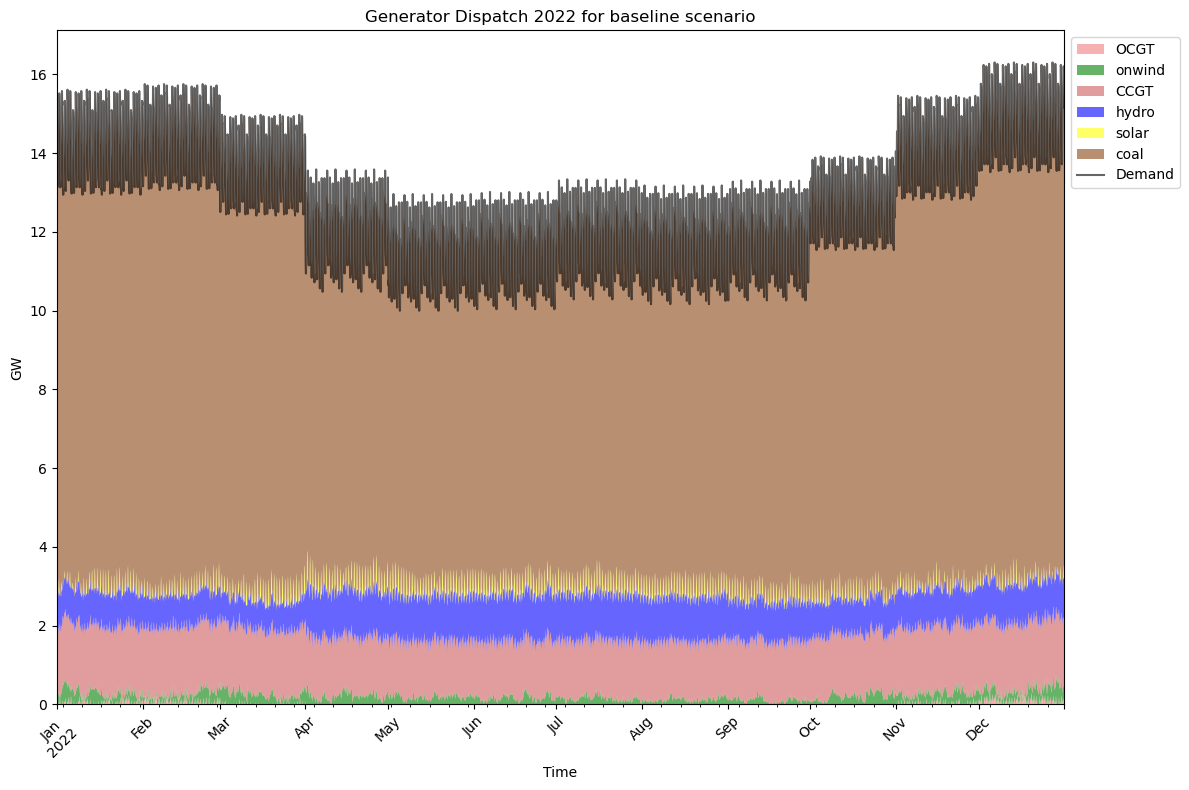

capacity share of renewables : 18.84463033406695 %
generation share of renewables: 10.694271029950201 %


C:\Users\jan.carsten\PyPSA-Setup\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1608: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.

C:\Users\jan.carsten\PyPSA-Setup\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1608: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



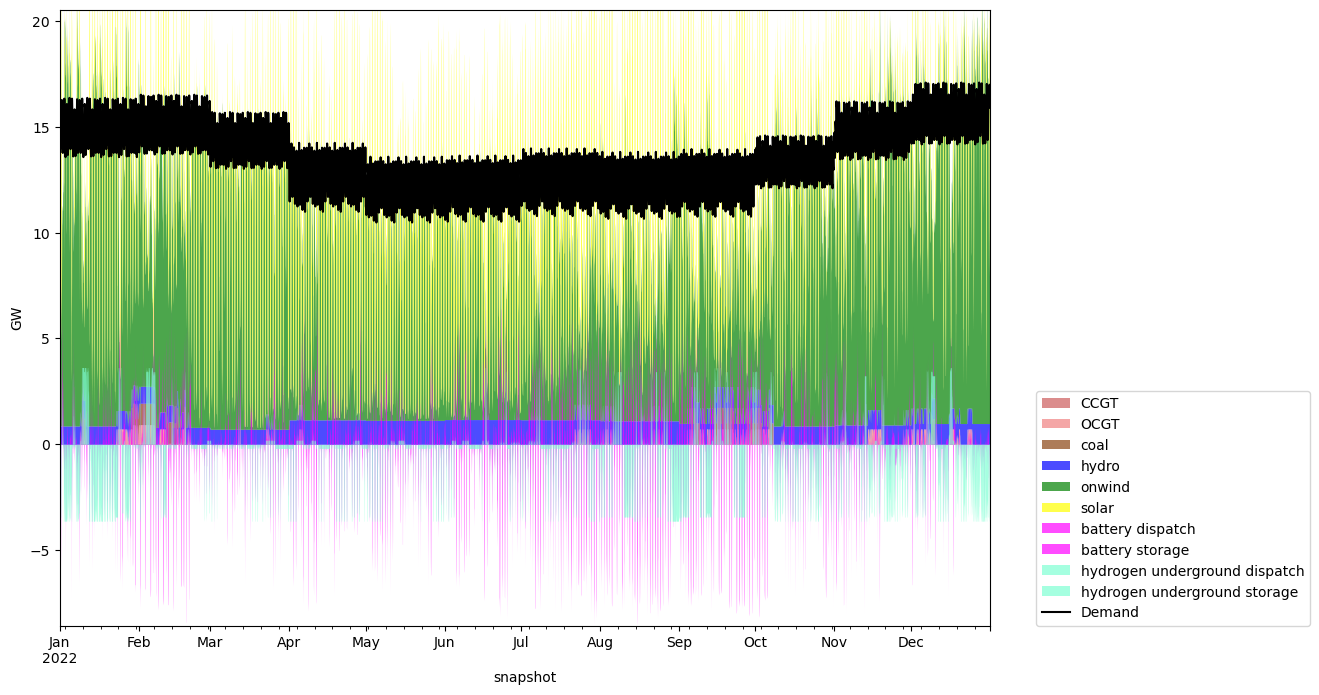

capacity share of renewables : 67.9723353904538 %
generation share of renewables: 98.39947778757622 %


C:\Users\jan.carsten\PyPSA-Setup\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1608: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.

C:\Users\jan.carsten\PyPSA-Setup\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1608: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



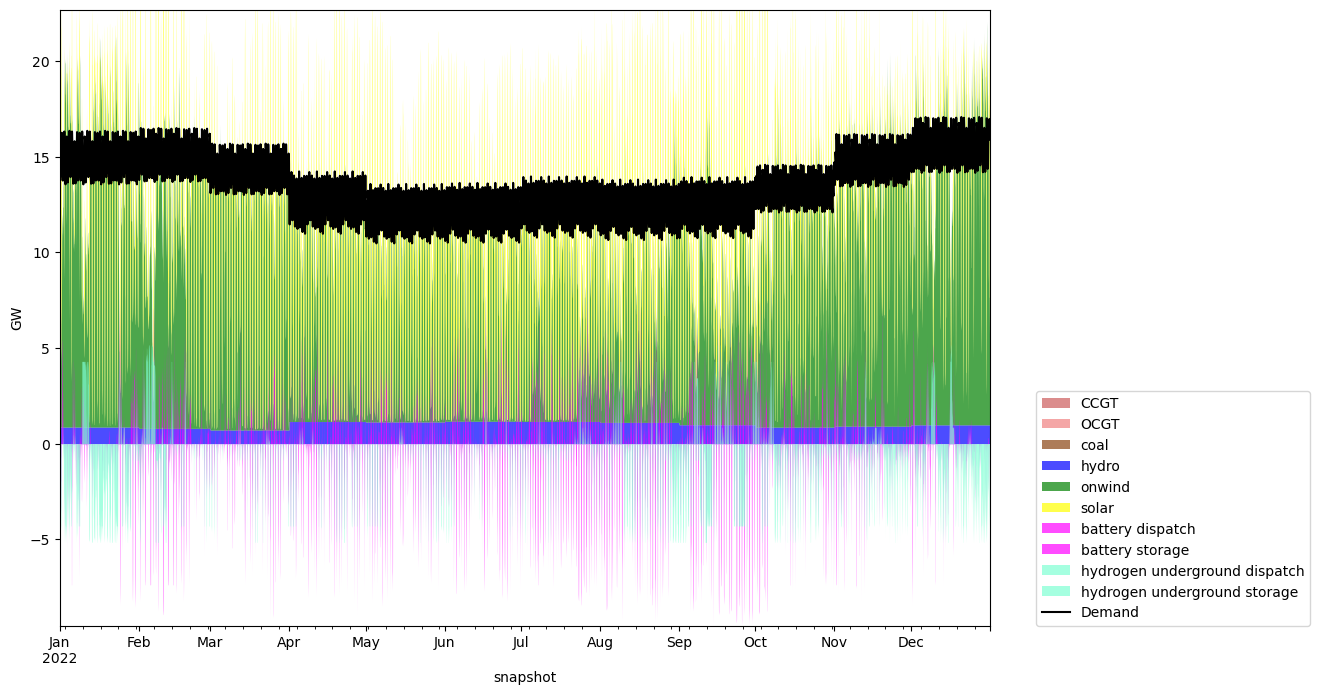

capacity share of renewables : 67.9723353904538 %
generation share of renewables: 99.99986833265065 %


C:\Users\jan.carsten\PyPSA-Setup\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1608: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.

C:\Users\jan.carsten\PyPSA-Setup\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1608: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



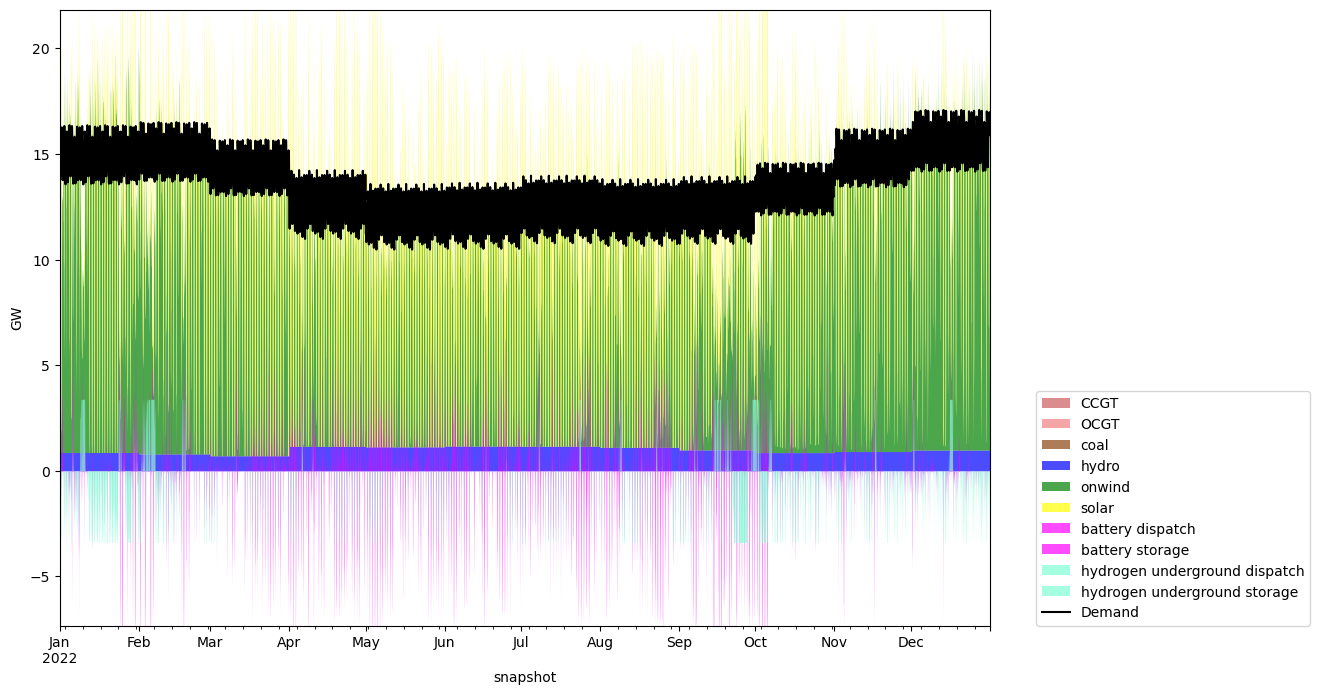

capacity share of renewables : 67.9723353904538 %
generation share of renewables: 99.99980947831965 %


In [161]:
plot_dispatch_no_storage(n)
renewable_shares(n)
plot_dispatch(n2030nC)
renewable_shares(n2030nC)
plot_dispatch(n2030global)
renewable_shares(n2030global)
plot_dispatch(n2030link)
renewable_shares(n2030link)

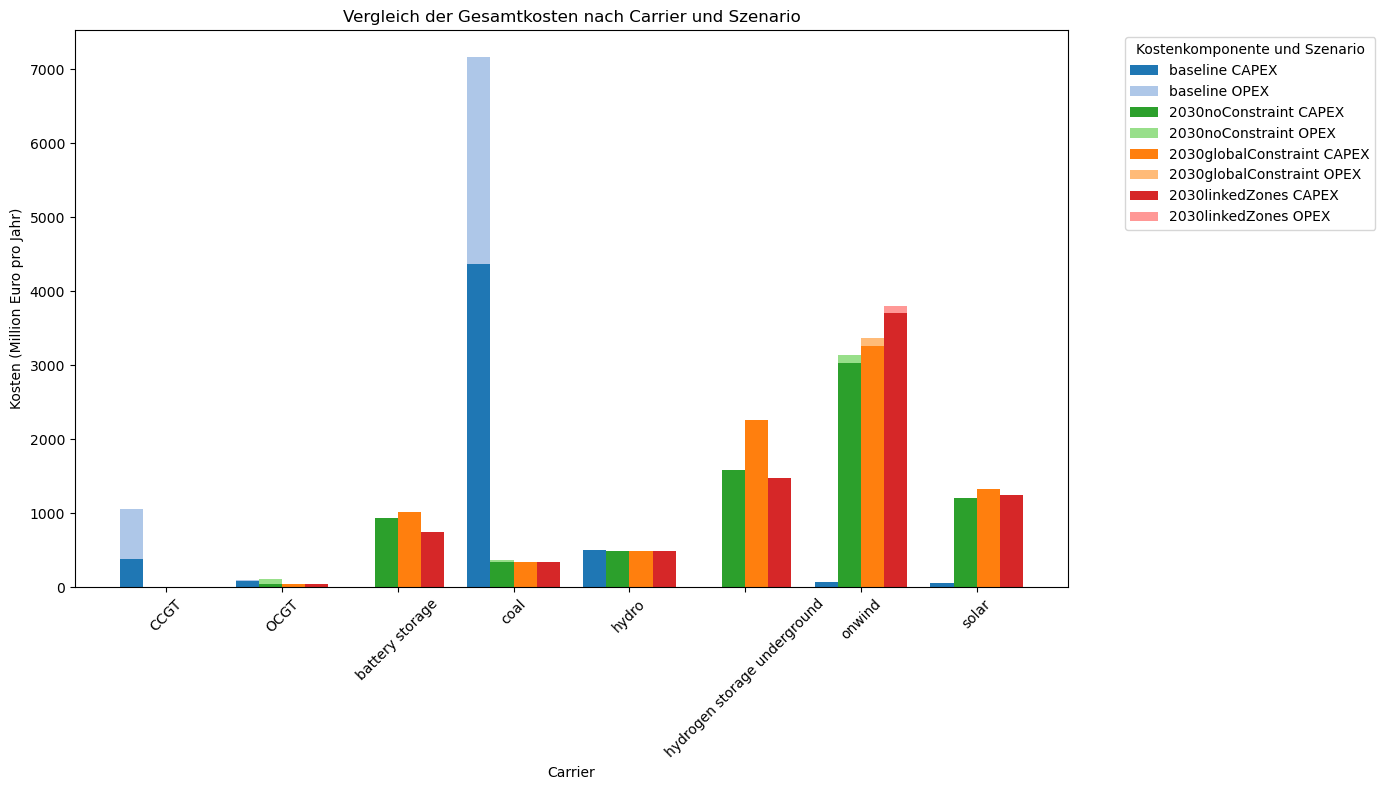

Gesamtkosten des Systems für baseline: 8957.31 Millionen Euro pro Jahr
Gesamtkosten des Systems für 2030noConstraint: 7855.17 Millionen Euro pro Jahr
Gesamtkosten des Systems für 2030globalConstraint: 8835.94 Millionen Euro pro Jahr
Gesamtkosten des Systems für 2030linkedZones: 8157.54 Millionen Euro pro Jahr


In [162]:
# Kostenplot for total cost.
# Plot anpassen, sodass er auch hydrogen underground und batterie anzeigt, auch wenn nicht alle Szenarien das berücksichtigen
def compare_total_cost(scenarios):
    cost_data = []
    scenario_names = []
    for name, n in scenarios.items():
        capex = capex_data(n)
        opex = opex_data(n)
        total_cost = system_cost(n)
        # Sicherstellen, dass alle DataFrames denselben Index haben
        all_carriers = capex.index.union(opex.index).union(total_cost.index)
        capex = capex.reindex(all_carriers).fillna(0)
        opex = opex.reindex(all_carriers).fillna(0)
        total_cost = total_cost.reindex(all_carriers).fillna(0)
        combined_df = pd.DataFrame({
            'CAPEX': capex,
            'OPEX': opex,
            'Carrier': all_carriers
        })
        combined_df['Scenario'] = name
        cost_data.append(combined_df)
        scenario_names.append(name)
    # Zusammenführen der Kosteninformationen aller Szenarien
    combined_cost_df = pd.concat(cost_data)
    combined_cost_df.reset_index(inplace=True, drop=True)
    # Plotting
    fig, ax = plt.subplots(figsize=(14, 8))
    # Pivotieren der Daten für die gestapelten Balken
    pivot_df = combined_cost_df.pivot(index='Carrier', columns='Scenario', values=['CAPEX', 'OPEX'])
    bar_width = 0.2
    scenario_colors = {
        0: {'CAPEX': '#1f77b4', 'OPEX': '#aec7e8'},  # Scenario 1: dunkelblau und hellblau
        1: {'CAPEX': '#2ca02c', 'OPEX': '#98df8a'},  # Scenario 2: dunkelgrün und hellgrün
        2: {'CAPEX': '#ff7f0e', 'OPEX': '#ffbb78'},  # Scenario 3: orange und hellorange
        3: {'CAPEX': '#d62728', 'OPEX': '#ff9896'}   # Scenario 4: rot und hellrot
    }
    # Plotten der Balken für jedes Szenario und Carrier
    for i, scenario in enumerate(scenario_names):
        capex = pivot_df[('CAPEX', scenario)]
        opex = pivot_df[('OPEX', scenario)]
        index = np.arange(len(pivot_df))
        ax.bar(index + i * bar_width, capex, bar_width, label=f'{scenario} CAPEX', color=scenario_colors[i]['CAPEX'])
        ax.bar(index + i * bar_width, opex, bar_width, bottom=capex, label=f'{scenario} OPEX', color=scenario_colors[i]['OPEX'])
    ax.set_title('Vergleich der Gesamtkosten nach Carrier und Szenario')
    ax.set_ylabel('Kosten (Million Euro pro Jahr)')
    ax.set_xlabel('Carrier')
    ax.set_xticks(index + bar_width * (len(scenario_names) - 1) / 2)
    ax.set_xticklabels(pivot_df.index, rotation=45)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title='Kostenkomponente und Szenario', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    # Gesamtkosten pro Szenario ausgeben
    for name, n in scenarios.items():
        total_capex = capex_data(n).sum()
        total_opex = opex_data(n).sum()
        total_costs = total_capex + total_opex
        print(f"Gesamtkosten des Systems für {name}: {total_costs:.2f} Millionen Euro pro Jahr")

# Beispiel-Aufruf der Funktion (die Netzwerke sollten vorher definiert sein)
scenarios = {
    'baseline': n,
    '2030noConstraint': n2030nC,
    '2030globalConstraint': n2030global,
    '2030linkedZones': n2030link,
}
compare_total_cost(scenarios)

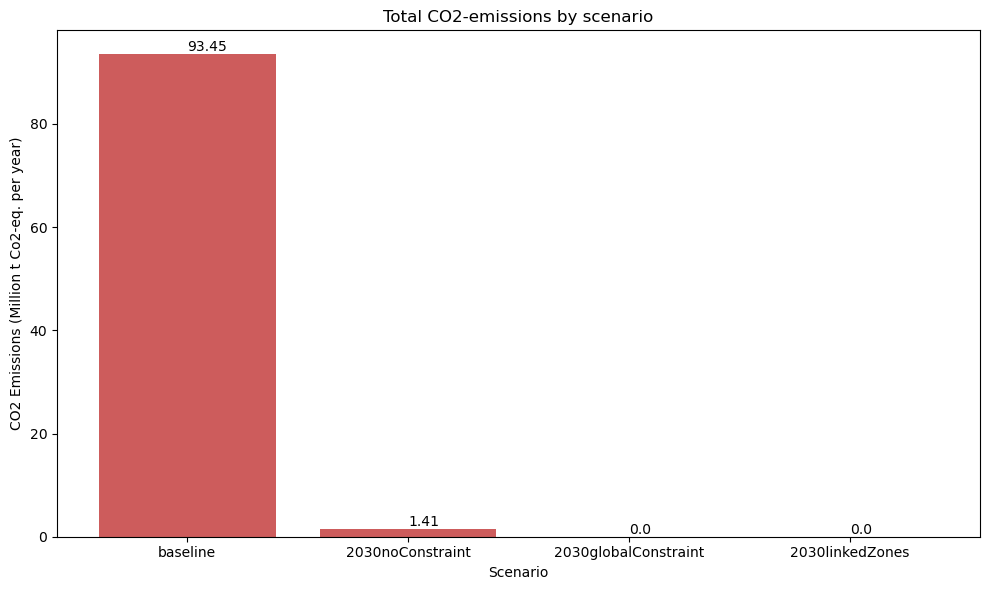

Total CO2 Emissions for baseline: 93.45 Thousand Tonnes per Year
Total CO2 Emissions for 2030noConstraint: 1.41 Thousand Tonnes per Year
Total CO2 Emissions for 2030globalConstraint: 0.00 Thousand Tonnes per Year
Total CO2 Emissions for 2030linkedZones: 0.00 Thousand Tonnes per Year


In [163]:
def calculate_total_co2_emissions(n):
    e = (n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions))  # t/h für die snapshots
    total_co2_emissions = e.sum().sum()  # Gesamte CO2-Emissionen in kg
    total_co2_emissions_million_tonnes = total_co2_emissions / 1e6  # Umrechnung in million tons
    return total_co2_emissions_million_tonnes
def plot_co2_emissions(scenarios):
    emissions_data = []
    for name, n in scenarios.items():
        total_emissions = calculate_total_co2_emissions(n)
        emissions_data.append({'Scenario': name, 'CO2 Emissions': total_emissions})
    emissions_df = pd.DataFrame(emissions_data)
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(emissions_df['Scenario'], emissions_df['CO2 Emissions'], color='indianred')
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # va: vertical alignment
    ax.set_title('Total CO2-emissions by scenario')
    ax.set_ylabel('CO2 Emissions (Million t Co2-eq. per year)')
    ax.set_xlabel('Scenario')
    plt.tight_layout()
    plt.show()
    for data in emissions_data:
        print(f"Total CO2 Emissions for {data['Scenario']}: {data['CO2 Emissions']:.2f} Thousand Tonnes per Year")
        
# Beispiel-Aufruf der Funktion (die Netzwerke sollten vorher definiert sein)
scenarios = {
    'baseline': n,
    '2030noConstraint': n2030nC,
    '2030globalConstraint': n2030global,
    '2030linkedZones': n2030link,
}
plot_co2_emissions(scenarios)

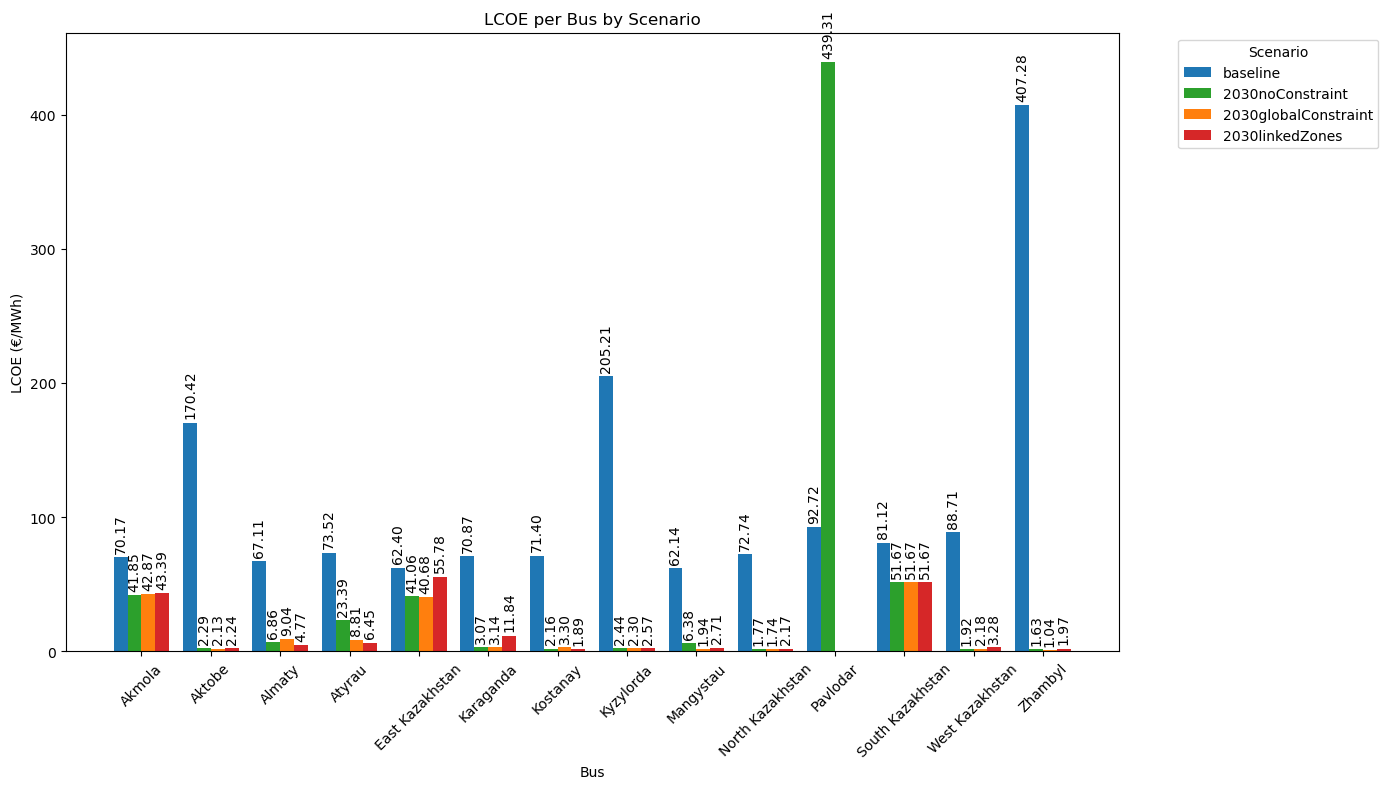

Average LCOE for baseline: 79.31 €/MWh
Average LCOE for 2030noConstraint: 9.88 €/MWh
Average LCOE for 2030globalConstraint: 9.01 €/MWh
Average LCOE for 2030linkedZones: 9.21 €/MWh


In [164]:
def calculate_lcoe(n, costs_data):
    # Berechne die jährliche Energieproduktion pro Bus (in MWh)
    annual_energy_production = n.generators_t.p.sum(axis=0)  # Summe über alle Zeitschritte
    # Filtere Generatoren mit dem Carrier 'import' oder 'export' aus
    filtered_generators = n.generators[~n.generators.carrier.isin(['import', 'export'])]
    annual_energy_production = annual_energy_production[filtered_generators.index]
    annual_energy_production_by_bus = annual_energy_production.groupby(filtered_generators.bus).sum()
    # Berchne die jährlichen Kosten pro Bus
    annual_costs_by_bus = pd.Series(0.0, index=n.buses.index)  # Typ auf float setzen, um Kompatibilitätswarnung zu vermeiden
    for bus in n.buses.index:
        generators_at_bus = filtered_generators[filtered_generators.bus == bus]
        for gen in generators_at_bus.index:
            tech = n.generators.at[gen, 'carrier']
            capex = costs_data.at[tech, 'capital_cost']
            opex = costs_data.at[tech, 'marginal_cost']
            p_nom = n.generators.at[gen, 'p_nom']
            annual_costs_by_bus[bus] += (capex * p_nom + opex * annual_energy_production[gen])
    # Berechne die LCOE pro Bus
    LCOE_by_bus = annual_costs_by_bus / annual_energy_production_by_bus
    LCOE_by_bus = LCOE_by_bus.fillna(0)  # Busse mit 0 Energieerzeugung mit 0 darstellen
    total_energy_production = annual_energy_production_by_bus.sum()
    total_costs = annual_costs_by_bus.sum()
    # Durchschnittliche LCOE des gesamten Szenarios
    average_lcoe = total_costs / total_energy_production
    return LCOE_by_bus, average_lcoe

def plot_lcoe_per_bus(scenarios, costs_data):
    scenario_colors = {
        0: '#1f77b4',  # Scenario 1: dunkelblau
        1: '#2ca02c',  # Scenario 2: dunkelgrün
        2: '#ff7f0e',  # Scenario 3: orange
        3: '#d62728'   # Scenario 4: rot
    }

    fig, ax = plt.subplots(figsize=(14, 8))
    # Berechne die LCOE pro Bus für jedes Szenario
    lcoe_data = {}
    average_lcoe_per_scenario = {}
    for i, (name, n) in enumerate(scenarios.items()):
        lcoe_data[name], average_lcoe_per_scenario[name] = calculate_lcoe(n, costs_data)
    # Vereinheitliche die Busse über alle Szenarien
    all_buses = pd.Index(sorted(set().union(*[lcoe.index for lcoe in lcoe_data.values()])))
    # Potten der LCOE pro Bus für jedes Szenario
    width = 0.2  # Breite der Balken
    x = np.arange(len(all_buses))
    for i, (name, lcoe) in enumerate(lcoe_data.items()):
        # Reindexiere die LCOE-Daten, um sicherzustellen, dass sie die gleichen Busse haben
        lcoe = lcoe.reindex(all_buses).fillna(0)
        bars = ax.bar(x + i * width, lcoe, width, label=name, color=scenario_colors[i])
        # Adding data labels
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', color='black', rotation=90)
    ax.set_title('LCOE per Bus by Scenario')
    ax.set_xlabel('Bus')
    ax.set_ylabel('LCOE (€/MWh)')
    ax.set_xticks(x + width * (len(scenarios) - 1) / 2)
    ax.set_xticklabels(all_buses, rotation=45)
    ax.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    # Durchschnittliche LCOE pro Szenario ausgeben
    for name, avg_lcoe in average_lcoe_per_scenario.items():
        print(f"Average LCOE for {name}: {avg_lcoe:.2f} €/MWh")

# Beispiel-Aufruf der Funktion (die Netzwerke und die Kostendaten sollten vorher definiert sein)
scenarios = {
    'baseline': n,
    '2030noConstraint': n2030nC,
    '2030globalConstraint': n2030global,
    '2030linkedZones': n2030link,
}
plot_lcoe_per_bus(scenarios, costs_data)

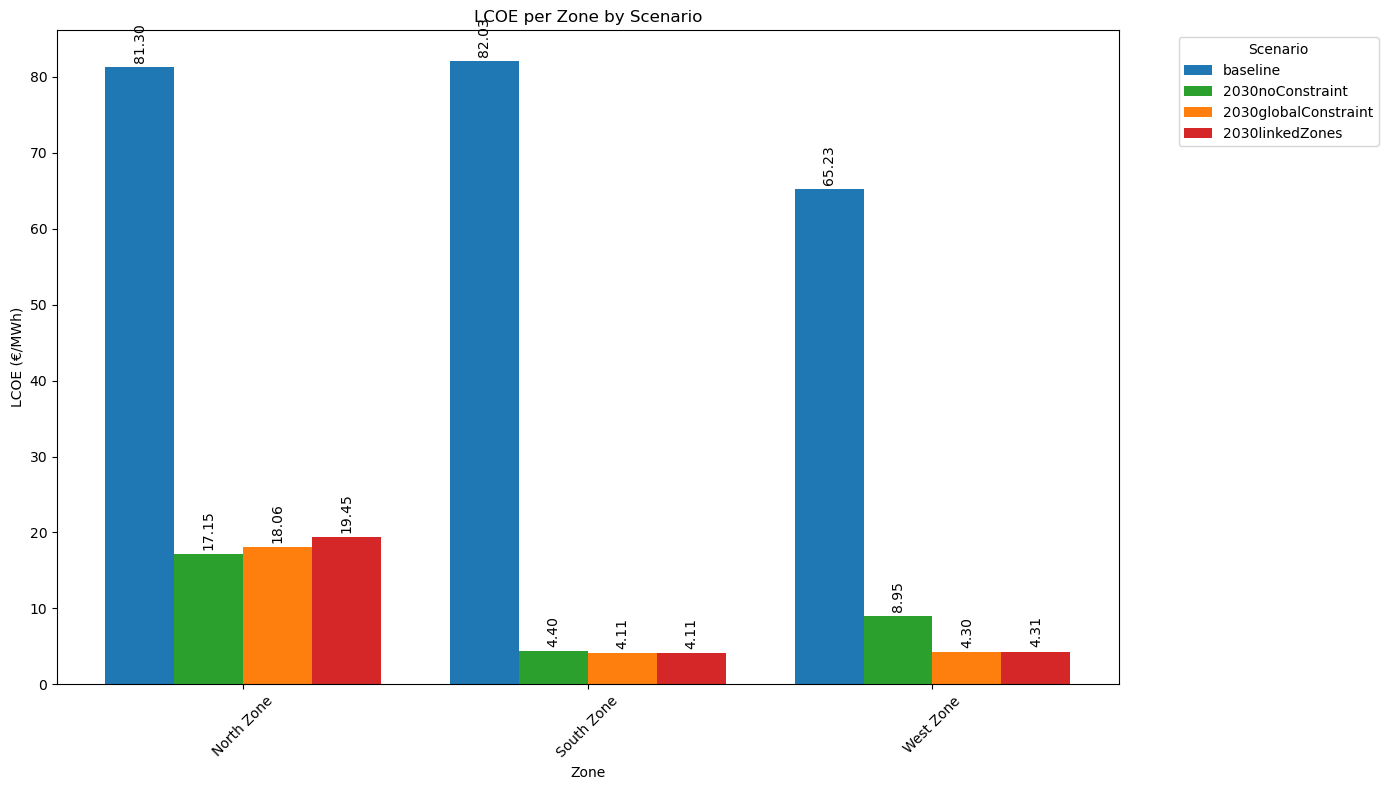

Average LCOE for baseline: 79.31 €/MWh
Average LCOE for 2030noConstraint: 9.88 €/MWh
Average LCOE for 2030globalConstraint: 9.01 €/MWh
Average LCOE for 2030linkedZones: 9.21 €/MWh


In [165]:
# LCOE nach zones:
def calculate_lcoe_per_zone(n, costs_data, zones):
    # Berechne die jährliche Energieproduktion pro Bus (in MWh)
    annual_energy_production = n.generators_t.p.sum(axis=0)  # Summe über alle Zeitschritte
    # Filtere Generatoren mit dem Carrier 'import' oder 'export' aus
    filtered_generators = n.generators[~n.generators.carrier.isin(['import', 'export'])]
    annual_energy_production = annual_energy_production[filtered_generators.index]
    annual_energy_production_by_bus = annual_energy_production.groupby(filtered_generators.bus).sum()
    # Berechne die jährlichen Kosten pro Bus
    annual_costs_by_bus = pd.Series(0.0, index=n.buses.index)  # Typ auf float setzen, um Kompatibilitätswarnung zu vermeiden
    for bus in n.buses.index:
        generators_at_bus = filtered_generators[filtered_generators.bus == bus]
        for gen in generators_at_bus.index:
            tech = n.generators.at[gen, 'carrier']
            capex = costs_data.at[tech, 'capital_cost']
            opex = costs_data.at[tech, 'marginal_cost']
            p_nom = n.generators.at[gen, 'p_nom']
            annual_costs_by_bus[bus] += (capex * p_nom + opex * annual_energy_production[gen])

    # Berechne die LCOE pro Zone
    annual_energy_production_by_zone = annual_energy_production_by_bus.groupby(zones).sum()
    annual_costs_by_zone = annual_costs_by_bus.groupby(zones).sum()
    LCOE_by_zone = annual_costs_by_zone / annual_energy_production_by_zone
    LCOE_by_zone = LCOE_by_zone.fillna(0)  # Zonen mit 0 Energieerzeugung mit 0 darstellen

    total_energy_production = annual_energy_production_by_zone.sum()
    total_costs = annual_costs_by_zone.sum()
    # Durchschnittliche LCOE des gesamten Szenarios
    average_lcoe = total_costs / total_energy_production

    return LCOE_by_zone, average_lcoe

def plot_lcoe_per_zone(scenarios, costs_data, zones):
    scenario_colors = {
        0: '#1f77b4',  # Scenario 1: dunkelblau
        1: '#2ca02c',  # Scenario 2: dunkelgrün
        2: '#ff7f0e',  # Scenario 3: orange
        3: '#d62728'   # Scenario 4: rot
    }
    fig, ax = plt.subplots(figsize=(14, 8))
    # Berechne die LCOE pro Zone für jedes Szenario
    lcoe_data = {}
    average_lcoe_per_scenario = {}
    for i, (name, n) in enumerate(scenarios.items()):
        lcoe_data[name], average_lcoe_per_scenario[name] = calculate_lcoe_per_zone(n, costs_data, zones)
    # Vereinheitliche die Zonen über alle Szenarien
    all_zones = pd.Index(sorted(set().union(*[lcoe.index for lcoe in lcoe_data.values()])))
    # Plotten der LCOE pro Zone für jedes Szenario
    width = 0.2  # Breite der Balken
    x = np.arange(len(all_zones))
    for i, (name, lcoe) in enumerate(lcoe_data.items()):
        # Reindexiere die LCOE-Daten, um sicherzustellen, dass sie die gleichen Zonen haben
        lcoe = lcoe.reindex(all_zones).fillna(0)
        bars = ax.bar(x + i * width, lcoe, width, label=name, color=scenario_colors[i])
        # Adding data labels
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', color='black', rotation=90)
    ax.set_title('LCOE per Zone by Scenario')
    ax.set_xlabel('Zone')
    ax.set_ylabel('LCOE (€/MWh)')
    ax.set_xticks(x + width * (len(scenarios) - 1) / 2)
    ax.set_xticklabels(all_zones, rotation=45)
    ax.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    # Durchschnittliche LCOE pro Szenario ausgeben
    for name, avg_lcoe in average_lcoe_per_scenario.items():
        print(f"Average LCOE for {name}: {avg_lcoe:.2f} €/MWh")
# Beispiel-Aufruf der Funktion (die Netzwerke und die Kostendaten sollten vorher definiert sein)
scenarios = {
    'baseline': n,
    '2030noConstraint': n2030nC,
    '2030globalConstraint': n2030global,
    '2030linkedZones': n2030link,
}
zones = {    
    "West Zone": ["West Kazakhstan", "Atyrau", "Mangystau"],
    "North Zone": ["Aktobe", "Akmola", "Karaganda", "Kostanay", "Pavlodar", "North Kazakhstan", "East Kazakhstan"],
    "South Zone": ["Almaty", "Kyzylorda", "South Kazakhstan", "Zhambyl"]
}
# Mapping buses to zones
bus_to_zone = {}
for zone, buses in zones.items():
    for bus in buses:
        bus_to_zone[bus] = zone

plot_lcoe_per_zone(scenarios, costs_data, pd.Series(bus_to_zone))

In [166]:
def calculate_lcoe_per_carrier(n, costs_data):
    # Calculate the annual energy production per carrier (in MWh)
    annual_energy_production = n.generators_t.p.sum(axis=0)  # Sum over all time steps
    filtered_generators = n.generators[~n.generators.carrier.isin(['import', 'export'])]
    annual_energy_production = annual_energy_production[filtered_generators.index]
    annual_energy_production_by_carrier = annual_energy_production.groupby(filtered_generators.carrier).sum()
    # Calculate the annual costs per carrier
    annual_costs_by_carrier = pd.Series(0.0, index=filtered_generators.carrier.unique())
    for carrier in filtered_generators.carrier.unique():
        generators_of_carrier = filtered_generators[filtered_generators.carrier == carrier]
        for gen in generators_of_carrier.index:
            capex = costs_data.at[n.generators.at[gen, 'carrier'], 'capital_cost']
            opex = costs_data.at[n.generators.at[gen, 'carrier'], 'marginal_cost']
            p_nom = n.generators.at[gen, 'p_nom']
            annual_costs_by_carrier[carrier] += (capex * p_nom + opex * annual_energy_production[gen])
    # Calculate the LCOE per carrier
    LCOE_by_carrier = annual_costs_by_carrier / annual_energy_production_by_carrier
    LCOE_by_carrier = LCOE_by_carrier.fillna(0)  # Fill carriers with 0 energy production with 0
    total_energy_production = annual_energy_production_by_carrier.sum()
    total_costs = annual_costs_by_carrier.sum()
    # Average LCOE of the entire scenario
    average_lcoe = total_costs / total_energy_production
    return LCOE_by_carrier, average_lcoe
# Beispielaufruf der Funktion (die Netzwerke und die Kostendaten sollten vorher definiert sein)
scenarios = {
    'baseline': n,
    '2030noConstraint': n2030nC,
    '2030globalConstraint': n2030global,
    '2030linkedZones': n2030link,
}
for name, network in scenarios.items():
    lcoe_by_carrier, avg_lcoe = calculate_lcoe_per_carrier(network, costs_data)
    print(f"Scenario: {name}")
    print("LCOE by Carrier:")
    print(lcoe_by_carrier)
    print(f"Average LCOE: {avg_lcoe:.2f} €/MWh")

Scenario: baseline
LCOE by Carrier:
CCGT       76.486351
OCGT      466.830793
coal       82.554591
hydro      55.793617
onwind     41.643257
solar      47.162948
dtype: float64
Average LCOE: 79.31 €/MWh
Scenario: 2030noConstraint
LCOE by Carrier:
CCGT      386.683806
OCGT      104.555386
coal      439.305046
hydro      55.793617
onwind      2.580776
solar       1.566560
dtype: float64
Average LCOE: 9.88 €/MWh
Scenario: 2030globalConstraint
LCOE by Carrier:
CCGT               inf
OCGT      2.666083e+05
coal               inf
hydro     5.579362e+01
onwind    2.611337e+00
solar     1.415174e+00
dtype: float64
Average LCOE: 9.01 €/MWh
Scenario: 2030linkedZones
LCOE by Carrier:
CCGT      2.297235e+04
OCGT               inf
coal               inf
hydro     5.579362e+01
onwind    2.627217e+00
solar     1.471169e+00
dtype: float64
Average LCOE: 9.21 €/MWh


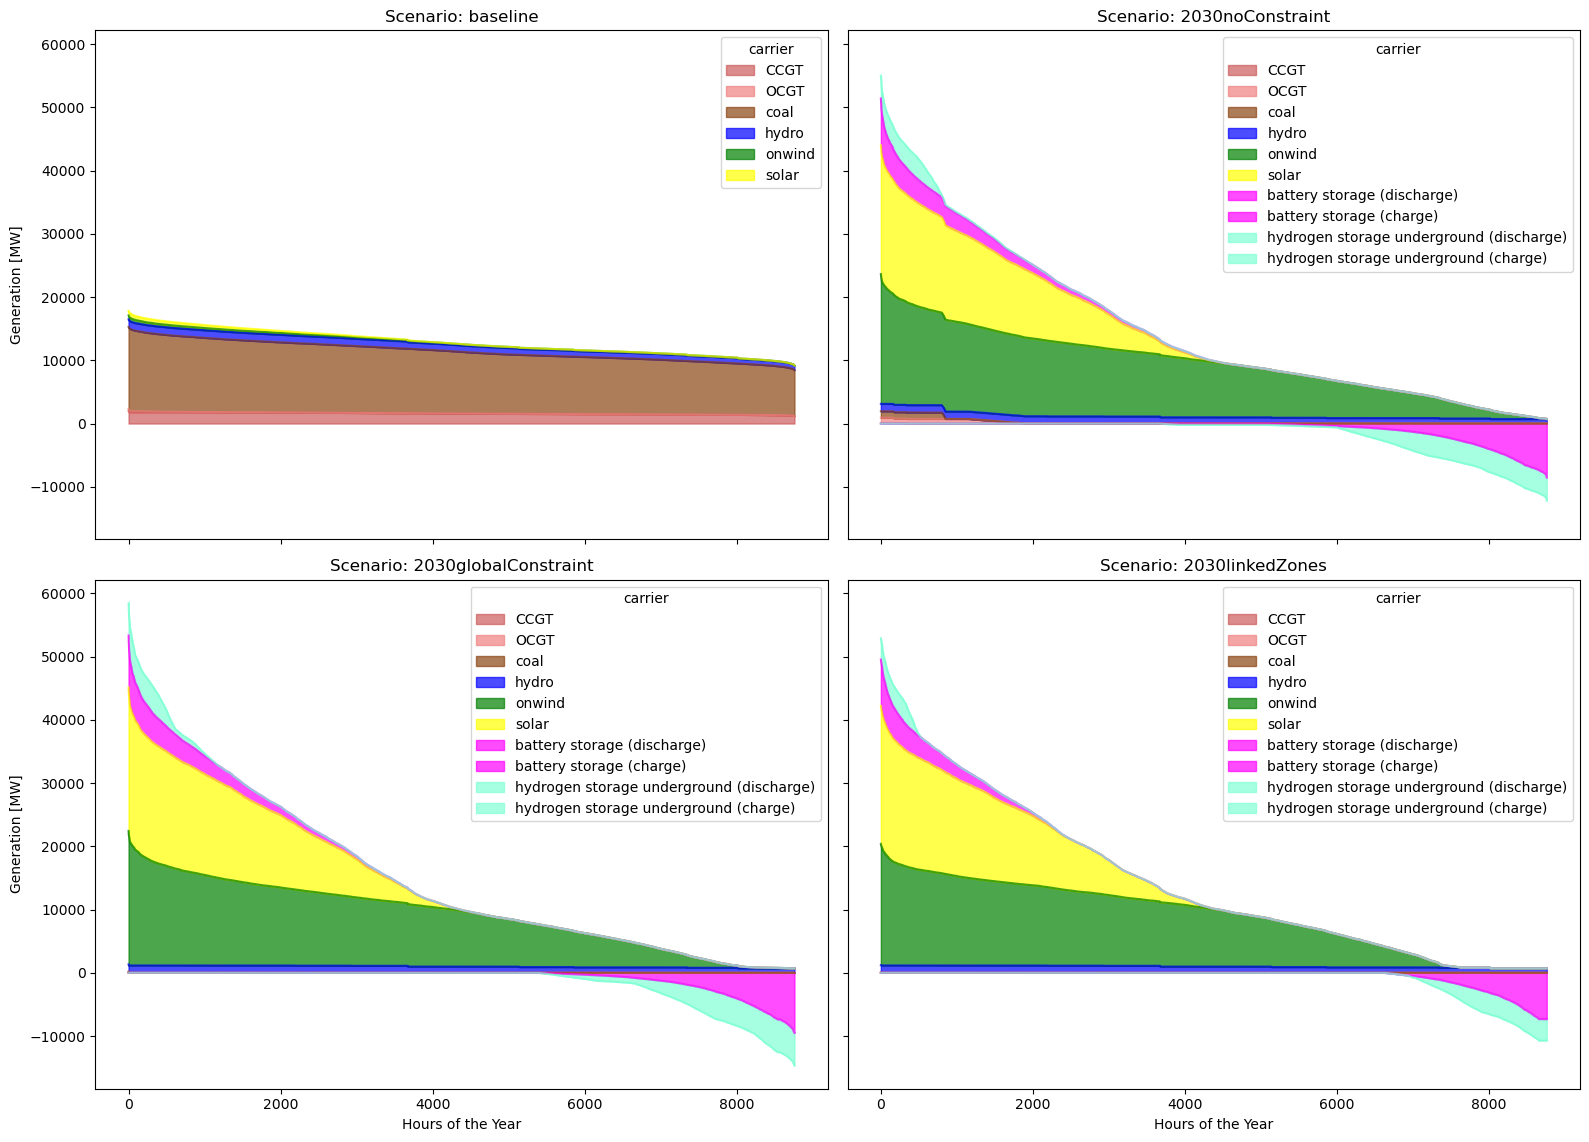

In [184]:
# Stacked area plot for all my scenarios including storage function
def plot_stacked_load_duration_curve(scenarios):
    # Berechnen der Anzahl der Reihen für die Subplots basierend auf der Anzahl der Szenarien
    num_scenarios = len(scenarios)
    rows = (num_scenarios + 1) // 2
    fig, axs = plt.subplots(rows, 2, figsize=(16, 6 * rows), sharex=True, sharey=True)
    # Flachstellen des axs-Arrays für eine einfache Iteration
    axs = axs.flatten()
    # Iteration über jedes Szenario
    for i, (name, n) in enumerate(scenarios.items()):
        # Berechnen der gesamten Erzeugung pro Carrier
        generation_by_carrier = n.generators_t.p.T.groupby(n.generators.carrier).sum().T
        # Einbeziehen der Batteriespeicherung, separate positive und negative Werte
        if 'battery storage' in n.storage_units.carrier.unique():
            battery_storage = n.storage_units_t.p.loc[:, n.storage_units.carrier == 'battery storage']
            battery_storage_pos = battery_storage[battery_storage > 0].sum(axis=1)
            battery_storage_neg = battery_storage[battery_storage < 0].sum(axis=1)
            generation_by_carrier['battery storage (discharge)'] = battery_storage_pos
            generation_by_carrier['battery storage (charge)'] = battery_storage_neg
        # Einbeziehen der Wasserstoffspeicherung (Untergrundspeicherung), separate positive und negative Werte
        if 'hydrogen storage underground' in n.storage_units.carrier.unique():
            hydrogen_storage = n.storage_units_t.p.loc[:, n.storage_units.carrier == 'hydrogen storage underground']
            hydrogen_storage_pos = hydrogen_storage[hydrogen_storage > 0].sum(axis=1)
            hydrogen_storage_neg = hydrogen_storage[hydrogen_storage < 0].sum(axis=1)
            generation_by_carrier['hydrogen storage underground (discharge)'] = hydrogen_storage_pos
            generation_by_carrier['hydrogen storage underground (charge)'] = hydrogen_storage_neg
        # Sortieren der Erzeugung für jeden Carrier in absteigender Reihenfolge zur Erstellung der Jahresdauerlinie
        sorted_generation = generation_by_carrier.apply(lambda x: x.sort_values(ascending=False).values, axis=0)
        # Berechnen der Anzahl der Stunden im Jahr
        hours = range(len(sorted_generation))
        # Erstellen eines DataFrames zum Plotten
        sorted_generation.index = hours
        sorted_generation = sorted_generation.fillna(0)  # Füllen von NaN-Werten mit 0 für das Plotten
        # Abrufen der Carrier-Farben und Handhaben fehlender Farben
        carrier_colors = n.carriers.color.reindex(sorted_generation.columns)
        if 'battery storage (discharge)' in carrier_colors.index:
            carrier_colors['battery storage (discharge)'] = n.carriers.loc['battery storage', 'color']
        if 'battery storage (charge)' in carrier_colors.index:
            carrier_colors['battery storage (charge)'] = n.carriers.loc['battery storage', 'color']
        if 'hydrogen storage underground (discharge)' in carrier_colors.index:
            carrier_colors['hydrogen storage underground (discharge)'] = n.carriers.loc['hydrogen storage underground', 'color']
        if 'hydrogen storage underground (charge)' in carrier_colors.index:
            carrier_colors['hydrogen storage underground (charge)'] = n.carriers.loc['hydrogen storage underground', 'color']
        carrier_colors = carrier_colors.fillna('magenta')  # Zuweisen einer Standardfarbe für fehlende Carrier
        # Erstellen des gestapelten Bereichsdiagramms
        sorted_generation.plot.area(ax=axs[i], stacked=True, color=carrier_colors, alpha=0.7)
        # Festlegen der Beschriftungen und des Titels für das Diagramm
        axs[i].set_title(f'Scenario: {name}')
        axs[i].set_xlabel('Hours of the Year')
        axs[i].set_ylabel('Generation [MW]')
    # Verstecken aller ungenutzten Subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    # Anpassung des Layouts und Anzeigen des Diagramms
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
# Beispielaufruf der Funktion
scenarios = {
    'baseline': n,
    '2030noConstraint': n2030nC,
    '2030globalConstraint': n2030global,
    '2030linkedZones': n2030link,
}
plot_stacked_load_duration_curve(scenarios)

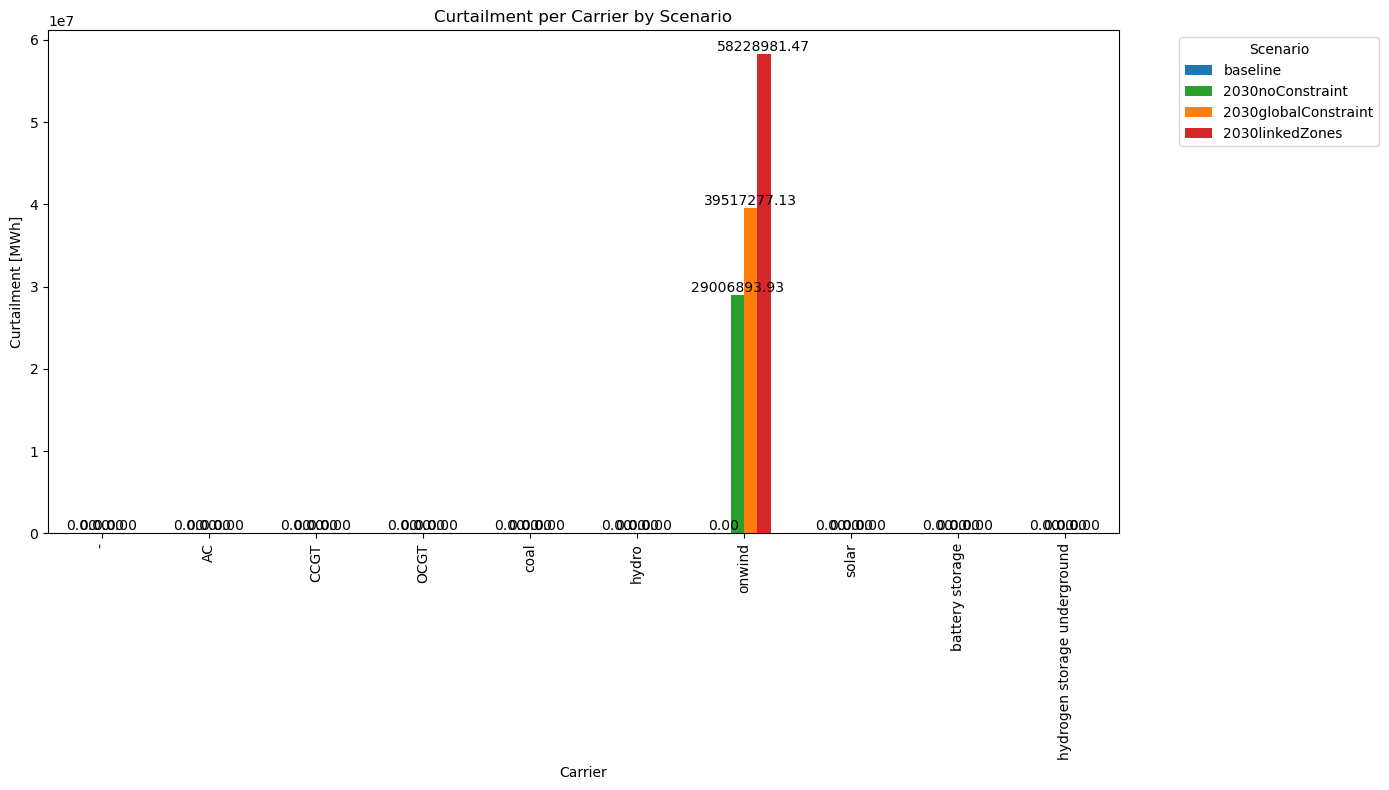

In [258]:
# plot curtailment by carrier
def extract_curtailment_data(scenarios):
    curtailment_data = []
    for name, n in scenarios.items():
        stats = n.statistics()
        # Access the 'Curtailment' column
        curtailment = stats.loc[:, 'Curtailment']
        # Group curtailment by carrier and sum
        curtailment_by_carrier = curtailment.groupby(stats.index.get_level_values(1)).sum()
        curtailment_by_carrier.name = name
        curtailment_data.append(curtailment_by_carrier)

    # Combine the curtailment data into a single DataFrame
    combined_df = pd.concat(curtailment_data, axis=1)
    combined_df = combined_df.fillna(0)  # Fill NaN values with 0
    return combined_df

def plot_curtailment(scenarios):
    curtailment_df = extract_curtailment_data(scenarios)
    #print(curtailment_df)
    # Plotting
    fig, ax = plt.subplots(figsize=(14, 8))
    curtailment_df.plot(kind='bar', ax=ax, color=['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728'])
    # Adding data labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge')
    ax.set_title('Curtailment per Carrier by Scenario')
    ax.set_xlabel('Carrier')
    ax.set_ylabel('Curtailment [MWh]')
    ax.legend(title='Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
# Example usage
scenarios = {
    'baseline': n,
    '2030noConstraint': n2030nC,
    '2030globalConstraint': n2030global,
    '2030linkedZones': n2030link,
}
plot_curtailment(scenarios)

In [275]:
n.generators["marginal_cost"]

Generator
Akmola_coal_0                 32.213321
Akmola_coal_1                 32.213321
Akmola_coal_2                 32.213321
Aktobe_CCGT_3                 48.527629
Aktobe_OCGT_4                 66.182000
                                ...    
Akmola_onwind_139              1.587300
East Kazakhstan_onwind_140     1.587300
South Kazakhstan_solar_141     0.010600
South Kazakhstan_solar_142     0.010600
Mangystau_OCGT_143            66.182000
Name: marginal_cost, Length: 144, dtype: float64

In [ ]:
# Ergebnis: Curtailment Berechnung in n.statistics lässt sich nicht genau reproduzieren. Leider sind dort keine Informationen enthalten, 
# anwelchem Bus das Curtailment entsteht.

C:\Users\jan.carsten\AppData\Local\Temp\ipykernel_4540\3514189752.py:42: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



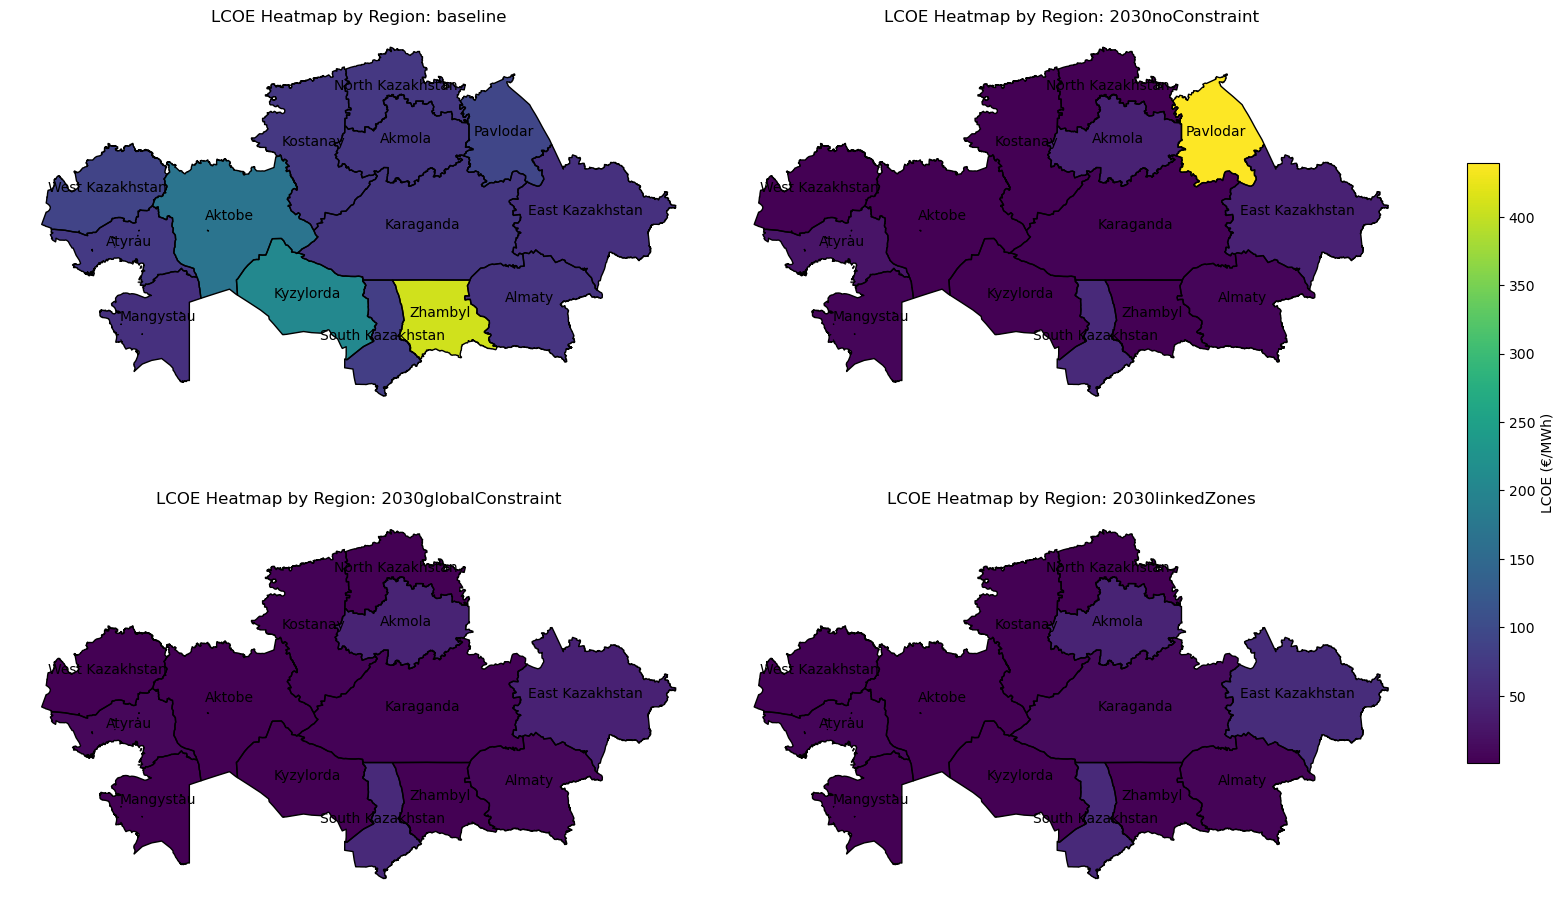

In [268]:
# LCOE Heatmaps for all scenarios:
def plot_lcoe_heatmap(scenarios, costs_data, shapefile_path, region_mapping):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    regions = gpd.read_file(shapefile_path)
    min_lcoe = float('inf')
    max_lcoe = -float('inf')
    all_merged_gdfs = []
    for i, (name, n) in enumerate(scenarios.items()):
        LCOE_by_bus = calculate_lcoe(n, costs_data)
        LCOE_df = pd.DataFrame(LCOE_by_bus).reset_index()
        LCOE_df.columns = ['bus', 'LCOE']
        merged_data = []
        for region, subregions in region_mapping.items():
            subregion_shapes = regions[regions['ADM1_EN'].isin(subregions)]
            if not subregion_shapes.empty:
                merged_shape = subregion_shapes.unary_union
                if region in LCOE_df['bus'].values:
                    avg_lcoe = LCOE_df[LCOE_df['bus'] == region]['LCOE'].values[0]
                    merged_data.append({'Region': region, 'geometry': merged_shape, 'LCOE': avg_lcoe})
        merged_gdf = gpd.GeoDataFrame(merged_data, crs=regions.crs)
        all_merged_gdfs.append(merged_gdf)
        if not merged_gdf['LCOE'].isnull().all():
            min_lcoe = min(min_lcoe, merged_gdf['LCOE'].min())
            max_lcoe = max(max_lcoe, merged_gdf['LCOE'].max())
    for i, (name, merged_gdf) in enumerate(zip(scenarios.keys(), all_merged_gdfs)):
        ax = axes[i]
        merged_gdf.boundary.plot(ax=ax, linewidth=1, color='black')
        plot = merged_gdf.plot(column='LCOE', ax=ax, cmap='viridis', vmin=min_lcoe, vmax=max_lcoe)
        for idx, row in merged_gdf.iterrows():
            centroid = row['geometry'].centroid
            ax.annotate(text=row['Region'], xy=(centroid.x, centroid.y), horizontalalignment='center', fontsize=10, color='black')
        ax.set_title(f'LCOE Heatmap by Region: {name}')
        ax.set_axis_off()

    # Create a common color bar
    cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_lcoe, vmax=max_lcoe))
    sm._A = []
    fig.colorbar(sm, cax=cax, label="LCOE (€/MWh)")

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

plot_lcoe_heatmap(scenarios, costs_data, shapefile_path, region_mapping)

# Generate scenario outputs as .xslx:

In [269]:
# Output Code: Functions to calculate missing values and function to create .xlsc output.
# WATCHOUT: It overwrites existing results by compiling again!
# Gerne um weitere Daten erweitern.
def calculate_capex(network, costs_data):
    capex = pd.Series(0.0, index=network.generators.index)
    for gen in network.generators.index:
        carrier = network.generators.at[gen, 'carrier']
        p_nom = network.generators.at[gen, 'p_nom']
        capex[gen] = costs_data.at[carrier, 'capital_cost'] * p_nom
    return capex

def calculate_opex(network, costs_data):
    opex = pd.Series(0.0, index=network.generators.index)
    for gen in network.generators.index:
        carrier = network.generators.at[gen, 'carrier']
        p_nom = network.generators.at[gen, 'p_nom']
        opex[gen] = costs_data.at[carrier, 'marginal_cost'] * network.generators_t.p[gen].sum()
    return opex

def calculate_annuity(network, costs_data, discount_rate=0.07, lifetime=20):
    annuity = pd.Series(0.0, index=network.generators.index)
    for gen in network.generators.index:
        carrier = network.generators.at[gen, 'carrier']
        capex = costs_data.at[carrier, 'capital_cost'] * network.generators.at[gen, 'p_nom']
        annuity[gen] = capex * calc_annuity(discount_rate, lifetime)
    return annuity

def create_scenario_excel(network, scenario_name, costs_data):
    wb = Workbook()
    
    blue_fill = PatternFill(start_color="ADD8E6", end_color="ADD8E6", fill_type="solid")
    green_fill = PatternFill(start_color="90EE90", end_color="90EE90", fill_type="solid")
    
    # Content Sheet
    content_sheet = wb.active
    content_sheet.title = "Content"
    sheets = ["Carrier", "Bus", "System Economics", "Carrier Economics", "Region Economics", "Statistics"]
    for idx, sheet in enumerate(sheets, 1):
        content_sheet.cell(row=idx, column=1, value=sheet)
        link = f"#{sheet}!A1"
        content_sheet.cell(row=idx, column=1).hyperlink = link
    
    # Technical Sheets
    carrier_sheet = wb.create_sheet(title="Carrier")
    carrier_sheet.sheet_properties.tabColor = "ADD8E6"
    
    bus_sheet = wb.create_sheet(title="Bus")
    bus_sheet.sheet_properties.tabColor = "ADD8E6"
    
    # Economics Sheets
    system_sheet = wb.create_sheet(title="System Economics")
    system_sheet.sheet_properties.tabColor = "90EE90"
    
    carrier_econ_sheet = wb.create_sheet(title="Carrier Economics")
    carrier_econ_sheet.sheet_properties.tabColor = "90EE90"
    
    region_econ_sheet = wb.create_sheet(title="Region Economics")
    region_econ_sheet.sheet_properties.tabColor = "90EE90"
    
    # Statistics Sheet
    stats_sheet = wb.create_sheet(title="Statistics")
    stats_sheet.sheet_properties.tabColor = "D3D3D3"
    
    # Technical - Carrier
    carrier_data = {
        "Capacity (MW)": network.generators.groupby("carrier").p_nom.sum(),
        "Energy Produced (MWh)": network.generators_t.p.sum(axis=0).groupby(network.generators.carrier).sum(),
        "Curtailment (MWh)": network.statistics().loc[:, 'Curtailment'].groupby(network.generators.carrier).sum(),
        "Emissions (tCO2)": (network.generators_t.p.sum(axis=0) / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)).groupby(network.generators.carrier).sum()
    }
    carrier_df = pd.DataFrame(carrier_data)
    for r in dataframe_to_rows(carrier_df, index=True, header=True):
        carrier_sheet.append(r)
    
    # Technical - Bus
    bus_data = {
        "Capacity (MW)": network.generators.groupby("bus").p_nom.sum(),
        "Energy Produced (MWh)": network.generators_t.p.sum(axis=0).groupby(network.generators.bus).sum(),
        "Emissions (tCO2)": (network.generators_t.p.sum(axis=0) / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)).groupby(network.generators.bus).sum()
    }
    bus_df = pd.DataFrame(bus_data)
    for r in dataframe_to_rows(bus_df, index=True, header=True):
        bus_sheet.append(r)
    
    # Economics - System
    average_lcoe = calculate_lcoe(network, costs_data)[1]
    system_econ_data = {
        "Capex (EUR)": costs_data['capital_cost'].sum(),
        "Opex (EUR)": costs_data['marginal_cost'].sum(),
        "Annuität (EUR)": (costs_data['capital_cost'] + costs_data['marginal_cost']).sum() * calc_annuity(0.07, 20),
        "LCOE (EUR/MWh)": average_lcoe
    }
    system_econ_df = pd.DataFrame(system_econ_data, index=[0])
    for r in dataframe_to_rows(system_econ_df, index=False, header=True):
        system_sheet.append(r)
    
    # Economics - Carrier
    capex_by_carrier = calculate_capex(network, costs_data).groupby(network.generators.carrier).sum()
    opex_by_carrier = calculate_opex(network, costs_data).groupby(network.generators.carrier).sum()
    annuity_by_carrier = calculate_annuity(network, costs_data).groupby(network.generators.carrier).sum()
    carrier_lcoe, average_lcoe = calculate_lcoe_per_carrier(network, costs_data)
    carrier_econ_data = {
        "Capex (EUR)": capex_by_carrier,
        "Opex (EUR)": opex_by_carrier,
        "Annuität (EUR)": annuity_by_carrier,
        "LCOE (EUR/MWh)": carrier_lcoe
    }
    carrier_econ_df = pd.DataFrame(carrier_econ_data)
    for r in dataframe_to_rows(carrier_econ_df, index=True, header=True):
        carrier_econ_sheet.append(r)
    
    # Economics - Region
    capex_by_bus = calculate_capex(network, costs_data).groupby(network.generators.bus).sum()
    opex_by_bus = calculate_opex(network, costs_data).groupby(network.generators.bus).sum()
    annuity_by_bus = calculate_annuity(network, costs_data).groupby(network.generators.bus).sum()
    bus_lcoe, average_lcoe = calculate_lcoe(network, costs_data)
    region_econ_data = {
        "Capex (EUR)": capex_by_bus,
        "Opex (EUR)": opex_by_bus,
        "Annuität (EUR)": annuity_by_bus,
        "LCOE (EUR/MWh)": bus_lcoe
    }
    region_econ_df = pd.DataFrame(region_econ_data)
    for r in dataframe_to_rows(region_econ_df, index=True, header=True):
        region_econ_sheet.append(r)
    
    # Statistics
    stats_df = network.statistics()
    for r in dataframe_to_rows(stats_df, index=True, header=True):
        stats_sheet.append(r)
    
    # Save the workbook
    wb.save(f"{scenario_name}_report.xlsx")

# Example usage
scenarios = {
    'baseline': n,
    '2030noConstraint': n2030nC,
    '2030globalConstraint': n2030global,
    '2030linkedZones': n2030link,
}
#for name, network in scenarios.items():
 #   create_scenario_excel(network, name, costs_data)
# Gemeinsame Übersicht üer alle Scenario KPIs

### 07 Sensitivitätsanalyse

In [123]:
# What is of interest;
# Cost data
# Interest rate von Annuitäten